In [1]:
# Import all necessary libraries

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.python.ops.numpy_ops import np_config

import numpy as np
import os
from PIL import Image
import cv2
from PIL import ImageFilter
import textwrap, os

In [1]:
np_config.enable_numpy_behavior()
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)
    return image

def preprocess_image(image):
    image = tf.image.resize(image, (32, 32))
    image = tf.cast(image, tf.float32) / 255.0
    image = image[..., :3]  # Remove the fourth channel if present
    return image

def create_dataset(image_paths, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    print(dataset)

    return dataset

# Load image paths
image_paths = [path for path in tf.io.gfile.glob(r'C:\Users\diego\Documents\Paintings\cifar10\plane\*.png')]

# Split the image paths into a training set and validation set
train_image_paths = image_paths[:int(len(image_paths) * 0.8)]
val_image_paths = image_paths[int(len(image_paths) * 0.8):]

# Create the training and validation datasets
batch_size = 128
train_dataset = create_dataset(train_image_paths, batch_size, is_training=True)
val_dataset = create_dataset(val_image_paths, batch_size, is_training=False)


<PrefetchDataset element_spec=TensorSpec(shape=(128, 32, 32, None), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=TensorSpec(shape=(128, 32, 32, None), dtype=tf.float32, name=None)>


In [4]:
# Declaration of the hyperparameters

# data
num_epochs = 500 
image_size = 32
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 128
depth = 4
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 128
learning_rate = 2e-3
beta_1 = 0.5
ema = 0.99

In [5]:
class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()
   

In [6]:
# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show, that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                layers.RandomFlip("horizontal"),
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )        

# DCGAN generator
def get_generator():

    # receive noise_input
    noise_input = keras.Input(shape=(noise_size,))
    # dense neural network
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    # reshape to pass it through the convolutional networks for "upsampling" and generating the desired images
    x = layers.Reshape(target_shape=(4, 4, width))(x)
    # first same convolution to increase number of channels while keeping the size
    x = layers.Conv2DTranspose(
        width*2, kernel_size=4, strides=1, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)    
    # convolutions to increase the size to generate the novel images
    x = layers.Conv2DTranspose(
        width*2, kernel_size=4, strides=2, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)     
    x = layers.Conv2DTranspose(
        width*2, kernel_size=4, strides=2, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x) 
    # second same convolution to decrease number of channels while keeping the size
    x = layers.Conv2DTranspose(
        width, kernel_size=4, strides=1, padding="same", use_bias=False,
    )(x)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x) 
    # last convolution with sigmoid activation to get the image 
    image_output = layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 3))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)

    return keras.Model(image_input, output_score, name="discriminator")


class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()

        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()

        self.generator.summary()
        self.discriminator.summary()

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_probability_tracker = keras.metrics.Mean(name="aug_p")
        self.kid = KID()

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,
            self.generated_accuracy,
            self.augmentation_probability_tracker,
            self.kid,
        ]

    def generate(self, batch_size, training):
        latent_samples = tf.random.normal(shape=(batch_size, noise_size))
        # use ema_generator during inference
        if training:
            generated_images = self.generator(latent_samples, training)
        else:
            generated_images = self.ema_generator(latent_samples, training)
        return generated_images

    def adversarial_loss(self, real_logits, generated_logits):
        # this is usually called the non-saturating GAN loss

        real_labels = tf.ones(shape=(batch_size, 1))
        generated_labels = tf.zeros(shape=(batch_size, 1))

        # the generator tries to produce images that the discriminator considers as real
        generator_loss = keras.losses.binary_crossentropy(
            real_labels, generated_logits, from_logits=False
        )
        # the discriminator tries to determine if images are real or generated
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels, generated_labels], axis=0),
            tf.concat([real_logits, generated_logits], axis=0),
            from_logits=False,
        )

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def train_step(self, real_images):
        real_images = self.augmenter(real_images, training=True)

        # use persistent gradient tape because gradients will be calculated twice
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(batch_size, training=True)
            # gradient is calculated through the image augmentation
            generated_images = self.augmenter(generated_images, training=True)

            # separate forward passes for the real and generated images, meaning
            # that batch normalization is applied separately
            real_logits = self.discriminator(real_images, training=True)
            generated_logits = self.discriminator(generated_images, training=True)

            generator_loss, discriminator_loss = self.adversarial_loss(
                real_logits, generated_logits
            )

        # calculate gradients and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_weights)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )

        # update the augmentation probability based on the discriminator's performance
        self.augmenter.update(real_logits)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0, step(generated_logits))
        self.augmentation_probability_tracker.update_state(self.augmenter.probability)

        # track the exponential moving average of the generator's weights to decrease
        # variance in the generation quality
        for weight, ema_weight in zip(
            self.generator.weights, self.ema_generator.weights
        ):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, real_images):
        generated_images = self.generate(batch_size, training=False)

        self.kid.update_state(real_images, generated_images)

        # only KID is measured during the evaluation phase for computational efficiency
        return {self.kid.name: self.kid.result()}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, interval=5):
        # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0:
            num_images = num_rows * num_cols
            generated_images = self.generate(num_images, training=False)

            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index])
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()          
            
            
# create and compile the model
model = GAN_ADA()
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# save the best model based on the validation KID metric
checkpoint_path = "gan_model_ll"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 2048)              262144    
                                                                 
 batch_normalization (BatchN  (None, 2048)             6144      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        524288    
 nspose)                                                 

                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 794,625
Trainable params: 793,601
Non-trainable params: 1,024
_________________________________________________________________


Epoch 1/500


31/31 [==============================] - 555s 10s/step - g_loss: 2.8142 - d_loss: 0.8747 - real_acc: 0.8334 - gen_acc: 0.7188 - aug_p: 4.6547e-04 - val_kid: 6.2111
Epoch 2/500
31/31 [==============================] - 280s 9s/step - g_loss: 1.9887 - d_loss: 0.5858 - real_acc: 0.8196 - gen_acc: 0.7470 - aug_p: 5.2535e-04 - val_kid: 3.4434
Epoch 3/500
31/31 [==============================] - 252s 8s/step - g_loss: 2.3407 - d_loss: 0.2146 - real_acc: 0.9403 - gen_acc: 0.9388 - aug_p: 0.0019 - val_kid: 3.0232
Epoch 4/500
31/31 [==============================] - 248s 8s/step - g_loss: 2.8817 - d_loss: 0.3161 - real_acc: 0.8873 - gen_acc: 0.8722 - aug_p: 0.0040 - val_kid: 3.8224
Epoch 5/500
31/31 [==============================] - ETA: 0s - g_loss: 2.5488 - d_loss: 0.3360 - real_acc: 0.8485 - gen_acc: 0.8871 - aug_p: 0.0040

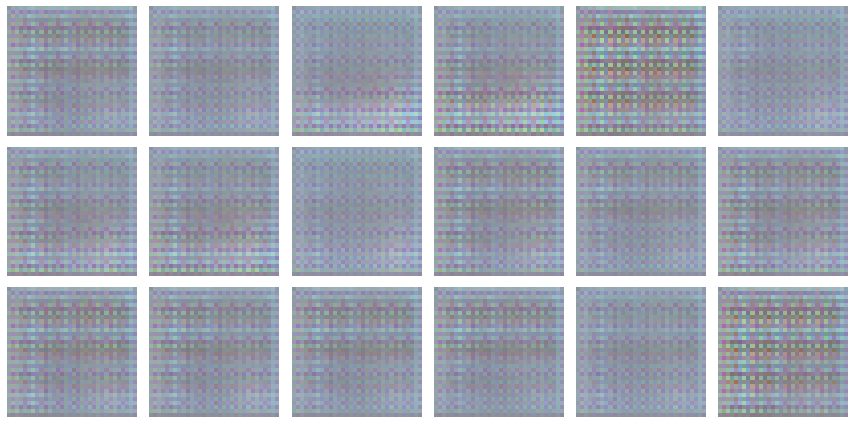

31/31 [==============================] - 253s 8s/step - g_loss: 2.5488 - d_loss: 0.3360 - real_acc: 0.8485 - gen_acc: 0.8871 - aug_p: 0.0040 - val_kid: 1.6770
Epoch 6/500
31/31 [==============================] - 247s 8s/step - g_loss: 2.5917 - d_loss: 0.4187 - real_acc: 0.8193 - gen_acc: 0.8755 - aug_p: 0.0041 - val_kid: 1.6522
Epoch 7/500
31/31 [==============================] - 231s 7s/step - g_loss: 2.0121 - d_loss: 0.4015 - real_acc: 0.8193 - gen_acc: 0.8674 - aug_p: 0.0026 - val_kid: 1.8216
Epoch 8/500
31/31 [==============================] - 241s 8s/step - g_loss: 2.5042 - d_loss: 0.2771 - real_acc: 0.8972 - gen_acc: 0.8934 - aug_p: 0.0029 - val_kid: 1.8537
Epoch 9/500
31/31 [==============================] - 245s 8s/step - g_loss: 2.3179 - d_loss: 0.4489 - real_acc: 0.8145 - gen_acc: 0.8402 - aug_p: 0.0030 - val_kid: 2.3149
Epoch 10/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0319 - d_loss: 0.4171 - real_acc: 0.8153 - gen_acc: 0.8453 - aug_p: 0.0021

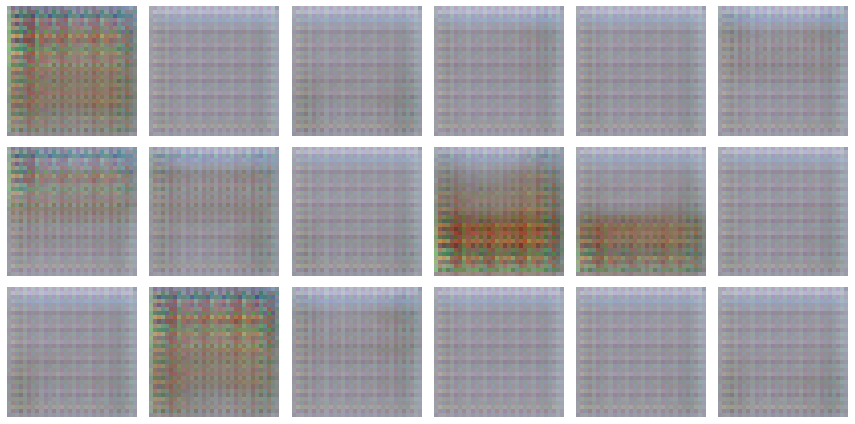

31/31 [==============================] - 258s 8s/step - g_loss: 2.0319 - d_loss: 0.4171 - real_acc: 0.8153 - gen_acc: 0.8453 - aug_p: 0.0021 - val_kid: 1.1144
Epoch 11/500
31/31 [==============================] - 238s 8s/step - g_loss: 2.2849 - d_loss: 0.3296 - real_acc: 0.8616 - gen_acc: 0.8954 - aug_p: 0.0018 - val_kid: 3.1635
Epoch 12/500
31/31 [==============================] - 253s 8s/step - g_loss: 1.6856 - d_loss: 0.3890 - real_acc: 0.8347 - gen_acc: 0.8372 - aug_p: 0.0018 - val_kid: 1.0407
Epoch 13/500
31/31 [==============================] - 239s 8s/step - g_loss: 2.0789 - d_loss: 0.3614 - real_acc: 0.8460 - gen_acc: 0.8531 - aug_p: 0.0017 - val_kid: 1.3253
Epoch 14/500
31/31 [==============================] - 255s 8s/step - g_loss: 3.0594 - d_loss: 0.2910 - real_acc: 0.8753 - gen_acc: 0.8737 - aug_p: 0.0016 - val_kid: 1.0240
Epoch 15/500
31/31 [==============================] - ETA: 0s - g_loss: 2.4496 - d_loss: 0.4205 - real_acc: 0.8254 - gen_acc: 0.8385 - aug_p: 0.0020

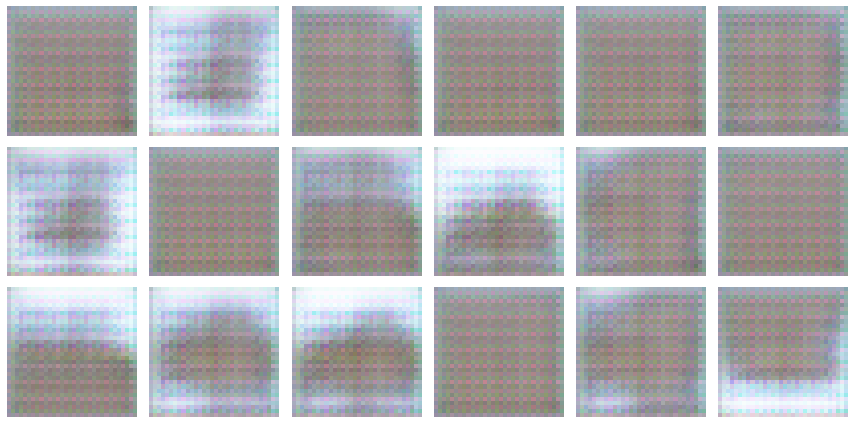

31/31 [==============================] - 255s 8s/step - g_loss: 2.4496 - d_loss: 0.4205 - real_acc: 0.8254 - gen_acc: 0.8385 - aug_p: 0.0020 - val_kid: 0.9025
Epoch 16/500
31/31 [==============================] - 247s 8s/step - g_loss: 2.2940 - d_loss: 0.2862 - real_acc: 0.9168 - gen_acc: 0.8914 - aug_p: 0.0025 - val_kid: 1.4136
Epoch 17/500
31/31 [==============================] - 243s 8s/step - g_loss: 2.5877 - d_loss: 0.4561 - real_acc: 0.7994 - gen_acc: 0.7999 - aug_p: 0.0030 - val_kid: 1.8849
Epoch 18/500
31/31 [==============================] - 250s 8s/step - g_loss: 2.0825 - d_loss: 0.4257 - real_acc: 0.8246 - gen_acc: 0.8317 - aug_p: 0.0017 - val_kid: 3.8143
Epoch 19/500
31/31 [==============================] - 237s 8s/step - g_loss: 2.3997 - d_loss: 0.2899 - real_acc: 0.8868 - gen_acc: 0.8889 - aug_p: 0.0013 - val_kid: 1.4972
Epoch 20/500
31/31 [==============================] - ETA: 0s - g_loss: 2.1893 - d_loss: 0.4594 - real_acc: 0.8432 - gen_acc: 0.8140 - aug_p: 0.0024

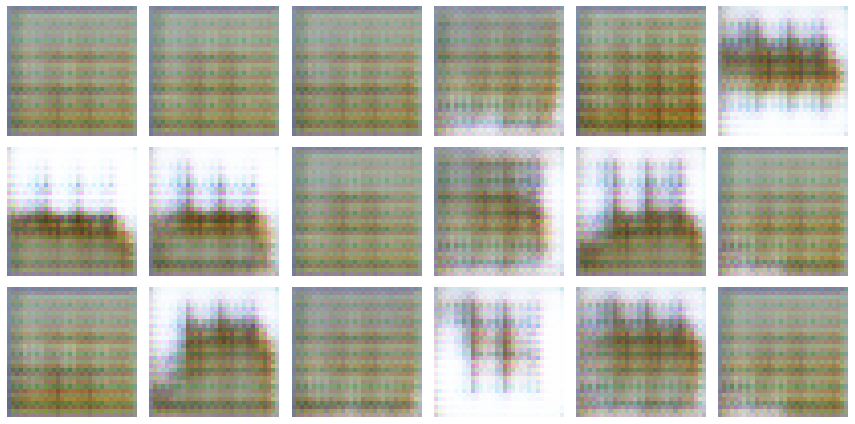

31/31 [==============================] - 254s 8s/step - g_loss: 2.1893 - d_loss: 0.4594 - real_acc: 0.8432 - gen_acc: 0.8140 - aug_p: 0.0024 - val_kid: 2.3489
Epoch 21/500
31/31 [==============================] - 235s 7s/step - g_loss: 1.7065 - d_loss: 0.4256 - real_acc: 0.7986 - gen_acc: 0.8238 - aug_p: 0.0016 - val_kid: 2.5322
Epoch 22/500
31/31 [==============================] - 238s 8s/step - g_loss: 2.1226 - d_loss: 0.4365 - real_acc: 0.8065 - gen_acc: 0.8087 - aug_p: 2.6033e-04 - val_kid: 0.9535
Epoch 23/500
31/31 [==============================] - 241s 8s/step - g_loss: 2.2613 - d_loss: 0.3394 - real_acc: 0.8735 - gen_acc: 0.8911 - aug_p: 5.9128e-04 - val_kid: 0.9122
Epoch 24/500
31/31 [==============================] - 241s 8s/step - g_loss: 2.2517 - d_loss: 0.3514 - real_acc: 0.8415 - gen_acc: 0.8599 - aug_p: 8.7611e-04 - val_kid: 0.9563
Epoch 25/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0308 - d_loss: 0.3802 - real_acc: 0.8458 - gen_acc: 0.8362 - aug_p:

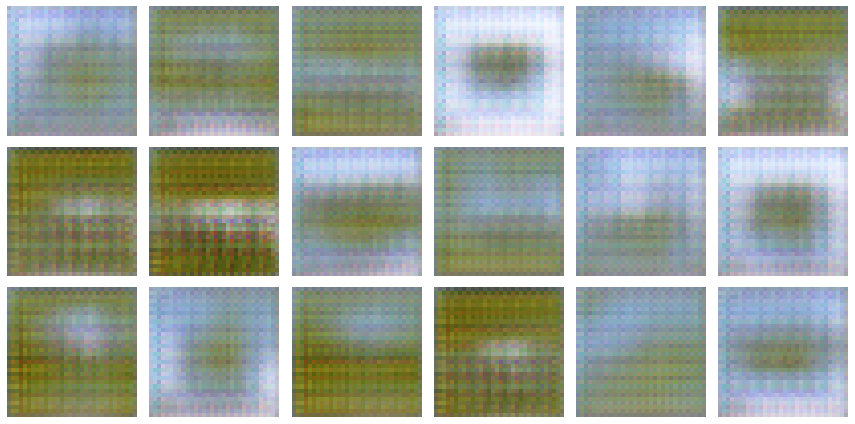

31/31 [==============================] - 253s 8s/step - g_loss: 2.0308 - d_loss: 0.3802 - real_acc: 0.8458 - gen_acc: 0.8362 - aug_p: 7.7837e-04 - val_kid: 1.0866
Epoch 26/500
31/31 [==============================] - 238s 8s/step - g_loss: 2.3348 - d_loss: 0.4320 - real_acc: 0.8105 - gen_acc: 0.8125 - aug_p: 3.2666e-04 - val_kid: 1.2725
Epoch 27/500
31/31 [==============================] - 245s 8s/step - g_loss: 2.4918 - d_loss: 0.3363 - real_acc: 0.8584 - gen_acc: 0.8803 - aug_p: 4.5983e-04 - val_kid: 1.6569
Epoch 28/500
31/31 [==============================] - 239s 8s/step - g_loss: 2.2765 - d_loss: 0.5089 - real_acc: 0.7697 - gen_acc: 0.7586 - aug_p: 1.5438e-04 - val_kid: 1.9117
Epoch 29/500
31/31 [==============================] - 245s 8s/step - g_loss: 1.7715 - d_loss: 0.4279 - real_acc: 0.8130 - gen_acc: 0.8014 - aug_p: 1.3533e-04 - val_kid: 1.8918
Epoch 30/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0983 - d_loss: 0.3316 - real_acc: 0.8654 - gen_acc: 0.8538 

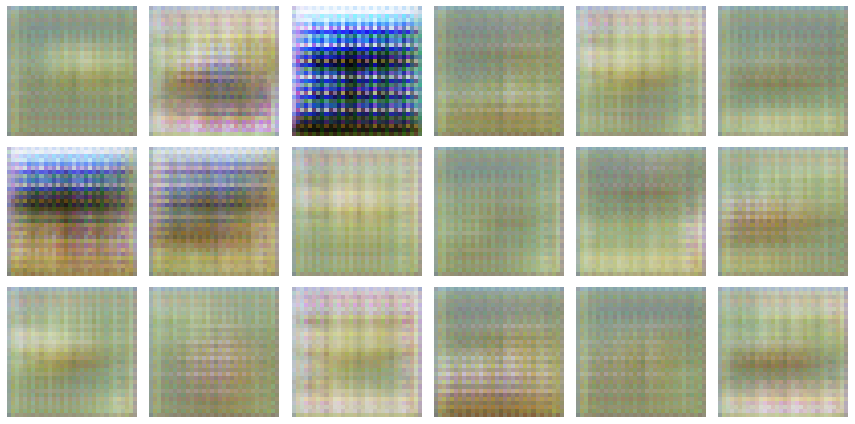

31/31 [==============================] - 248s 8s/step - g_loss: 2.0983 - d_loss: 0.3316 - real_acc: 0.8654 - gen_acc: 0.8538 - aug_p: 3.9597e-04 - val_kid: 2.4569
Epoch 31/500
31/31 [==============================] - 255s 8s/step - g_loss: 2.0004 - d_loss: 0.4261 - real_acc: 0.8213 - gen_acc: 0.8314 - aug_p: 4.8574e-04 - val_kid: 0.8240
Epoch 32/500
31/31 [==============================] - 250s 8s/step - g_loss: 2.0281 - d_loss: 0.3983 - real_acc: 0.8468 - gen_acc: 0.8438 - aug_p: 6.3024e-04 - val_kid: 0.7070
Epoch 33/500
31/31 [==============================] - 252s 8s/step - g_loss: 2.2921 - d_loss: 0.3475 - real_acc: 0.8526 - gen_acc: 0.8503 - aug_p: 2.6472e-04 - val_kid: 0.5220
Epoch 34/500
31/31 [==============================] - 242s 8s/step - g_loss: 2.1814 - d_loss: 0.4508 - real_acc: 0.7959 - gen_acc: 0.8349 - aug_p: 2.7283e-04 - val_kid: 0.6260
Epoch 35/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0336 - d_loss: 0.4694 - real_acc: 0.8213 - gen_acc: 0.8374 

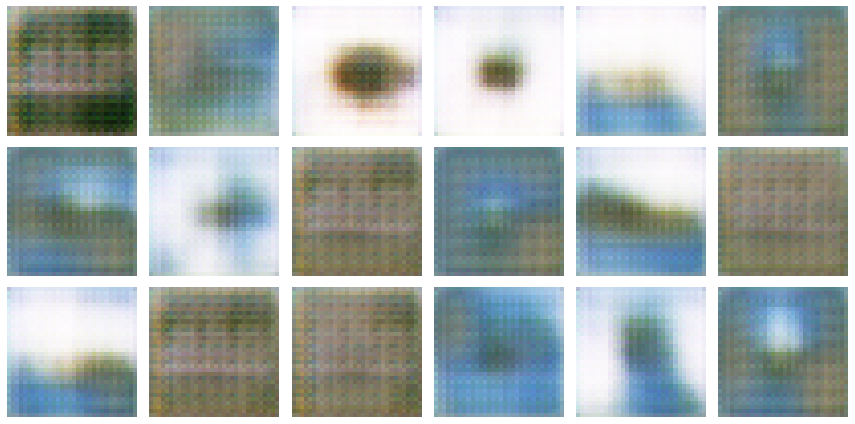

31/31 [==============================] - 254s 8s/step - g_loss: 2.0336 - d_loss: 0.4694 - real_acc: 0.8213 - gen_acc: 0.8374 - aug_p: 2.9103e-04 - val_kid: 0.7189
Epoch 36/500
31/31 [==============================] - 252s 8s/step - g_loss: 1.9554 - d_loss: 0.3559 - real_acc: 0.8599 - gen_acc: 0.8516 - aug_p: 5.0514e-04 - val_kid: 0.4930
Epoch 37/500
31/31 [==============================] - 258s 8s/step - g_loss: 2.1514 - d_loss: 0.3625 - real_acc: 0.8490 - gen_acc: 0.8402 - aug_p: 4.9032e-04 - val_kid: 0.4201
Epoch 38/500
31/31 [==============================] - 238s 8s/step - g_loss: 1.9226 - d_loss: 0.4089 - real_acc: 0.8203 - gen_acc: 0.8100 - aug_p: 2.5060e-04 - val_kid: 0.8370
Epoch 39/500
31/31 [==============================] - 254s 8s/step - g_loss: 2.4323 - d_loss: 0.3850 - real_acc: 0.8332 - gen_acc: 0.8246 - aug_p: 1.7797e-04 - val_kid: 0.8872
Epoch 40/500
31/31 [==============================] - ETA: 0s - g_loss: 2.7992 - d_loss: 0.3299 - real_acc: 0.8710 - gen_acc: 0.8591 

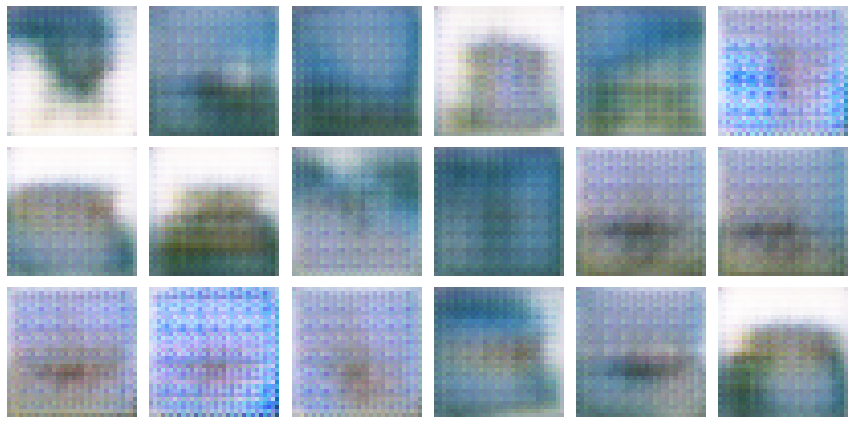

31/31 [==============================] - 252s 8s/step - g_loss: 2.7992 - d_loss: 0.3299 - real_acc: 0.8710 - gen_acc: 0.8591 - aug_p: 6.4516e-04 - val_kid: 0.8168
Epoch 41/500
31/31 [==============================] - 247s 8s/step - g_loss: 2.1123 - d_loss: 0.4742 - real_acc: 0.7805 - gen_acc: 0.7916 - aug_p: 4.8453e-04 - val_kid: 1.2048
Epoch 42/500
31/31 [==============================] - 240s 8s/step - g_loss: 2.1026 - d_loss: 0.4003 - real_acc: 0.8251 - gen_acc: 0.8211 - aug_p: 2.2319e-04 - val_kid: 0.7162
Epoch 43/500
31/31 [==============================] - 242s 8s/step - g_loss: 2.1323 - d_loss: 0.3926 - real_acc: 0.8276 - gen_acc: 0.8261 - aug_p: 1.1371e-04 - val_kid: 0.8191
Epoch 44/500
31/31 [==============================] - 237s 8s/step - g_loss: 2.0896 - d_loss: 0.3789 - real_acc: 0.8438 - gen_acc: 0.8324 - aug_p: 3.4939e-04 - val_kid: 0.7610
Epoch 45/500
31/31 [==============================] - ETA: 0s - g_loss: 2.1308 - d_loss: 0.3642 - real_acc: 0.8556 - gen_acc: 0.8314 

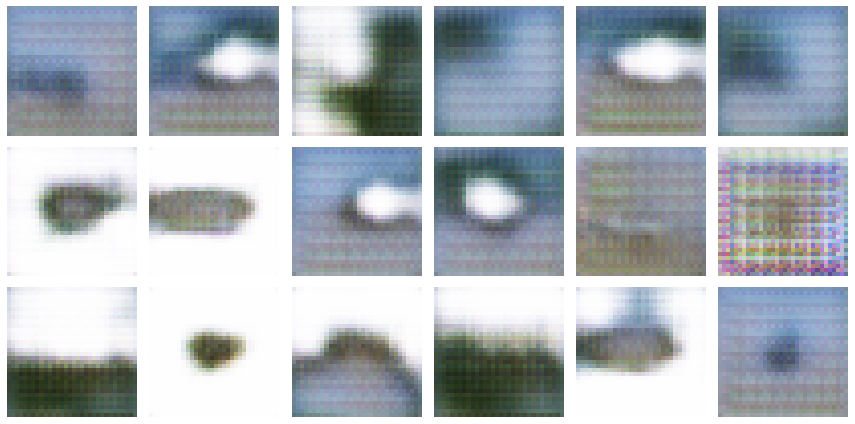

31/31 [==============================] - 253s 8s/step - g_loss: 2.1308 - d_loss: 0.3642 - real_acc: 0.8556 - gen_acc: 0.8314 - aug_p: 4.0181e-04 - val_kid: 0.5667
Epoch 46/500
31/31 [==============================] - 239s 8s/step - g_loss: 2.2381 - d_loss: 0.3720 - real_acc: 0.8553 - gen_acc: 0.8443 - aug_p: 9.0363e-04 - val_kid: 0.4874
Epoch 47/500
31/31 [==============================] - 245s 8s/step - g_loss: 2.2185 - d_loss: 0.3515 - real_acc: 0.8584 - gen_acc: 0.8528 - aug_p: 6.3452e-04 - val_kid: 0.4902
Epoch 48/500
31/31 [==============================] - 242s 8s/step - g_loss: 1.9174 - d_loss: 0.4169 - real_acc: 0.8397 - gen_acc: 0.8256 - aug_p: 3.8886e-04 - val_kid: 0.5437
Epoch 49/500
31/31 [==============================] - 255s 8s/step - g_loss: 2.3475 - d_loss: 0.3803 - real_acc: 0.8354 - gen_acc: 0.8284 - aug_p: 3.5015e-04 - val_kid: 0.3511
Epoch 50/500
31/31 [==============================] - ETA: 0s - g_loss: 2.2183 - d_loss: 0.4117 - real_acc: 0.8196 - gen_acc: 0.8057 

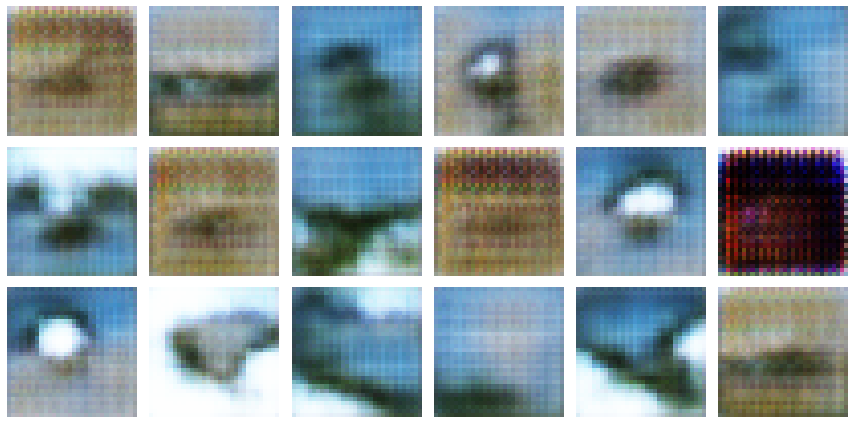

31/31 [==============================] - 254s 8s/step - g_loss: 2.2183 - d_loss: 0.4117 - real_acc: 0.8196 - gen_acc: 0.8057 - aug_p: 1.8523e-04 - val_kid: 0.3224
Epoch 51/500
31/31 [==============================] - 251s 8s/step - g_loss: 1.8276 - d_loss: 0.4472 - real_acc: 0.8054 - gen_acc: 0.8075 - aug_p: 1.5464e-04 - val_kid: 0.3284
Epoch 52/500
31/31 [==============================] - 244s 8s/step - g_loss: 1.8370 - d_loss: 0.4675 - real_acc: 0.7760 - gen_acc: 0.7994 - aug_p: 5.4939e-05 - val_kid: 0.3253
Epoch 53/500
31/31 [==============================] - 257s 8s/step - g_loss: 1.8369 - d_loss: 0.4262 - real_acc: 0.8183 - gen_acc: 0.8080 - aug_p: 1.2213e-04 - val_kid: 0.3167
Epoch 54/500
31/31 [==============================] - 256s 8s/step - g_loss: 1.7561 - d_loss: 0.3886 - real_acc: 0.8319 - gen_acc: 0.8367 - aug_p: 1.4909e-04 - val_kid: 0.2981
Epoch 55/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9836 - d_loss: 0.4186 - real_acc: 0.8150 - gen_acc: 0.8163 

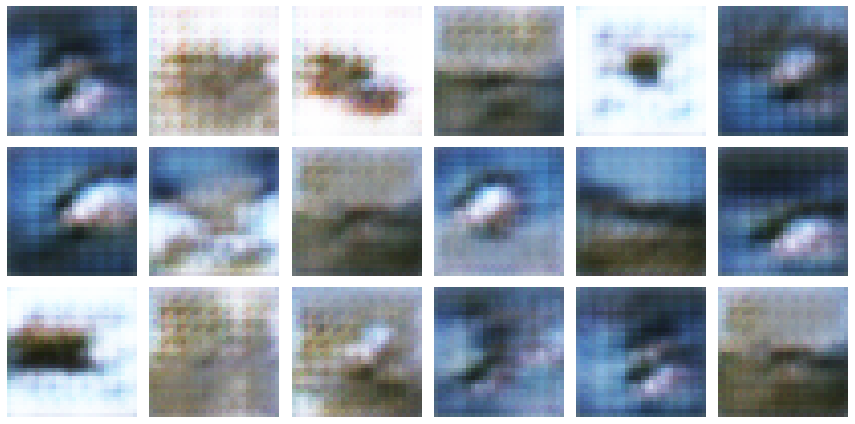

31/31 [==============================] - 258s 8s/step - g_loss: 1.9836 - d_loss: 0.4186 - real_acc: 0.8150 - gen_acc: 0.8163 - aug_p: 1.0655e-04 - val_kid: 0.3054
Epoch 56/500
31/31 [==============================] - 178s 6s/step - g_loss: 1.8783 - d_loss: 0.4254 - real_acc: 0.8062 - gen_acc: 0.8080 - aug_p: 8.1804e-05 - val_kid: 0.2944
Epoch 57/500
31/31 [==============================] - 179s 6s/step - g_loss: 2.1156 - d_loss: 0.4006 - real_acc: 0.8377 - gen_acc: 0.8196 - aug_p: 1.7545e-04 - val_kid: 0.2979
Epoch 58/500
31/31 [==============================] - 176s 6s/step - g_loss: 2.0031 - d_loss: 0.4464 - real_acc: 0.8024 - gen_acc: 0.7966 - aug_p: 2.8866e-04 - val_kid: 0.2904
Epoch 59/500
31/31 [==============================] - 188s 6s/step - g_loss: 1.8146 - d_loss: 0.4390 - real_acc: 0.8019 - gen_acc: 0.7954 - aug_p: 1.0227e-04 - val_kid: 0.2785
Epoch 60/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8053 - d_loss: 0.4915 - real_acc: 0.7939 - gen_acc: 0.7686 

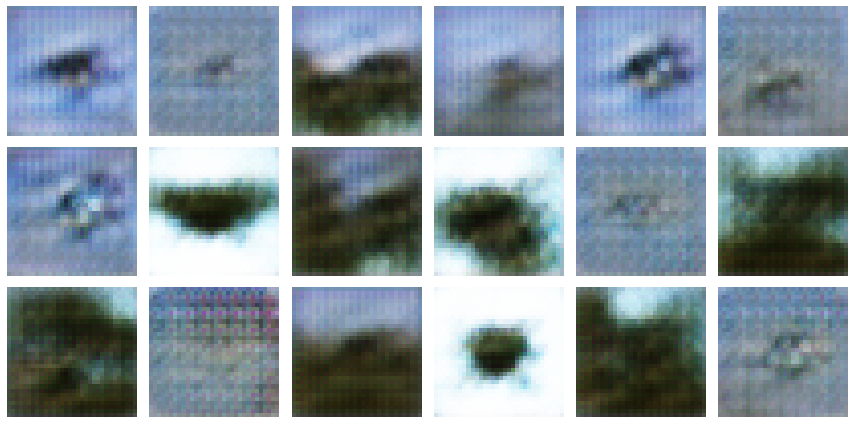

31/31 [==============================] - 181s 6s/step - g_loss: 1.8053 - d_loss: 0.4915 - real_acc: 0.7939 - gen_acc: 0.7686 - aug_p: 1.8493e-04 - val_kid: 0.3038
Epoch 61/500
31/31 [==============================] - 177s 6s/step - g_loss: 1.9879 - d_loss: 0.4153 - real_acc: 0.8090 - gen_acc: 0.8322 - aug_p: 1.4173e-04 - val_kid: 0.3289
Epoch 62/500
31/31 [==============================] - 182s 6s/step - g_loss: 1.9637 - d_loss: 0.3879 - real_acc: 0.8508 - gen_acc: 0.8372 - aug_p: 2.2989e-04 - val_kid: 0.3009
Epoch 63/500
31/31 [==============================] - 179s 6s/step - g_loss: 2.0313 - d_loss: 0.4120 - real_acc: 0.8296 - gen_acc: 0.8352 - aug_p: 2.7969e-04 - val_kid: 0.2902
Epoch 64/500
31/31 [==============================] - 172s 5s/step - g_loss: 1.8599 - d_loss: 0.4293 - real_acc: 0.8090 - gen_acc: 0.7931 - aug_p: 1.1053e-04 - val_kid: 0.3086
Epoch 65/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8700 - d_loss: 0.4915 - real_acc: 0.7956 - gen_acc: 0.7603 

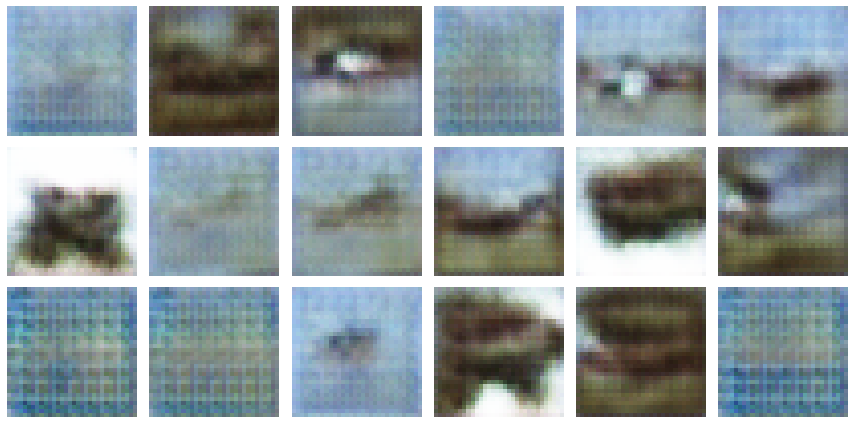

31/31 [==============================] - 177s 6s/step - g_loss: 1.8700 - d_loss: 0.4915 - real_acc: 0.7956 - gen_acc: 0.7603 - aug_p: 1.5126e-04 - val_kid: 0.2808
Epoch 66/500
31/31 [==============================] - 171s 5s/step - g_loss: 2.3727 - d_loss: 0.3251 - real_acc: 0.8639 - gen_acc: 0.8926 - aug_p: 6.3458e-04 - val_kid: 0.2601
Epoch 67/500
31/31 [==============================] - 170s 5s/step - g_loss: 2.0817 - d_loss: 0.3458 - real_acc: 0.8478 - gen_acc: 0.8637 - aug_p: 8.1502e-04 - val_kid: 0.2679
Epoch 68/500
31/31 [==============================] - 167s 5s/step - g_loss: 2.3348 - d_loss: 0.3954 - real_acc: 0.8342 - gen_acc: 0.8233 - aug_p: 6.1109e-04 - val_kid: 0.2638
Epoch 69/500
31/31 [==============================] - 168s 5s/step - g_loss: 2.0963 - d_loss: 0.3650 - real_acc: 0.8523 - gen_acc: 0.8364 - aug_p: 6.6053e-04 - val_kid: 0.3007
Epoch 70/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9127 - d_loss: 0.4480 - real_acc: 0.8092 - gen_acc: 0.7913 

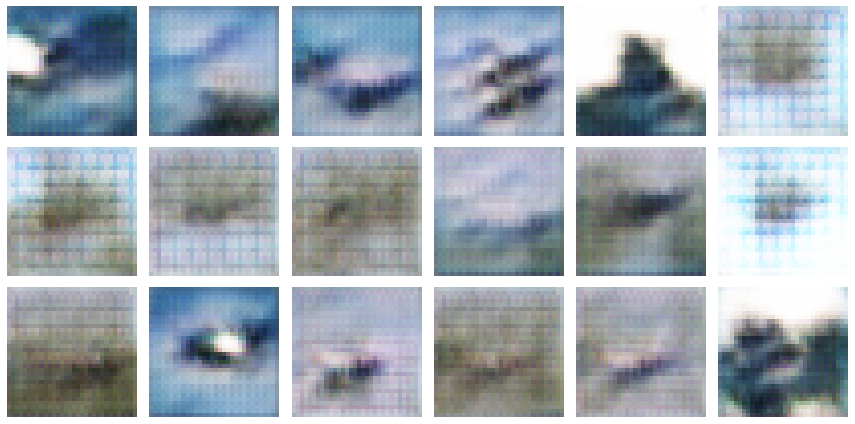

31/31 [==============================] - 170s 5s/step - g_loss: 1.9127 - d_loss: 0.4480 - real_acc: 0.8092 - gen_acc: 0.7913 - aug_p: 2.7208e-04 - val_kid: 0.3642
Epoch 71/500
31/31 [==============================] - 169s 5s/step - g_loss: 2.0372 - d_loss: 0.4649 - real_acc: 0.8022 - gen_acc: 0.7812 - aug_p: 1.6124e-04 - val_kid: 0.2845
Epoch 72/500
31/31 [==============================] - 169s 5s/step - g_loss: 1.6348 - d_loss: 0.4433 - real_acc: 0.8019 - gen_acc: 0.8138 - aug_p: 5.8014e-05 - val_kid: 0.2848
Epoch 73/500
31/31 [==============================] - 168s 5s/step - g_loss: 1.7629 - d_loss: 0.4601 - real_acc: 0.7873 - gen_acc: 0.7795 - aug_p: 1.2303e-04 - val_kid: 0.2911
Epoch 74/500
31/31 [==============================] - 107s 3s/step - g_loss: 1.8881 - d_loss: 0.3728 - real_acc: 0.8400 - gen_acc: 0.8521 - aug_p: 1.9289e-04 - val_kid: 0.2926
Epoch 75/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0217 - d_loss: 0.3852 - real_acc: 0.8317 - gen_acc: 0.8397 

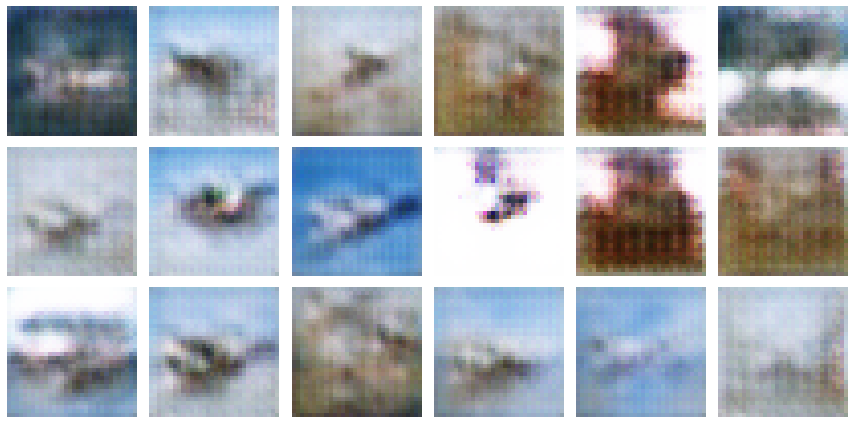

31/31 [==============================] - 105s 3s/step - g_loss: 2.0217 - d_loss: 0.3852 - real_acc: 0.8317 - gen_acc: 0.8397 - aug_p: 1.6467e-04 - val_kid: 0.2928
Epoch 76/500
31/31 [==============================] - 98s 3s/step - g_loss: 2.0116 - d_loss: 0.4106 - real_acc: 0.8223 - gen_acc: 0.8296 - aug_p: 2.5000e-04 - val_kid: 0.3168
Epoch 77/500
31/31 [==============================] - 92s 3s/step - g_loss: 1.8014 - d_loss: 0.4696 - real_acc: 0.8047 - gen_acc: 0.7598 - aug_p: 1.4536e-04 - val_kid: 0.3326
Epoch 78/500
31/31 [==============================] - 92s 3s/step - g_loss: 1.8635 - d_loss: 0.4455 - real_acc: 0.7966 - gen_acc: 0.7956 - aug_p: 7.4496e-05 - val_kid: 0.3197
Epoch 79/500
31/31 [==============================] - 91s 3s/step - g_loss: 1.8475 - d_loss: 0.4854 - real_acc: 0.7729 - gen_acc: 0.7792 - aug_p: 7.7419e-05 - val_kid: 0.3014
Epoch 80/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9966 - d_loss: 0.3917 - real_acc: 0.8347 - gen_acc: 0.8213 - au

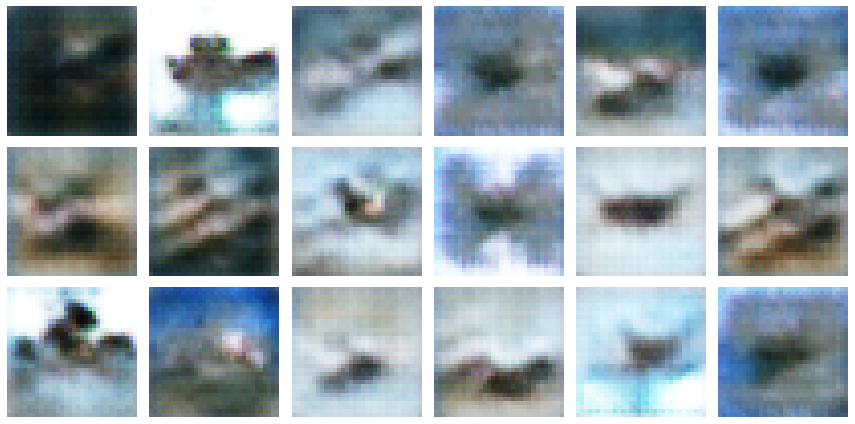

31/31 [==============================] - 92s 3s/step - g_loss: 1.9966 - d_loss: 0.3917 - real_acc: 0.8347 - gen_acc: 0.8213 - aug_p: 1.5000e-04 - val_kid: 0.3227
Epoch 81/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.9122 - d_loss: 0.4215 - real_acc: 0.8216 - gen_acc: 0.8059 - aug_p: 1.3574e-04 - val_kid: 0.2998
Epoch 82/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.7917 - d_loss: 0.4667 - real_acc: 0.7946 - gen_acc: 0.7775 - aug_p: 1.4289e-04 - val_kid: 0.2953
Epoch 83/500
31/31 [==============================] - 91s 3s/step - g_loss: 2.0921 - d_loss: 0.3854 - real_acc: 0.8377 - gen_acc: 0.8432 - aug_p: 2.3896e-04 - val_kid: 0.2966
Epoch 84/500
31/31 [==============================] - 91s 3s/step - g_loss: 1.7116 - d_loss: 0.4970 - real_acc: 0.7870 - gen_acc: 0.7838 - aug_p: 8.8609e-05 - val_kid: 0.3010
Epoch 85/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9352 - d_loss: 0.4273 - real_acc: 0.8279 - gen_acc: 0.8128 - aug

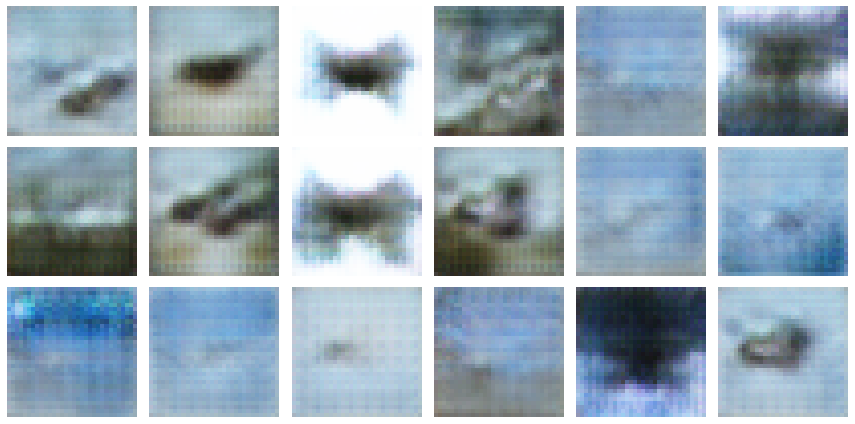

31/31 [==============================] - 91s 3s/step - g_loss: 1.9352 - d_loss: 0.4273 - real_acc: 0.8279 - gen_acc: 0.8128 - aug_p: 2.3952e-04 - val_kid: 0.3085
Epoch 86/500
31/31 [==============================] - 92s 3s/step - g_loss: 1.9691 - d_loss: 0.4096 - real_acc: 0.8110 - gen_acc: 0.8286 - aug_p: 3.1149e-04 - val_kid: 0.3124
Epoch 87/500
31/31 [==============================] - 91s 3s/step - g_loss: 2.0723 - d_loss: 0.4355 - real_acc: 0.8168 - gen_acc: 0.7833 - aug_p: 8.4375e-05 - val_kid: 0.3055
Epoch 88/500
31/31 [==============================] - 91s 3s/step - g_loss: 1.9931 - d_loss: 0.3613 - real_acc: 0.8556 - gen_acc: 0.8513 - aug_p: 3.0615e-04 - val_kid: 0.2800
Epoch 89/500
31/31 [==============================] - 90s 3s/step - g_loss: 2.0459 - d_loss: 0.4310 - real_acc: 0.7991 - gen_acc: 0.8075 - aug_p: 1.9093e-04 - val_kid: 0.2734
Epoch 90/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9562 - d_loss: 0.4493 - real_acc: 0.8105 - gen_acc: 0.7697 - aug

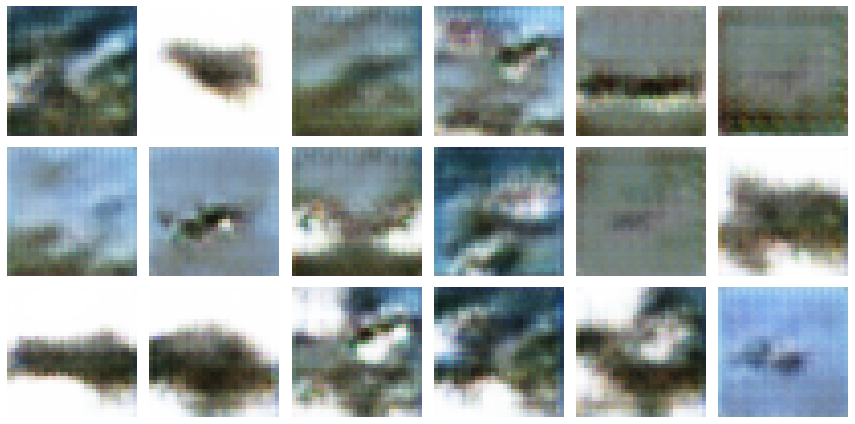

31/31 [==============================] - 92s 3s/step - g_loss: 1.9562 - d_loss: 0.4493 - real_acc: 0.8105 - gen_acc: 0.7697 - aug_p: 1.6351e-04 - val_kid: 0.2740
Epoch 91/500
31/31 [==============================] - 92s 3s/step - g_loss: 1.7689 - d_loss: 0.4141 - real_acc: 0.8175 - gen_acc: 0.8090 - aug_p: 1.5726e-04 - val_kid: 0.2729
Epoch 92/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.9517 - d_loss: 0.4439 - real_acc: 0.8077 - gen_acc: 0.7818 - aug_p: 4.2540e-05 - val_kid: 0.2609
Epoch 93/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.8842 - d_loss: 0.4040 - real_acc: 0.8322 - gen_acc: 0.8216 - aug_p: 1.8115e-04 - val_kid: 0.2739
Epoch 94/500
31/31 [==============================] - 92s 3s/step - g_loss: 2.0216 - d_loss: 0.4115 - real_acc: 0.8140 - gen_acc: 0.8080 - aug_p: 1.1472e-04 - val_kid: 0.2568
Epoch 95/500
31/31 [==============================] - ETA: 0s - g_loss: 1.6085 - d_loss: 0.4917 - real_acc: 0.7785 - gen_acc: 0.7644 - aug

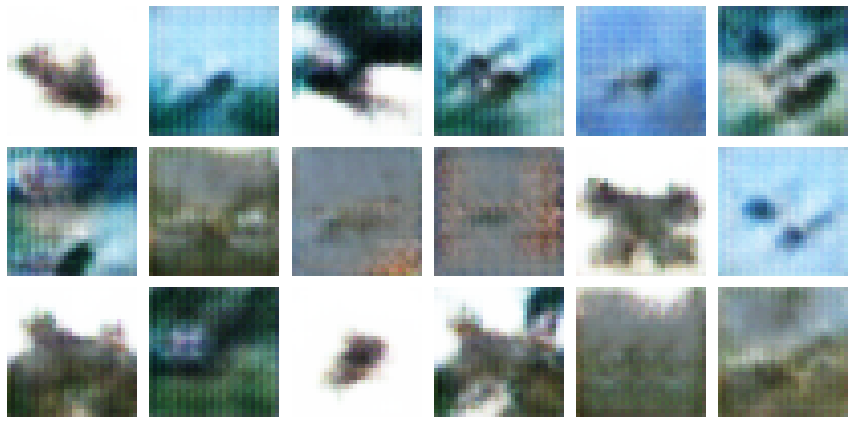

31/31 [==============================] - 91s 3s/step - g_loss: 1.6085 - d_loss: 0.4917 - real_acc: 0.7785 - gen_acc: 0.7644 - aug_p: 1.1769e-04 - val_kid: 0.2671
Epoch 96/500
31/31 [==============================] - 91s 3s/step - g_loss: 1.7491 - d_loss: 0.4443 - real_acc: 0.8022 - gen_acc: 0.8014 - aug_p: 5.4486e-05 - val_kid: 0.2575
Epoch 97/500
31/31 [==============================] - 91s 3s/step - g_loss: 2.1147 - d_loss: 0.4113 - real_acc: 0.8264 - gen_acc: 0.8115 - aug_p: 1.5030e-04 - val_kid: 0.2562
Epoch 98/500
31/31 [==============================] - 91s 3s/step - g_loss: 1.8117 - d_loss: 0.4233 - real_acc: 0.8203 - gen_acc: 0.8115 - aug_p: 9.8286e-05 - val_kid: 0.2513
Epoch 99/500
31/31 [==============================] - 92s 3s/step - g_loss: 1.8049 - d_loss: 0.4439 - real_acc: 0.7921 - gen_acc: 0.8049 - aug_p: 7.9385e-05 - val_kid: 0.2388
Epoch 100/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8045 - d_loss: 0.4218 - real_acc: 0.8218 - gen_acc: 0.7949 - au

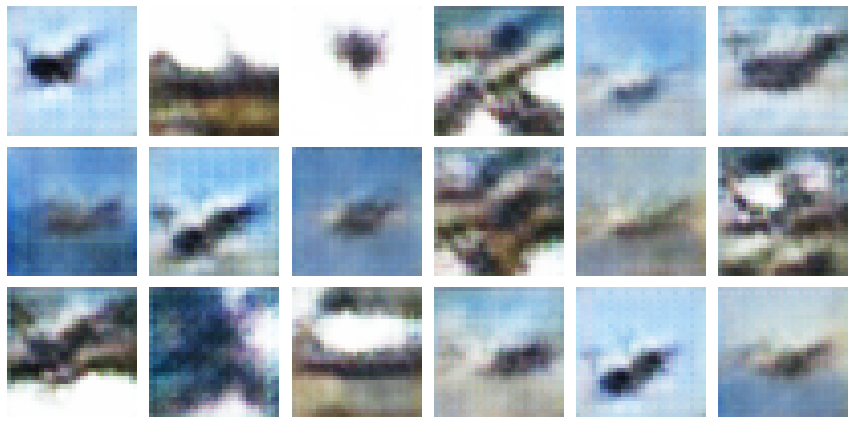

31/31 [==============================] - 92s 3s/step - g_loss: 1.8045 - d_loss: 0.4218 - real_acc: 0.8218 - gen_acc: 0.7949 - aug_p: 1.2218e-04 - val_kid: 0.2387
Epoch 101/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.5245 - d_loss: 0.5320 - real_acc: 0.7520 - gen_acc: 0.7288 - aug_p: 3.3972e-05 - val_kid: 0.2333
Epoch 102/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.6638 - d_loss: 0.4875 - real_acc: 0.7807 - gen_acc: 0.7681 - aug_p: 4.6976e-05 - val_kid: 0.2380
Epoch 103/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.8033 - d_loss: 0.4985 - real_acc: 0.7583 - gen_acc: 0.7591 - aug_p: 3.6542e-05 - val_kid: 0.2453
Epoch 104/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.8069 - d_loss: 0.3906 - real_acc: 0.8352 - gen_acc: 0.8443 - aug_p: 1.4975e-04 - val_kid: 0.2559
Epoch 105/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0204 - d_loss: 0.4034 - real_acc: 0.8266 - gen_acc: 0.8223 

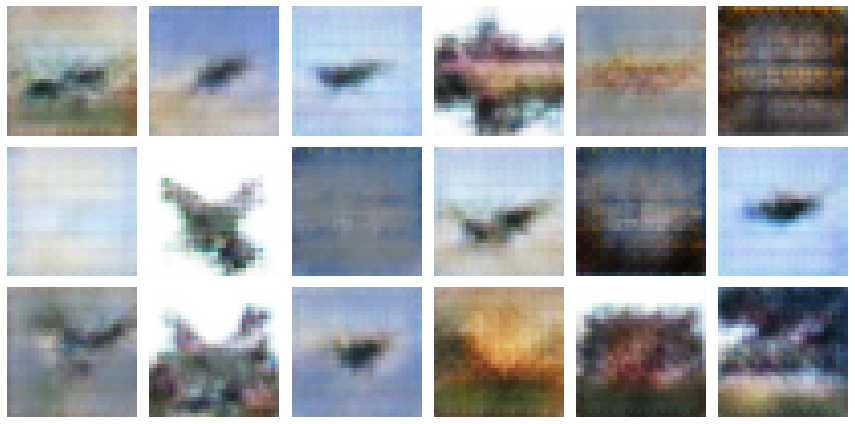

31/31 [==============================] - 91s 3s/step - g_loss: 2.0204 - d_loss: 0.4034 - real_acc: 0.8266 - gen_acc: 0.8223 - aug_p: 1.4965e-04 - val_kid: 0.2547
Epoch 106/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.7936 - d_loss: 0.4025 - real_acc: 0.8395 - gen_acc: 0.8133 - aug_p: 2.3579e-04 - val_kid: 0.2477
Epoch 107/500
31/31 [==============================] - 90s 3s/step - g_loss: 2.0121 - d_loss: 0.4448 - real_acc: 0.7931 - gen_acc: 0.7966 - aug_p: 1.0741e-04 - val_kid: 0.2518
Epoch 108/500
31/31 [==============================] - 89s 3s/step - g_loss: 1.8957 - d_loss: 0.4077 - real_acc: 0.8319 - gen_acc: 0.7991 - aug_p: 1.4526e-04 - val_kid: 0.2465
Epoch 109/500
31/31 [==============================] - 89s 3s/step - g_loss: 1.8993 - d_loss: 0.4019 - real_acc: 0.8289 - gen_acc: 0.8226 - aug_p: 1.5544e-04 - val_kid: 0.2560
Epoch 110/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8195 - d_loss: 0.4606 - real_acc: 0.7928 - gen_acc: 0.7739 

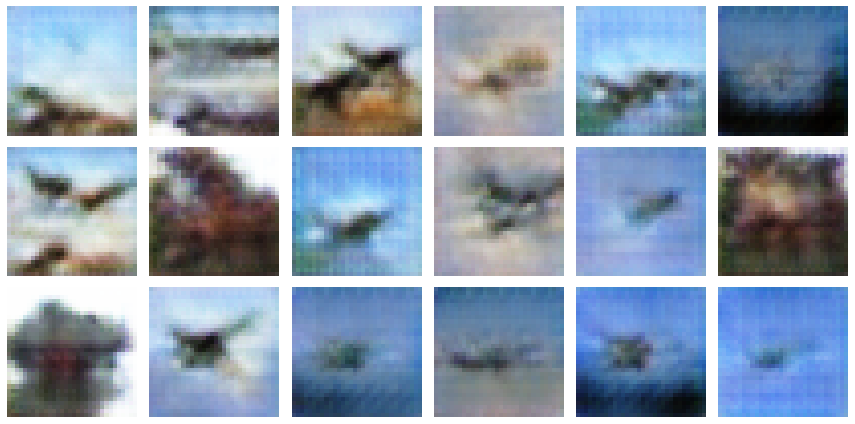

31/31 [==============================] - 91s 3s/step - g_loss: 1.8195 - d_loss: 0.4606 - real_acc: 0.7928 - gen_acc: 0.7739 - aug_p: 9.4052e-05 - val_kid: 0.2539
Epoch 111/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.7950 - d_loss: 0.4720 - real_acc: 0.7903 - gen_acc: 0.7853 - aug_p: 7.5605e-05 - val_kid: 0.2450
Epoch 112/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.7222 - d_loss: 0.4583 - real_acc: 0.8032 - gen_acc: 0.7868 - aug_p: 1.0227e-04 - val_kid: 0.2370
Epoch 113/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.6657 - d_loss: 0.4686 - real_acc: 0.7757 - gen_acc: 0.7931 - aug_p: 3.1855e-05 - val_kid: 0.2344
Epoch 114/500
31/31 [==============================] - 90s 3s/step - g_loss: 1.9136 - d_loss: 0.4523 - real_acc: 0.7951 - gen_acc: 0.7926 - aug_p: 5.3276e-05 - val_kid: 0.2385
Epoch 115/500
31/31 [==============================] - ETA: 0s - g_loss: 1.7713 - d_loss: 0.4216 - real_acc: 0.8178 - gen_acc: 0.7939 

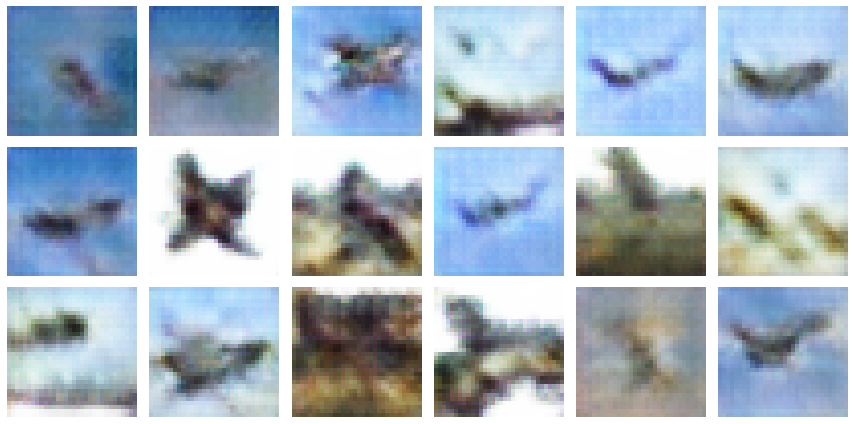

31/31 [==============================] - 94s 3s/step - g_loss: 1.7713 - d_loss: 0.4216 - real_acc: 0.8178 - gen_acc: 0.7939 - aug_p: 1.1457e-04 - val_kid: 0.2444
Epoch 116/500
31/31 [==============================] - 94s 3s/step - g_loss: 1.6519 - d_loss: 0.4653 - real_acc: 0.7805 - gen_acc: 0.7969 - aug_p: 5.5998e-05 - val_kid: 0.2445
Epoch 117/500
31/31 [==============================] - 93s 3s/step - g_loss: 1.8182 - d_loss: 0.4499 - real_acc: 0.8067 - gen_acc: 0.7840 - aug_p: 7.1119e-05 - val_kid: 0.2384
Epoch 118/500
31/31 [==============================] - 94s 3s/step - g_loss: 1.6233 - d_loss: 0.4856 - real_acc: 0.7719 - gen_acc: 0.7596 - aug_p: 3.2258e-05 - val_kid: 0.2273
Epoch 119/500
31/31 [==============================] - 92s 3s/step - g_loss: 1.6720 - d_loss: 0.4107 - real_acc: 0.8145 - gen_acc: 0.8266 - aug_p: 3.7702e-05 - val_kid: 0.2291
Epoch 120/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8811 - d_loss: 0.4178 - real_acc: 0.8125 - gen_acc: 0.8120 

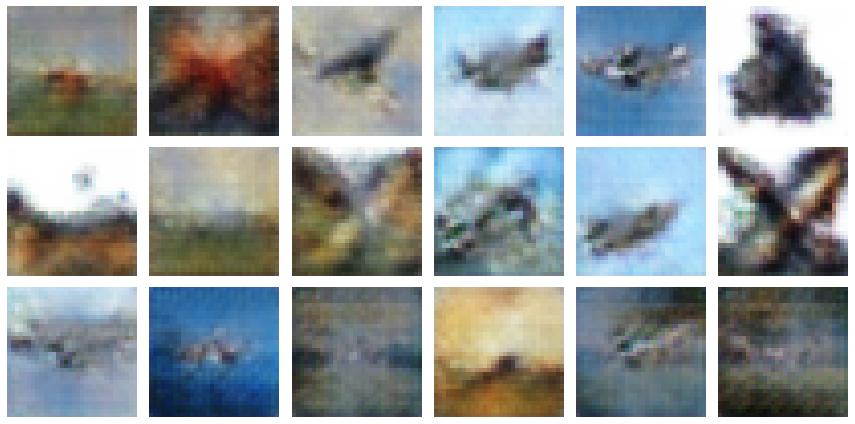

31/31 [==============================] - 97s 3s/step - g_loss: 1.8811 - d_loss: 0.4178 - real_acc: 0.8125 - gen_acc: 0.8120 - aug_p: 8.9970e-05 - val_kid: 0.2264
Epoch 121/500
31/31 [==============================] - 95s 3s/step - g_loss: 1.7055 - d_loss: 0.4252 - real_acc: 0.8221 - gen_acc: 0.7939 - aug_p: 9.5464e-05 - val_kid: 0.2253
Epoch 122/500
31/31 [==============================] - 103s 3s/step - g_loss: 1.7606 - d_loss: 0.4476 - real_acc: 0.7946 - gen_acc: 0.7969 - aug_p: 6.1542e-05 - val_kid: 0.2222
Epoch 123/500
31/31 [==============================] - 101s 3s/step - g_loss: 1.6945 - d_loss: 0.4773 - real_acc: 0.7896 - gen_acc: 0.7775 - aug_p: 7.0867e-05 - val_kid: 0.2205
Epoch 124/500
31/31 [==============================] - 103s 3s/step - g_loss: 1.7831 - d_loss: 0.4339 - real_acc: 0.8097 - gen_acc: 0.7901 - aug_p: 1.4864e-04 - val_kid: 0.2237
Epoch 125/500
31/31 [==============================] - ETA: 0s - g_loss: 1.7414 - d_loss: 0.4814 - real_acc: 0.7870 - gen_acc: 0.76

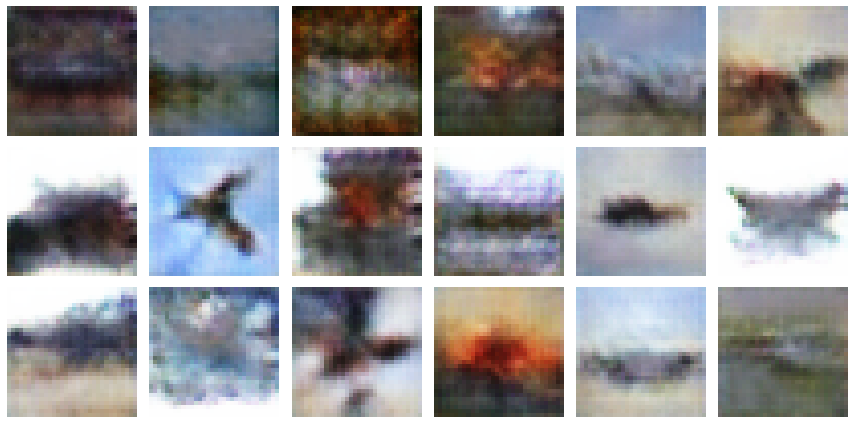

31/31 [==============================] - 109s 4s/step - g_loss: 1.7414 - d_loss: 0.4814 - real_acc: 0.7870 - gen_acc: 0.7626 - aug_p: 6.2248e-05 - val_kid: 0.2196
Epoch 126/500
31/31 [==============================] - 118s 4s/step - g_loss: 1.7697 - d_loss: 0.4949 - real_acc: 0.7785 - gen_acc: 0.7339 - aug_p: 9.0877e-05 - val_kid: 0.2293
Epoch 127/500
31/31 [==============================] - 207s 7s/step - g_loss: 1.5403 - d_loss: 0.4731 - real_acc: 0.7747 - gen_acc: 0.7671 - aug_p: 3.1502e-05 - val_kid: 0.2369
Epoch 128/500
31/31 [==============================] - 3893s 129s/step - g_loss: 1.7421 - d_loss: 0.4393 - real_acc: 0.8100 - gen_acc: 0.7858 - aug_p: 4.4405e-05 - val_kid: 0.2273
Epoch 129/500
31/31 [==============================] - 210s 7s/step - g_loss: 1.9089 - d_loss: 0.4380 - real_acc: 0.8027 - gen_acc: 0.7936 - aug_p: 8.8508e-05 - val_kid: 0.2209
Epoch 130/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9810 - d_loss: 0.4313 - real_acc: 0.8107 - gen_acc:

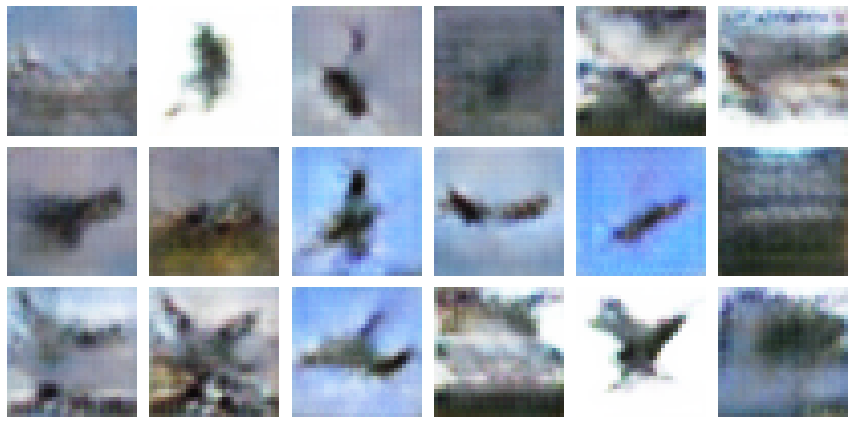

31/31 [==============================] - 231s 7s/step - g_loss: 1.9810 - d_loss: 0.4313 - real_acc: 0.8107 - gen_acc: 0.7906 - aug_p: 2.2918e-04 - val_kid: 0.2208
Epoch 131/500
31/31 [==============================] - 211s 7s/step - g_loss: 1.6619 - d_loss: 0.4781 - real_acc: 0.7860 - gen_acc: 0.7757 - aug_p: 5.5494e-05 - val_kid: 0.2110
Epoch 132/500
31/31 [==============================] - 239s 8s/step - g_loss: 1.7688 - d_loss: 0.4243 - real_acc: 0.8110 - gen_acc: 0.8097 - aug_p: 4.7429e-05 - val_kid: 0.2058
Epoch 133/500
31/31 [==============================] - 233s 7s/step - g_loss: 1.8265 - d_loss: 0.4307 - real_acc: 0.8155 - gen_acc: 0.8125 - aug_p: 9.6169e-05 - val_kid: 0.2050
Epoch 134/500
31/31 [==============================] - 250s 8s/step - g_loss: 1.9008 - d_loss: 0.4689 - real_acc: 0.7843 - gen_acc: 0.7697 - aug_p: 1.0086e-04 - val_kid: 0.1997
Epoch 135/500
31/31 [==============================] - ETA: 0s - g_loss: 1.6587 - d_loss: 0.4614 - real_acc: 0.8039 - gen_acc: 0.

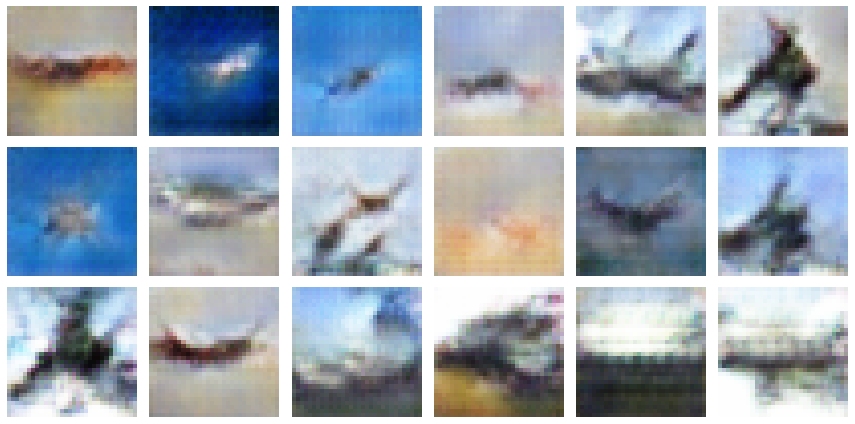

31/31 [==============================] - 253s 8s/step - g_loss: 1.6587 - d_loss: 0.4614 - real_acc: 0.8039 - gen_acc: 0.7976 - aug_p: 1.1633e-04 - val_kid: 0.2067
Epoch 136/500
31/31 [==============================] - 230s 7s/step - g_loss: 1.6797 - d_loss: 0.4831 - real_acc: 0.7828 - gen_acc: 0.7618 - aug_p: 1.2016e-04 - val_kid: 0.2153
Epoch 137/500
31/31 [==============================] - 212s 7s/step - g_loss: 1.7991 - d_loss: 0.4268 - real_acc: 0.8170 - gen_acc: 0.8049 - aug_p: 1.0091e-04 - val_kid: 0.2203
Epoch 138/500
31/31 [==============================] - 238s 7s/step - g_loss: 1.7759 - d_loss: 0.4254 - real_acc: 0.8100 - gen_acc: 0.8178 - aug_p: 1.0877e-04 - val_kid: 0.2247
Epoch 139/500
31/31 [==============================] - 232s 7s/step - g_loss: 1.8585 - d_loss: 0.4304 - real_acc: 0.8238 - gen_acc: 0.7772 - aug_p: 1.5197e-04 - val_kid: 0.2360
Epoch 140/500
31/31 [==============================] - ETA: 0s - g_loss: 1.7763 - d_loss: 0.4395 - real_acc: 0.8125 - gen_acc: 0.

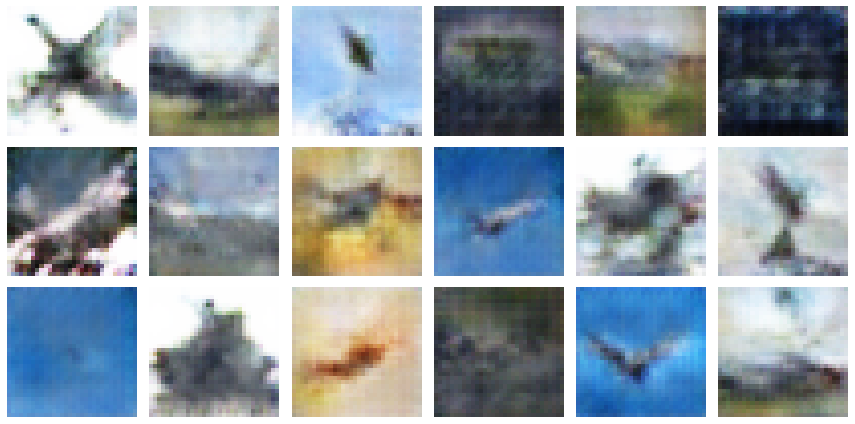

31/31 [==============================] - 255s 8s/step - g_loss: 1.7763 - d_loss: 0.4395 - real_acc: 0.8125 - gen_acc: 0.7886 - aug_p: 4.8286e-05 - val_kid: 0.2351
Epoch 141/500
31/31 [==============================] - 235s 7s/step - g_loss: 1.7791 - d_loss: 0.4795 - real_acc: 0.7651 - gen_acc: 0.7656 - aug_p: 4.2238e-05 - val_kid: 0.2301
Epoch 142/500
31/31 [==============================] - 249s 8s/step - g_loss: 1.8493 - d_loss: 0.4180 - real_acc: 0.8322 - gen_acc: 0.8102 - aug_p: 2.0857e-04 - val_kid: 0.2197
Epoch 143/500
31/31 [==============================] - 243s 8s/step - g_loss: 1.7418 - d_loss: 0.4489 - real_acc: 0.8029 - gen_acc: 0.7886 - aug_p: 1.1981e-04 - val_kid: 0.2210
Epoch 144/500
31/31 [==============================] - 253s 8s/step - g_loss: 1.8371 - d_loss: 0.4394 - real_acc: 0.8067 - gen_acc: 0.7805 - aug_p: 1.3493e-04 - val_kid: 0.2226
Epoch 145/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9513 - d_loss: 0.4270 - real_acc: 0.8110 - gen_acc: 0.

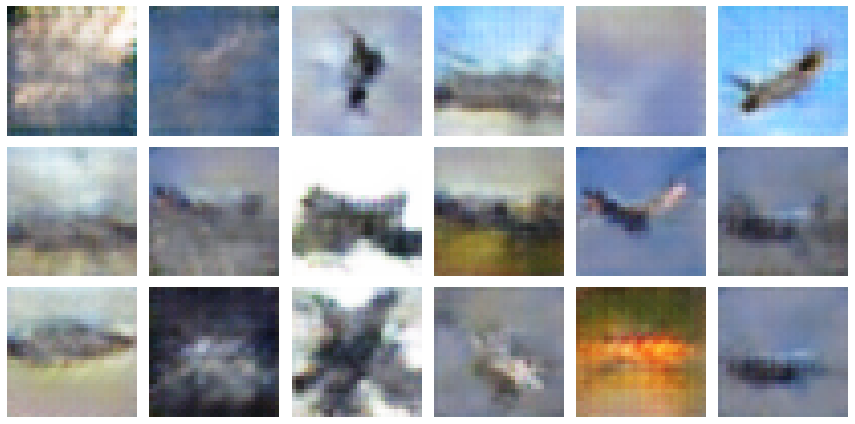

31/31 [==============================] - 272s 9s/step - g_loss: 1.9513 - d_loss: 0.4270 - real_acc: 0.8110 - gen_acc: 0.8014 - aug_p: 9.8740e-05 - val_kid: 0.2243
Epoch 146/500
31/31 [==============================] - 250s 8s/step - g_loss: 1.9177 - d_loss: 0.4415 - real_acc: 0.8077 - gen_acc: 0.8087 - aug_p: 1.3816e-04 - val_kid: 0.2271
Epoch 147/500
31/31 [==============================] - 262s 9s/step - g_loss: 1.8177 - d_loss: 0.4567 - real_acc: 0.8029 - gen_acc: 0.7896 - aug_p: 2.1018e-04 - val_kid: 0.2180
Epoch 148/500
31/31 [==============================] - 276s 9s/step - g_loss: 1.5932 - d_loss: 0.4570 - real_acc: 0.8105 - gen_acc: 0.7765 - aug_p: 5.7308e-05 - val_kid: 0.2222
Epoch 149/500
31/31 [==============================] - 275s 9s/step - g_loss: 2.0601 - d_loss: 0.4981 - real_acc: 0.7765 - gen_acc: 0.7755 - aug_p: 9.5665e-05 - val_kid: 0.2223
Epoch 150/500
31/31 [==============================] - ETA: 0s - g_loss: 1.6970 - d_loss: 0.4442 - real_acc: 0.7936 - gen_acc: 0.

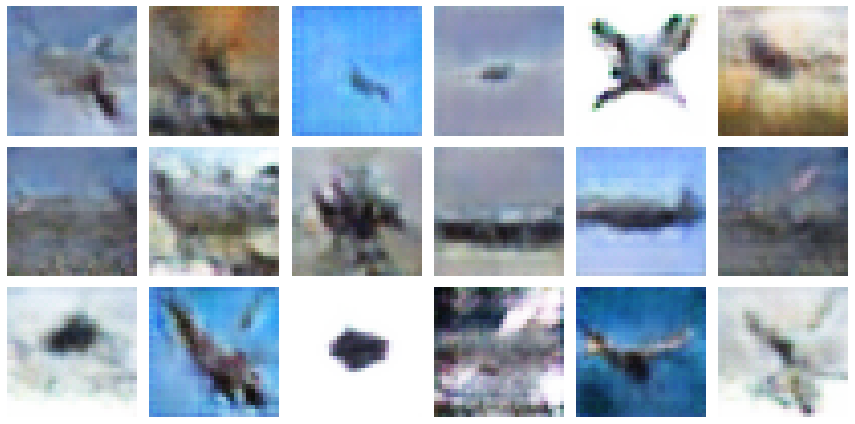

31/31 [==============================] - 275s 9s/step - g_loss: 1.6970 - d_loss: 0.4442 - real_acc: 0.7936 - gen_acc: 0.7999 - aug_p: 4.2944e-05 - val_kid: 0.2165
Epoch 151/500
31/31 [==============================] - 266s 8s/step - g_loss: 1.8420 - d_loss: 0.4437 - real_acc: 0.8092 - gen_acc: 0.7848 - aug_p: 1.1583e-04 - val_kid: 0.2135
Epoch 152/500
31/31 [==============================] - 255s 8s/step - g_loss: 1.7189 - d_loss: 0.4435 - real_acc: 0.8067 - gen_acc: 0.7805 - aug_p: 8.1250e-05 - val_kid: 0.2127
Epoch 153/500
31/31 [==============================] - 258s 8s/step - g_loss: 1.8283 - d_loss: 0.4806 - real_acc: 0.7782 - gen_acc: 0.7664 - aug_p: 6.6129e-05 - val_kid: 0.2088
Epoch 154/500
31/31 [==============================] - 235s 7s/step - g_loss: 1.7217 - d_loss: 0.4731 - real_acc: 0.7845 - gen_acc: 0.7697 - aug_p: 6.4718e-05 - val_kid: 0.2116
Epoch 155/500
31/31 [==============================] - ETA: 0s - g_loss: 1.7984 - d_loss: 0.4588 - real_acc: 0.7896 - gen_acc: 0.

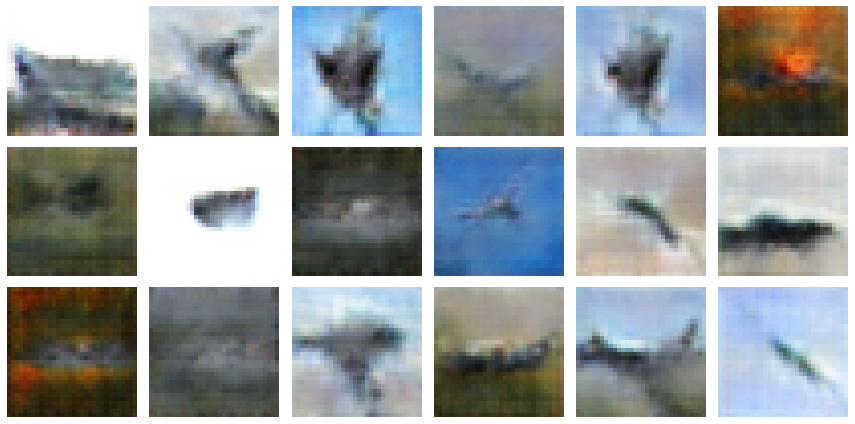

31/31 [==============================] - 263s 9s/step - g_loss: 1.7984 - d_loss: 0.4588 - real_acc: 0.7896 - gen_acc: 0.7770 - aug_p: 5.8518e-05 - val_kid: 0.2235
Epoch 156/500
31/31 [==============================] - 235s 8s/step - g_loss: 1.9140 - d_loss: 0.4222 - real_acc: 0.8143 - gen_acc: 0.8090 - aug_p: 1.3070e-04 - val_kid: 0.2091
Epoch 157/500
31/31 [==============================] - 231s 7s/step - g_loss: 1.6491 - d_loss: 0.4593 - real_acc: 0.7853 - gen_acc: 0.7896 - aug_p: 5.6300e-05 - val_kid: 0.2195
Epoch 158/500
31/31 [==============================] - 248s 8s/step - g_loss: 1.8381 - d_loss: 0.4433 - real_acc: 0.8120 - gen_acc: 0.7863 - aug_p: 8.4677e-05 - val_kid: 0.2163
Epoch 159/500
31/31 [==============================] - 235s 7s/step - g_loss: 1.8466 - d_loss: 0.4588 - real_acc: 0.7855 - gen_acc: 0.7921 - aug_p: 1.4667e-04 - val_kid: 0.2103
Epoch 160/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8955 - d_loss: 0.3755 - real_acc: 0.8387 - gen_acc: 0.

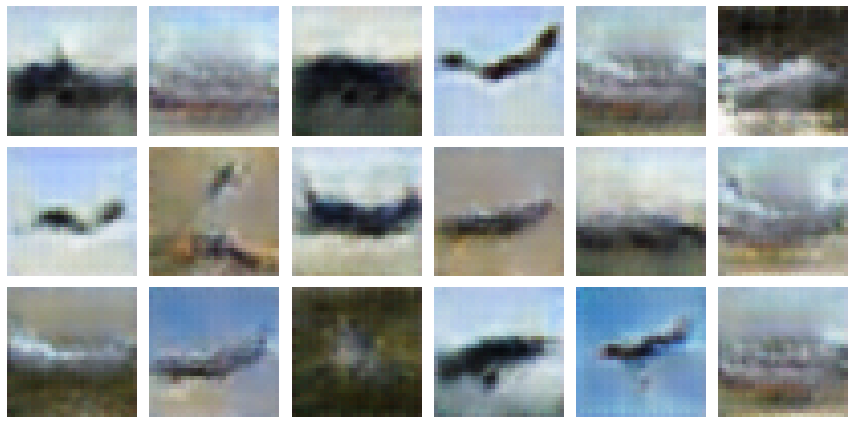

31/31 [==============================] - 260s 8s/step - g_loss: 1.8955 - d_loss: 0.3755 - real_acc: 0.8387 - gen_acc: 0.8518 - aug_p: 2.9990e-04 - val_kid: 0.2100
Epoch 161/500
31/31 [==============================] - 236s 8s/step - g_loss: 1.9050 - d_loss: 0.4335 - real_acc: 0.8160 - gen_acc: 0.7855 - aug_p: 8.5383e-05 - val_kid: 0.2098
Epoch 162/500
31/31 [==============================] - 253s 8s/step - g_loss: 1.6877 - d_loss: 0.4599 - real_acc: 0.7906 - gen_acc: 0.7833 - aug_p: 5.0706e-05 - val_kid: 0.2076
Epoch 163/500
31/31 [==============================] - 234s 7s/step - g_loss: 1.9076 - d_loss: 0.4311 - real_acc: 0.8044 - gen_acc: 0.7984 - aug_p: 1.1416e-04 - val_kid: 0.2031
Epoch 164/500
31/31 [==============================] - 240s 8s/step - g_loss: 2.0519 - d_loss: 0.4254 - real_acc: 0.8221 - gen_acc: 0.7765 - aug_p: 1.1845e-04 - val_kid: 0.2075
Epoch 165/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8266 - d_loss: 0.4607 - real_acc: 0.7964 - gen_acc: 0.

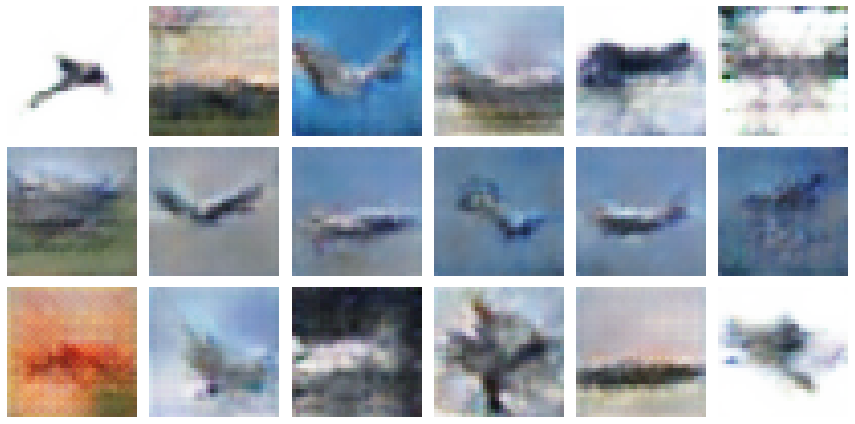

31/31 [==============================] - 271s 9s/step - g_loss: 1.8266 - d_loss: 0.4607 - real_acc: 0.7964 - gen_acc: 0.7611 - aug_p: 6.0585e-05 - val_kid: 0.2128
Epoch 166/500
31/31 [==============================] - 262s 8s/step - g_loss: 1.9348 - d_loss: 0.4122 - real_acc: 0.8117 - gen_acc: 0.8130 - aug_p: 1.0237e-04 - val_kid: 0.2131
Epoch 167/500
31/31 [==============================] - 258s 8s/step - g_loss: 1.9722 - d_loss: 0.4044 - real_acc: 0.8256 - gen_acc: 0.8080 - aug_p: 1.2727e-04 - val_kid: 0.2088
Epoch 168/500
31/31 [==============================] - 249s 8s/step - g_loss: 1.7898 - d_loss: 0.4403 - real_acc: 0.8120 - gen_acc: 0.7999 - aug_p: 1.5055e-04 - val_kid: 0.2004
Epoch 169/500
31/31 [==============================] - 272s 9s/step - g_loss: 1.9313 - d_loss: 0.4104 - real_acc: 0.8070 - gen_acc: 0.8017 - aug_p: 8.8155e-05 - val_kid: 0.1993
Epoch 170/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9100 - d_loss: 0.4286 - real_acc: 0.8165 - gen_acc: 0.

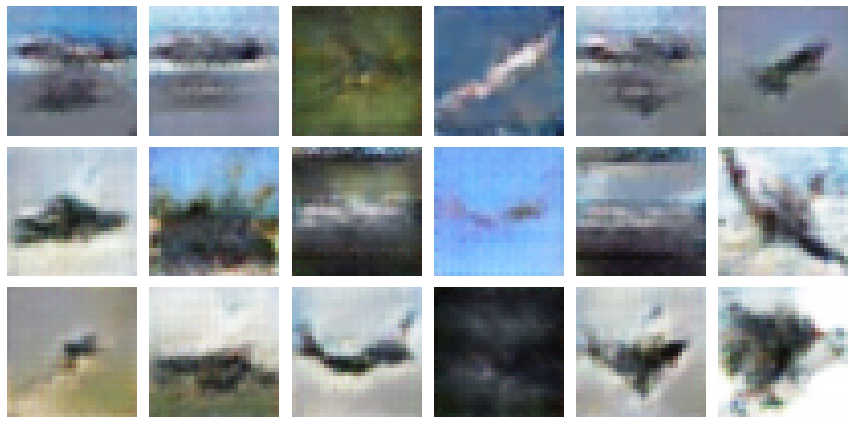

31/31 [==============================] - 295s 9s/step - g_loss: 1.9100 - d_loss: 0.4286 - real_acc: 0.8165 - gen_acc: 0.7951 - aug_p: 8.8256e-05 - val_kid: 0.1894
Epoch 171/500
31/31 [==============================] - 288s 9s/step - g_loss: 1.9235 - d_loss: 0.4484 - real_acc: 0.8082 - gen_acc: 0.7888 - aug_p: 1.0111e-04 - val_kid: 0.1946
Epoch 172/500
31/31 [==============================] - 339s 11s/step - g_loss: 1.8825 - d_loss: 0.4351 - real_acc: 0.8090 - gen_acc: 0.7911 - aug_p: 9.1885e-05 - val_kid: 0.1805
Epoch 173/500
31/31 [==============================] - 326s 10s/step - g_loss: 1.8083 - d_loss: 0.4114 - real_acc: 0.8367 - gen_acc: 0.8148 - aug_p: 1.4148e-04 - val_kid: 0.1910
Epoch 174/500
31/31 [==============================] - 287s 9s/step - g_loss: 1.9069 - d_loss: 0.4366 - real_acc: 0.8002 - gen_acc: 0.7971 - aug_p: 1.5474e-04 - val_kid: 0.1892
Epoch 175/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8822 - d_loss: 0.4508 - real_acc: 0.8170 - gen_acc: 

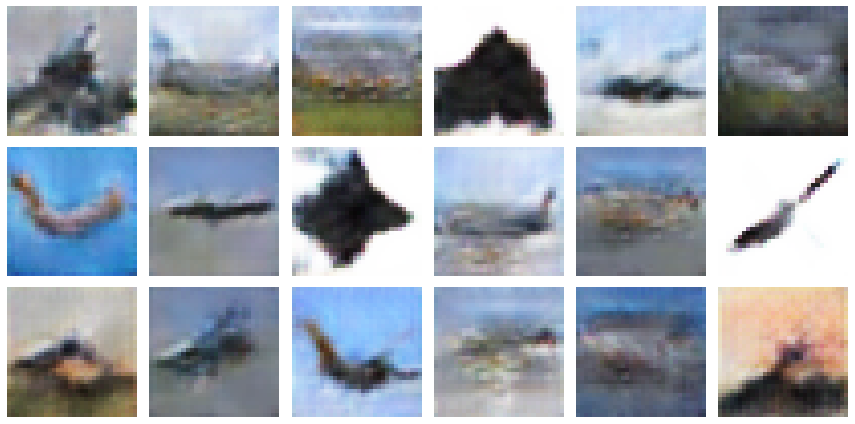

31/31 [==============================] - 331s 11s/step - g_loss: 1.8822 - d_loss: 0.4508 - real_acc: 0.8170 - gen_acc: 0.7807 - aug_p: 8.5282e-05 - val_kid: 0.1919
Epoch 176/500
31/31 [==============================] - 297s 10s/step - g_loss: 1.9149 - d_loss: 0.4238 - real_acc: 0.8102 - gen_acc: 0.8085 - aug_p: 5.2923e-05 - val_kid: 0.1878
Epoch 177/500
31/31 [==============================] - 261s 8s/step - g_loss: 1.8567 - d_loss: 0.4725 - real_acc: 0.8128 - gen_acc: 0.7790 - aug_p: 9.4758e-05 - val_kid: 0.1939
Epoch 178/500
31/31 [==============================] - 263s 8s/step - g_loss: 1.7112 - d_loss: 0.4228 - real_acc: 0.8236 - gen_acc: 0.8067 - aug_p: 9.4657e-05 - val_kid: 0.1945
Epoch 179/500
31/31 [==============================] - 264s 8s/step - g_loss: 1.8885 - d_loss: 0.4097 - real_acc: 0.8208 - gen_acc: 0.8102 - aug_p: 1.4047e-04 - val_kid: 0.1917
Epoch 180/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9150 - d_loss: 0.4362 - real_acc: 0.7986 - gen_acc: 

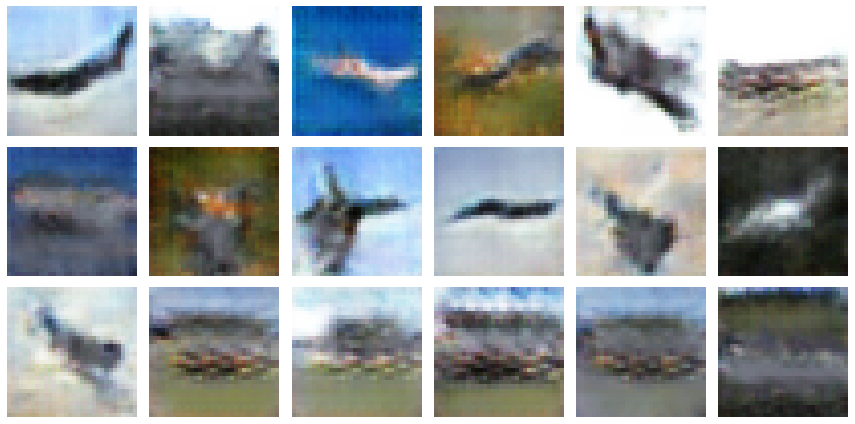

31/31 [==============================] - 273s 9s/step - g_loss: 1.9150 - d_loss: 0.4362 - real_acc: 0.7986 - gen_acc: 0.7913 - aug_p: 1.0181e-04 - val_kid: 0.1944
Epoch 181/500
31/31 [==============================] - 273s 9s/step - g_loss: 1.8495 - d_loss: 0.4364 - real_acc: 0.8138 - gen_acc: 0.8029 - aug_p: 1.0897e-04 - val_kid: 0.1942
Epoch 182/500
31/31 [==============================] - 279s 9s/step - g_loss: 2.0057 - d_loss: 0.4445 - real_acc: 0.8002 - gen_acc: 0.7941 - aug_p: 1.4556e-04 - val_kid: 0.1907
Epoch 183/500
31/31 [==============================] - 320s 10s/step - g_loss: 1.9469 - d_loss: 0.4469 - real_acc: 0.8042 - gen_acc: 0.7949 - aug_p: 1.2233e-04 - val_kid: 0.1932
Epoch 184/500
31/31 [==============================] - 269s 9s/step - g_loss: 2.0993 - d_loss: 0.3726 - real_acc: 0.8528 - gen_acc: 0.8279 - aug_p: 1.9793e-04 - val_kid: 0.1835
Epoch 185/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0761 - d_loss: 0.4118 - real_acc: 0.8143 - gen_acc: 0

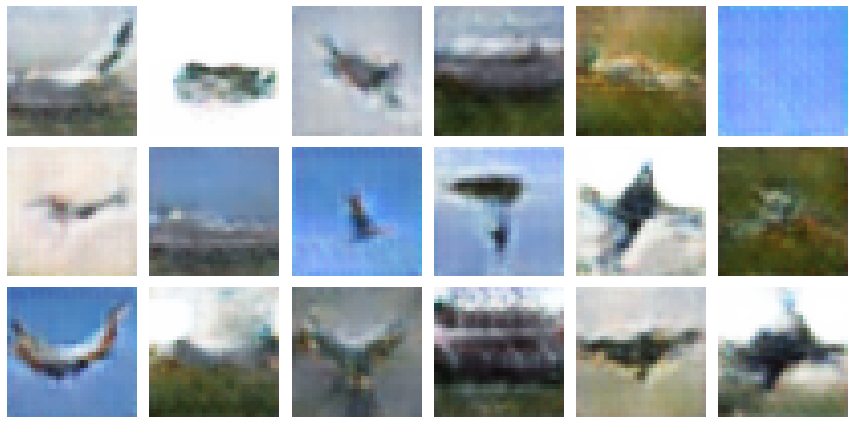

31/31 [==============================] - 310s 10s/step - g_loss: 2.0761 - d_loss: 0.4118 - real_acc: 0.8143 - gen_acc: 0.7969 - aug_p: 1.1966e-04 - val_kid: 0.1925
Epoch 186/500
31/31 [==============================] - 275s 9s/step - g_loss: 1.9241 - d_loss: 0.4477 - real_acc: 0.8012 - gen_acc: 0.7893 - aug_p: 8.6089e-05 - val_kid: 0.1899
Epoch 187/500
31/31 [==============================] - 280s 9s/step - g_loss: 1.9480 - d_loss: 0.3881 - real_acc: 0.8420 - gen_acc: 0.8233 - aug_p: 1.3473e-04 - val_kid: 0.1891
Epoch 188/500
31/31 [==============================] - 290s 9s/step - g_loss: 2.0333 - d_loss: 0.4019 - real_acc: 0.8236 - gen_acc: 0.8105 - aug_p: 1.5126e-04 - val_kid: 0.1893
Epoch 189/500
31/31 [==============================] - 273s 9s/step - g_loss: 1.9052 - d_loss: 0.4903 - real_acc: 0.7729 - gen_acc: 0.7445 - aug_p: 7.3841e-05 - val_kid: 0.1867
Epoch 190/500
31/31 [==============================] - ETA: 0s - g_loss: 1.8753 - d_loss: 0.4404 - real_acc: 0.8117 - gen_acc: 0

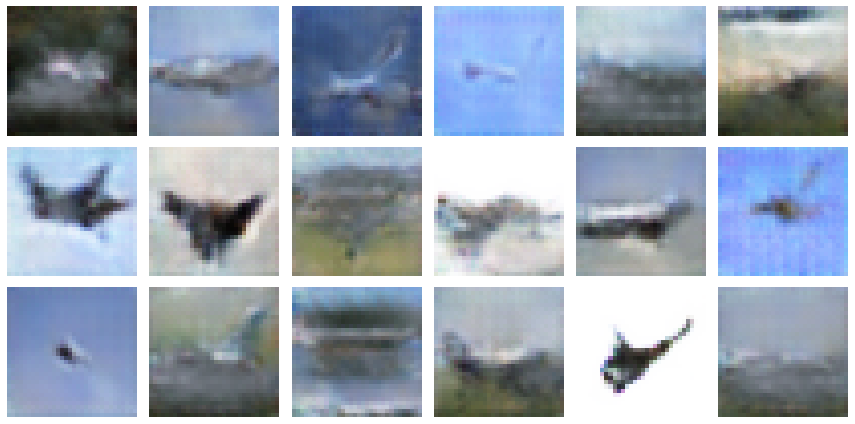

31/31 [==============================] - 311s 10s/step - g_loss: 1.8753 - d_loss: 0.4404 - real_acc: 0.8117 - gen_acc: 0.7848 - aug_p: 1.9713e-04 - val_kid: 0.1985
Epoch 191/500
31/31 [==============================] - 286s 9s/step - g_loss: 1.7652 - d_loss: 0.4217 - real_acc: 0.8183 - gen_acc: 0.8319 - aug_p: 7.6462e-05 - val_kid: 0.2035
Epoch 192/500
31/31 [==============================] - 296s 9s/step - g_loss: 2.0352 - d_loss: 0.4133 - real_acc: 0.8296 - gen_acc: 0.8097 - aug_p: 1.8160e-04 - val_kid: 0.1992
Epoch 193/500
31/31 [==============================] - 282s 9s/step - g_loss: 1.8836 - d_loss: 0.4661 - real_acc: 0.7845 - gen_acc: 0.7777 - aug_p: 9.4254e-05 - val_kid: 0.1845
Epoch 194/500
31/31 [==============================] - 296s 9s/step - g_loss: 1.8365 - d_loss: 0.3657 - real_acc: 0.8541 - gen_acc: 0.8465 - aug_p: 1.8780e-04 - val_kid: 0.1838
Epoch 195/500
31/31 [==============================] - ETA: 0s - g_loss: 2.1035 - d_loss: 0.4049 - real_acc: 0.8281 - gen_acc: 0

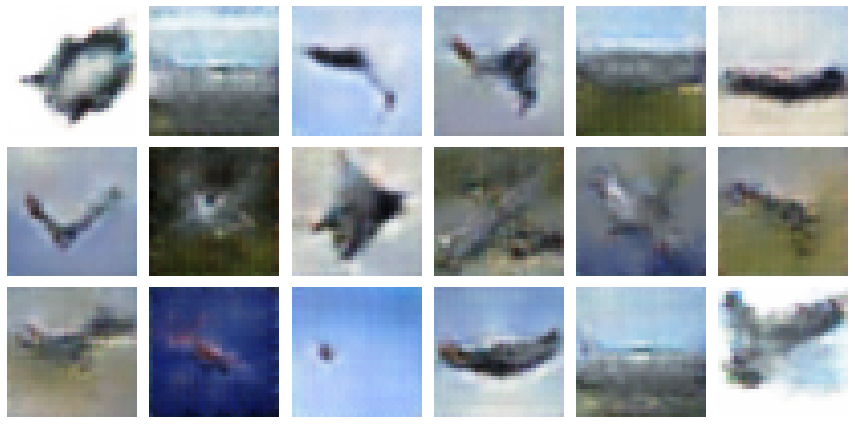

31/31 [==============================] - 306s 10s/step - g_loss: 2.1035 - d_loss: 0.4049 - real_acc: 0.8281 - gen_acc: 0.8022 - aug_p: 2.3942e-04 - val_kid: 0.1755
Epoch 196/500
31/31 [==============================] - 291s 9s/step - g_loss: 1.8810 - d_loss: 0.4528 - real_acc: 0.8107 - gen_acc: 0.7996 - aug_p: 3.1764e-04 - val_kid: 0.1798
Epoch 197/500
31/31 [==============================] - 281s 9s/step - g_loss: 1.9887 - d_loss: 0.3778 - real_acc: 0.8488 - gen_acc: 0.8243 - aug_p: 3.0731e-04 - val_kid: 0.1813
Epoch 198/500
31/31 [==============================] - 287s 9s/step - g_loss: 2.0461 - d_loss: 0.4086 - real_acc: 0.8188 - gen_acc: 0.8173 - aug_p: 1.1825e-04 - val_kid: 0.1792
Epoch 199/500
31/31 [==============================] - 285s 9s/step - g_loss: 2.0034 - d_loss: 0.4410 - real_acc: 0.8254 - gen_acc: 0.8314 - aug_p: 1.6336e-04 - val_kid: 0.1820
Epoch 200/500
31/31 [==============================] - ETA: 0s - g_loss: 2.1283 - d_loss: 0.4277 - real_acc: 0.8251 - gen_acc: 0

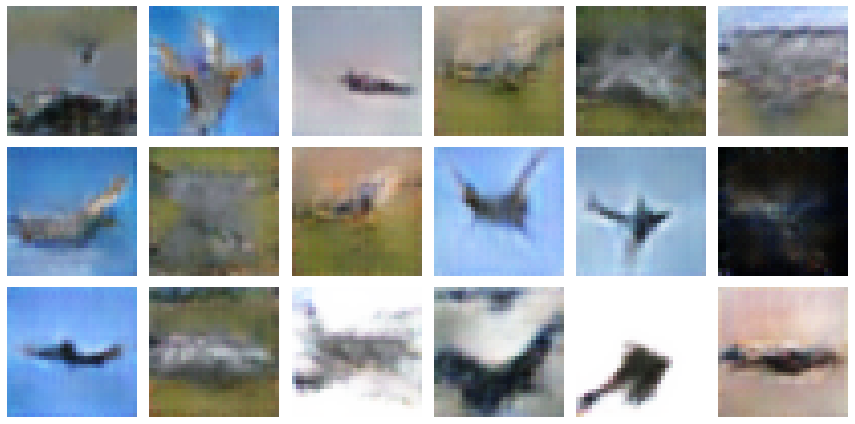

31/31 [==============================] - 301s 10s/step - g_loss: 2.1283 - d_loss: 0.4277 - real_acc: 0.8251 - gen_acc: 0.8012 - aug_p: 2.1583e-04 - val_kid: 0.1896
Epoch 201/500
31/31 [==============================] - 282s 9s/step - g_loss: 1.9443 - d_loss: 0.3978 - real_acc: 0.8430 - gen_acc: 0.8049 - aug_p: 2.3624e-04 - val_kid: 0.1883
Epoch 202/500
31/31 [==============================] - 282s 9s/step - g_loss: 1.9897 - d_loss: 0.4002 - real_acc: 0.8289 - gen_acc: 0.8291 - aug_p: 3.2979e-04 - val_kid: 0.1873
Epoch 203/500
31/31 [==============================] - 278s 9s/step - g_loss: 2.0386 - d_loss: 0.4003 - real_acc: 0.8236 - gen_acc: 0.8077 - aug_p: 1.4919e-04 - val_kid: 0.1831
Epoch 204/500
31/31 [==============================] - 286s 9s/step - g_loss: 2.0232 - d_loss: 0.3744 - real_acc: 0.8324 - gen_acc: 0.8380 - aug_p: 2.7258e-04 - val_kid: 0.1831
Epoch 205/500
31/31 [==============================] - ETA: 0s - g_loss: 2.0157 - d_loss: 0.3953 - real_acc: 0.8266 - gen_acc: 0

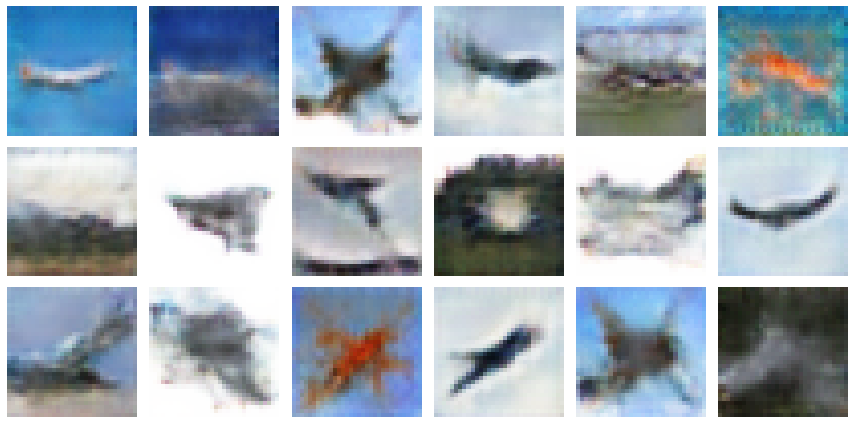

31/31 [==============================] - 302s 10s/step - g_loss: 2.0157 - d_loss: 0.3953 - real_acc: 0.8266 - gen_acc: 0.8112 - aug_p: 2.0585e-04 - val_kid: 0.1875
Epoch 206/500
31/31 [==============================] - 275s 9s/step - g_loss: 2.1331 - d_loss: 0.3527 - real_acc: 0.8518 - gen_acc: 0.8374 - aug_p: 1.7056e-04 - val_kid: 0.1772
Epoch 207/500
31/31 [==============================] - 298s 10s/step - g_loss: 2.2107 - d_loss: 0.3970 - real_acc: 0.8357 - gen_acc: 0.8052 - aug_p: 1.8735e-04 - val_kid: 0.1710
Epoch 208/500
31/31 [==============================] - 304s 10s/step - g_loss: 2.0463 - d_loss: 0.4286 - real_acc: 0.8044 - gen_acc: 0.7850 - aug_p: 1.0202e-04 - val_kid: 0.1688
Epoch 209/500
31/31 [==============================] - 288s 9s/step - g_loss: 2.2404 - d_loss: 0.3567 - real_acc: 0.8468 - gen_acc: 0.8445 - aug_p: 2.0343e-04 - val_kid: 0.1729
Epoch 210/500
31/31 [==============================] - ETA: 0s - g_loss: 2.1438 - d_loss: 0.4202 - real_acc: 0.8206 - gen_acc:

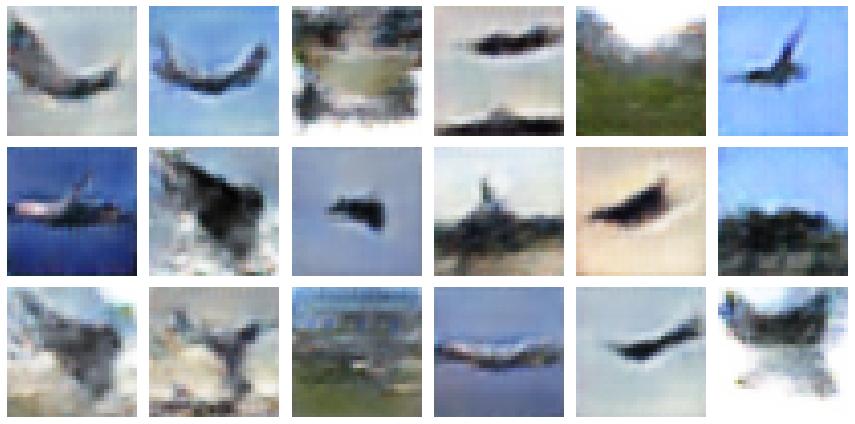

31/31 [==============================] - 293s 9s/step - g_loss: 2.1438 - d_loss: 0.4202 - real_acc: 0.8206 - gen_acc: 0.7888 - aug_p: 1.7606e-04 - val_kid: 0.1815
Epoch 211/500
31/31 [==============================] - 291s 9s/step - g_loss: 2.1240 - d_loss: 0.4089 - real_acc: 0.8097 - gen_acc: 0.8155 - aug_p: 1.1336e-04 - val_kid: 0.1939
Epoch 212/500
31/31 [==============================] - 278s 9s/step - g_loss: 2.0573 - d_loss: 0.4076 - real_acc: 0.8387 - gen_acc: 0.8178 - aug_p: 1.8931e-04 - val_kid: 0.1951
Epoch 213/500
31/31 [==============================] - 278s 9s/step - g_loss: 2.1207 - d_loss: 0.3878 - real_acc: 0.8448 - gen_acc: 0.8294 - aug_p: 6.2490e-04 - val_kid: 0.1969
Epoch 214/500
31/31 [==============================] - 274s 9s/step - g_loss: 2.3928 - d_loss: 0.3833 - real_acc: 0.8450 - gen_acc: 0.8019 - aug_p: 3.1789e-04 - val_kid: 0.1886
Epoch 215/500
31/31 [==============================] - ETA: 0s - g_loss: 2.3875 - d_loss: 0.3789 - real_acc: 0.8420 - gen_acc: 0.

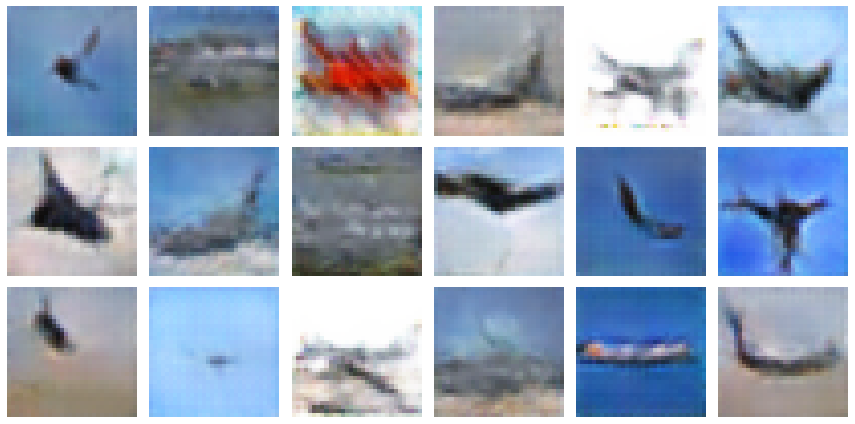

31/31 [==============================] - 302s 10s/step - g_loss: 2.3875 - d_loss: 0.3789 - real_acc: 0.8420 - gen_acc: 0.8276 - aug_p: 6.6835e-04 - val_kid: 0.1757
Epoch 216/500
31/31 [==============================] - 259s 8s/step - g_loss: 2.0527 - d_loss: 0.4324 - real_acc: 0.8294 - gen_acc: 0.8034 - aug_p: 4.4763e-04 - val_kid: 0.1724
Epoch 217/500
31/31 [==============================] - 174s 6s/step - g_loss: 2.1031 - d_loss: 0.3826 - real_acc: 0.8435 - gen_acc: 0.8276 - aug_p: 3.8468e-04 - val_kid: 0.1717
Epoch 218/500
31/31 [==============================] - 135s 4s/step - g_loss: 2.2510 - d_loss: 0.3697 - real_acc: 0.8367 - gen_acc: 0.8342 - aug_p: 4.1038e-04 - val_kid: 0.1783
Epoch 219/500
31/31 [==============================] - 135s 4s/step - g_loss: 2.2004 - d_loss: 0.3678 - real_acc: 0.8460 - gen_acc: 0.8352 - aug_p: 1.7913e-04 - val_kid: 0.1703
Epoch 220/500
31/31 [==============================] - ETA: 0s - g_loss: 2.2900 - d_loss: 0.3871 - real_acc: 0.8319 - gen_acc: 0

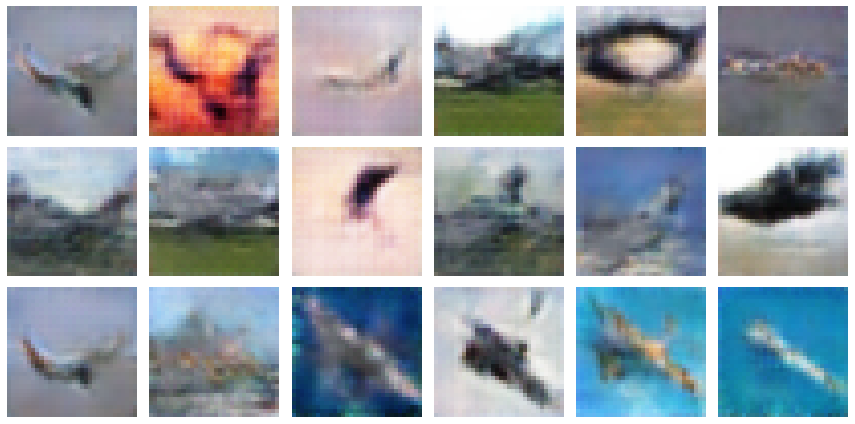

31/31 [==============================] - 147s 5s/step - g_loss: 2.2900 - d_loss: 0.3871 - real_acc: 0.8319 - gen_acc: 0.8178 - aug_p: 1.6910e-04 - val_kid: 0.1729
Epoch 221/500
31/31 [==============================] - 140s 4s/step - g_loss: 2.0836 - d_loss: 0.3477 - real_acc: 0.8594 - gen_acc: 0.8427 - aug_p: 2.4395e-04 - val_kid: 0.1585
Epoch 222/500
31/31 [==============================] - 130s 4s/step - g_loss: 2.3577 - d_loss: 0.3604 - real_acc: 0.8443 - gen_acc: 0.8392 - aug_p: 2.7853e-04 - val_kid: 0.1786
Epoch 223/500
31/31 [==============================] - 127s 4s/step - g_loss: 2.3867 - d_loss: 0.3991 - real_acc: 0.8468 - gen_acc: 0.8029 - aug_p: 3.9249e-04 - val_kid: 0.1840
Epoch 224/500
31/31 [==============================] - 130s 4s/step - g_loss: 2.2691 - d_loss: 0.3601 - real_acc: 0.8501 - gen_acc: 0.8339 - aug_p: 4.5958e-04 - val_kid: 0.1814
Epoch 225/500
31/31 [==============================] - ETA: 0s - g_loss: 2.4369 - d_loss: 0.3614 - real_acc: 0.8627 - gen_acc: 0.

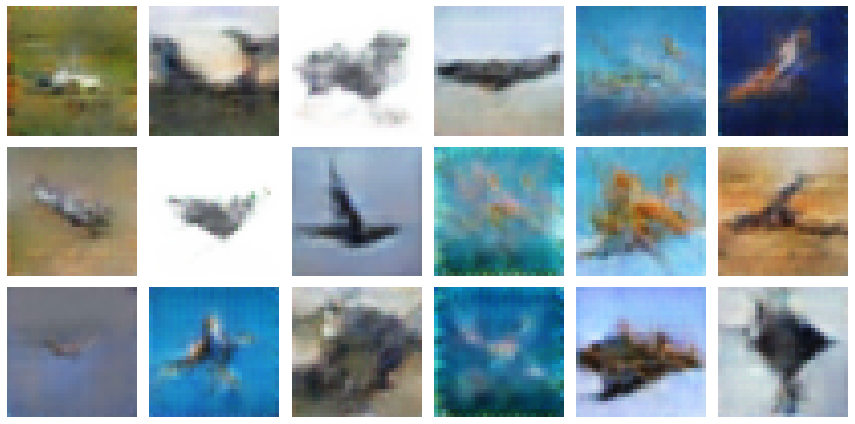

31/31 [==============================] - 132s 4s/step - g_loss: 2.4369 - d_loss: 0.3614 - real_acc: 0.8627 - gen_acc: 0.8392 - aug_p: 6.3755e-04 - val_kid: 0.1792
Epoch 226/500
31/31 [==============================] - 132s 4s/step - g_loss: 2.2519 - d_loss: 0.3564 - real_acc: 0.8609 - gen_acc: 0.8251 - aug_p: 7.2379e-04 - val_kid: 0.1681
Epoch 227/500
31/31 [==============================] - 113s 4s/step - g_loss: 2.3277 - d_loss: 0.4039 - real_acc: 0.8183 - gen_acc: 0.8261 - aug_p: 6.1764e-04 - val_kid: 0.1634
Epoch 228/500
31/31 [==============================] - 110s 4s/step - g_loss: 2.2437 - d_loss: 0.3971 - real_acc: 0.8327 - gen_acc: 0.8165 - aug_p: 2.2535e-04 - val_kid: 0.1742
Epoch 229/500
31/31 [==============================] - 109s 3s/step - g_loss: 2.2611 - d_loss: 0.3757 - real_acc: 0.8306 - gen_acc: 0.8463 - aug_p: 2.1310e-04 - val_kid: 0.1652
Epoch 230/500
31/31 [==============================] - ETA: 0s - g_loss: 1.9316 - d_loss: 0.3877 - real_acc: 0.8480 - gen_acc: 0.

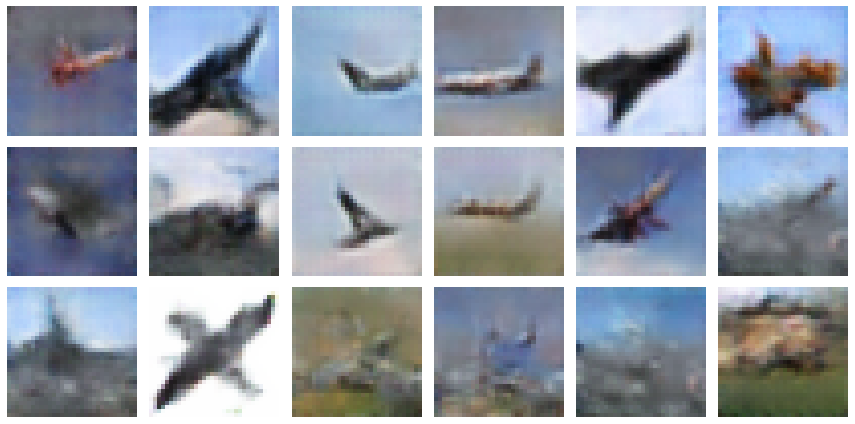

31/31 [==============================] - 119s 4s/step - g_loss: 1.9316 - d_loss: 0.3877 - real_acc: 0.8480 - gen_acc: 0.8261 - aug_p: 2.8926e-04 - val_kid: 0.1527
Epoch 231/500
31/31 [==============================] - 113s 4s/step - g_loss: 2.1341 - d_loss: 0.3680 - real_acc: 0.8400 - gen_acc: 0.8254 - aug_p: 2.1976e-04 - val_kid: 0.1664
Epoch 232/500
31/31 [==============================] - 116s 4s/step - g_loss: 2.2950 - d_loss: 0.4282 - real_acc: 0.8148 - gen_acc: 0.8014 - aug_p: 2.1951e-04 - val_kid: 0.1641
Epoch 233/500
31/31 [==============================] - 125s 4s/step - g_loss: 2.0771 - d_loss: 0.3979 - real_acc: 0.8256 - gen_acc: 0.8102 - aug_p: 1.4652e-04 - val_kid: 0.1820
Epoch 234/500
31/31 [==============================] - 134s 4s/step - g_loss: 2.2215 - d_loss: 0.3193 - real_acc: 0.8710 - gen_acc: 0.8722 - aug_p: 6.6472e-04 - val_kid: 0.1799
Epoch 235/500
31/31 [==============================] - ETA: 0s - g_loss: 2.3466 - d_loss: 0.3159 - real_acc: 0.8674 - gen_acc: 0.

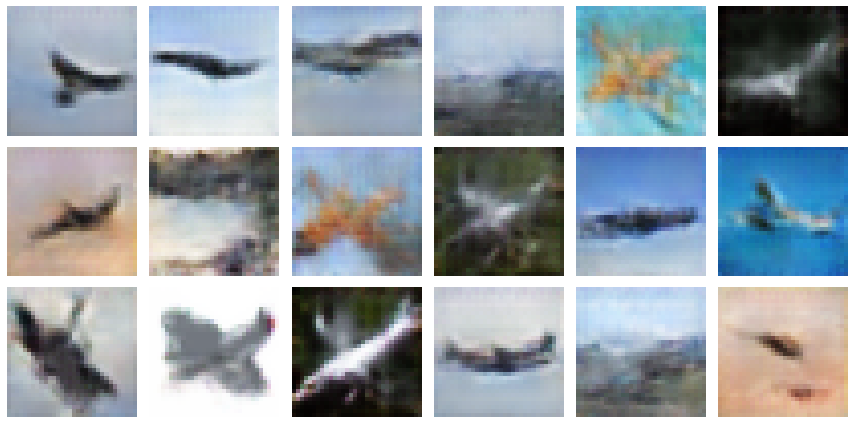

31/31 [==============================] - 153s 5s/step - g_loss: 2.3466 - d_loss: 0.3159 - real_acc: 0.8674 - gen_acc: 0.8677 - aug_p: 0.0012 - val_kid: 0.1806
Epoch 236/500
31/31 [==============================] - 135s 4s/step - g_loss: 2.7849 - d_loss: 0.3192 - real_acc: 0.8722 - gen_acc: 0.8448 - aug_p: 0.0016 - val_kid: 0.1783
Epoch 237/500
31/31 [==============================] - 134s 4s/step - g_loss: 2.6912 - d_loss: 0.4219 - real_acc: 0.8216 - gen_acc: 0.8067 - aug_p: 0.0015 - val_kid: 0.1854
Epoch 238/500
31/31 [==============================] - 159s 5s/step - g_loss: 2.3511 - d_loss: 0.3024 - real_acc: 0.8740 - gen_acc: 0.8831 - aug_p: 0.0017 - val_kid: 0.1911
Epoch 239/500
31/31 [==============================] - 176s 6s/step - g_loss: 2.4255 - d_loss: 0.3438 - real_acc: 0.8627 - gen_acc: 0.8374 - aug_p: 0.0021 - val_kid: 0.1841
Epoch 240/500
31/31 [==============================] - ETA: 0s - g_loss: 2.4610 - d_loss: 0.3005 - real_acc: 0.8798 - gen_acc: 0.8755 - aug_p: 0.0028

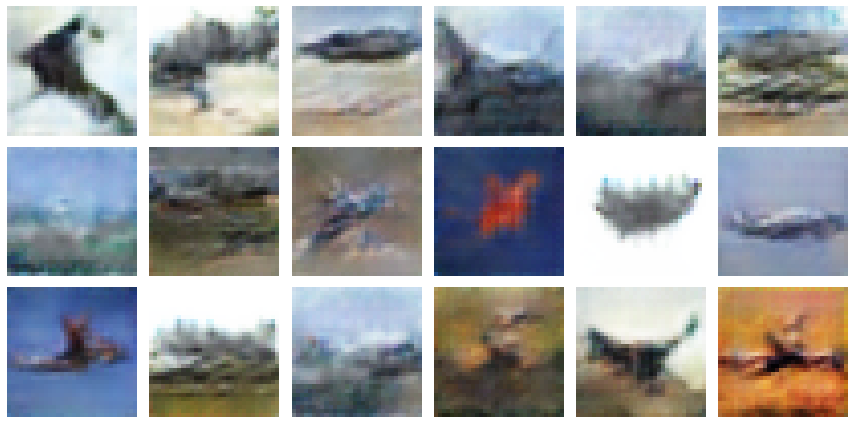

31/31 [==============================] - 170s 5s/step - g_loss: 2.4610 - d_loss: 0.3005 - real_acc: 0.8798 - gen_acc: 0.8755 - aug_p: 0.0028 - val_kid: 0.1808
Epoch 241/500
31/31 [==============================] - 160s 5s/step - g_loss: 2.4380 - d_loss: 0.3848 - real_acc: 0.8485 - gen_acc: 0.8198 - aug_p: 0.0035 - val_kid: 0.1783
Epoch 242/500
31/31 [==============================] - 154s 5s/step - g_loss: 2.3526 - d_loss: 0.2970 - real_acc: 0.8899 - gen_acc: 0.8821 - aug_p: 0.0039 - val_kid: 0.1860
Epoch 243/500
31/31 [==============================] - 153s 5s/step - g_loss: 2.4819 - d_loss: 0.3632 - real_acc: 0.8546 - gen_acc: 0.8256 - aug_p: 0.0048 - val_kid: 0.1891
Epoch 244/500
31/31 [==============================] - 141s 5s/step - g_loss: 2.4264 - d_loss: 0.3204 - real_acc: 0.8642 - gen_acc: 0.8725 - aug_p: 0.0048 - val_kid: 0.1814
Epoch 245/500
31/31 [==============================] - ETA: 0s - g_loss: 2.6518 - d_loss: 0.3106 - real_acc: 0.8758 - gen_acc: 0.8621 - aug_p: 0.0052

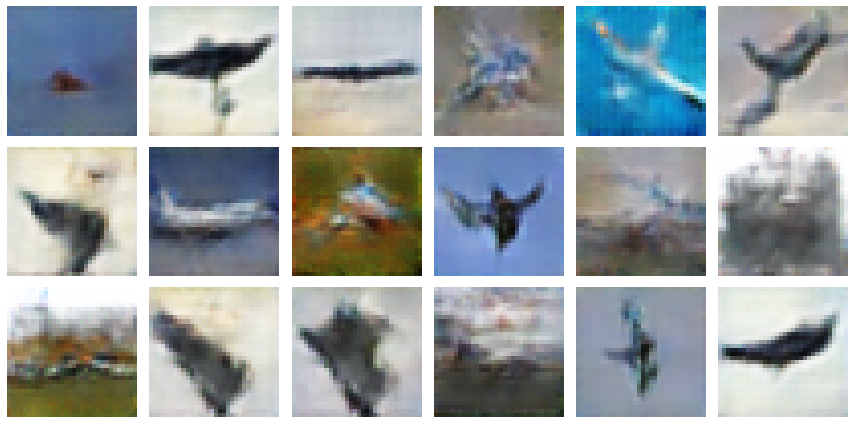

31/31 [==============================] - 147s 5s/step - g_loss: 2.6518 - d_loss: 0.3106 - real_acc: 0.8758 - gen_acc: 0.8621 - aug_p: 0.0052 - val_kid: 0.1610
Epoch 246/500
31/31 [==============================] - 139s 4s/step - g_loss: 2.6945 - d_loss: 0.3798 - real_acc: 0.8460 - gen_acc: 0.8531 - aug_p: 0.0059 - val_kid: 0.1697
Epoch 247/500
31/31 [==============================] - 140s 4s/step - g_loss: 2.6449 - d_loss: 0.3555 - real_acc: 0.8621 - gen_acc: 0.8453 - aug_p: 0.0059 - val_kid: 0.1718
Epoch 248/500
31/31 [==============================] - 146s 5s/step - g_loss: 2.3872 - d_loss: 0.3605 - real_acc: 0.8571 - gen_acc: 0.8251 - aug_p: 0.0063 - val_kid: 0.1598
Epoch 249/500
31/31 [==============================] - 141s 5s/step - g_loss: 2.4220 - d_loss: 0.3226 - real_acc: 0.8690 - gen_acc: 0.8566 - aug_p: 0.0066 - val_kid: 0.1560
Epoch 250/500
31/31 [==============================] - ETA: 0s - g_loss: 2.5481 - d_loss: 0.3093 - real_acc: 0.8846 - gen_acc: 0.8657 - aug_p: 0.0073

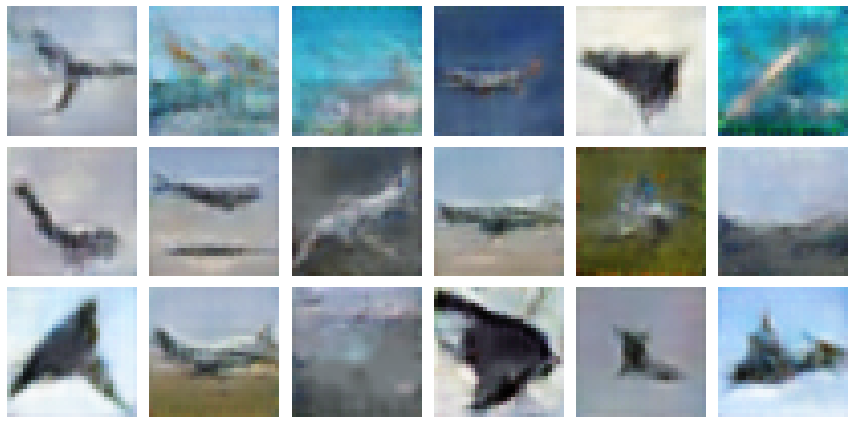

31/31 [==============================] - 149s 5s/step - g_loss: 2.5481 - d_loss: 0.3093 - real_acc: 0.8846 - gen_acc: 0.8657 - aug_p: 0.0073 - val_kid: 0.1525
Epoch 251/500
31/31 [==============================] - 143s 5s/step - g_loss: 2.7297 - d_loss: 0.2919 - real_acc: 0.8705 - gen_acc: 0.8866 - aug_p: 0.0082 - val_kid: 0.1701
Epoch 252/500
31/31 [==============================] - 141s 5s/step - g_loss: 3.0909 - d_loss: 0.3182 - real_acc: 0.8755 - gen_acc: 0.8561 - aug_p: 0.0094 - val_kid: 0.1612
Epoch 253/500
31/31 [==============================] - 144s 5s/step - g_loss: 2.6239 - d_loss: 0.3198 - real_acc: 0.8720 - gen_acc: 0.8483 - aug_p: 0.0095 - val_kid: 0.1609
Epoch 254/500
31/31 [==============================] - 138s 4s/step - g_loss: 2.5017 - d_loss: 0.3416 - real_acc: 0.8621 - gen_acc: 0.8558 - aug_p: 0.0102 - val_kid: 0.1529
Epoch 255/500
31/31 [==============================] - ETA: 0s - g_loss: 2.5151 - d_loss: 0.3713 - real_acc: 0.8473 - gen_acc: 0.8299 - aug_p: 0.0103

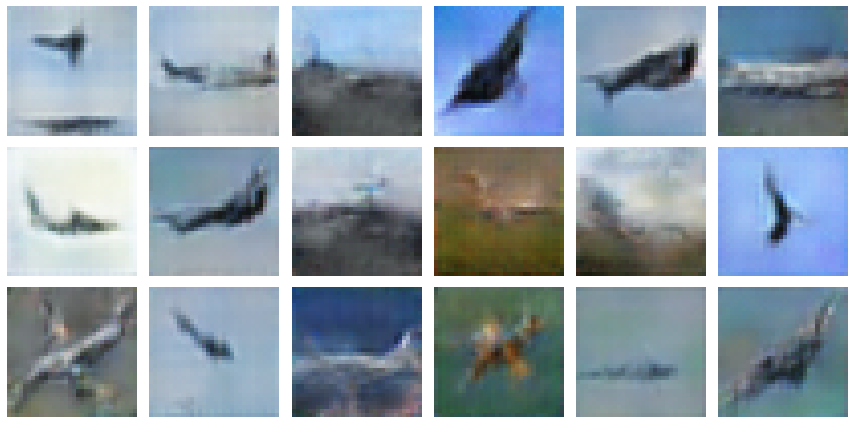

31/31 [==============================] - 148s 5s/step - g_loss: 2.5151 - d_loss: 0.3713 - real_acc: 0.8473 - gen_acc: 0.8299 - aug_p: 0.0103 - val_kid: 0.1591
Epoch 256/500
31/31 [==============================] - 141s 5s/step - g_loss: 2.5774 - d_loss: 0.3069 - real_acc: 0.8732 - gen_acc: 0.8705 - aug_p: 0.0110 - val_kid: 0.1663
Epoch 257/500
31/31 [==============================] - 150s 5s/step - g_loss: 2.7352 - d_loss: 0.2810 - real_acc: 0.8831 - gen_acc: 0.8863 - aug_p: 0.0117 - val_kid: 0.1622
Epoch 258/500
31/31 [==============================] - 143s 5s/step - g_loss: 2.9341 - d_loss: 0.2937 - real_acc: 0.8886 - gen_acc: 0.8805 - aug_p: 0.0122 - val_kid: 0.1728
Epoch 259/500
31/31 [==============================] - 169s 5s/step - g_loss: 3.2390 - d_loss: 0.3170 - real_acc: 0.8735 - gen_acc: 0.8508 - aug_p: 0.0134 - val_kid: 0.1812
Epoch 260/500
31/31 [==============================] - ETA: 0s - g_loss: 3.1839 - d_loss: 0.1984 - real_acc: 0.9254 - gen_acc: 0.9320 - aug_p: 0.0153

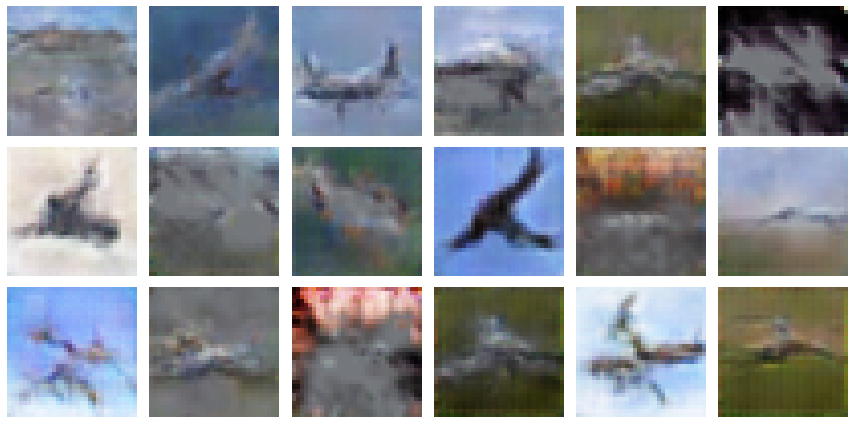

31/31 [==============================] - 172s 6s/step - g_loss: 3.1839 - d_loss: 0.1984 - real_acc: 0.9254 - gen_acc: 0.9320 - aug_p: 0.0153 - val_kid: 0.1843
Epoch 261/500
31/31 [==============================] - 167s 5s/step - g_loss: 3.2129 - d_loss: 0.3281 - real_acc: 0.8873 - gen_acc: 0.8503 - aug_p: 0.0170 - val_kid: 0.1889
Epoch 262/500
31/31 [==============================] - 166s 5s/step - g_loss: 2.8723 - d_loss: 0.2109 - real_acc: 0.9284 - gen_acc: 0.9279 - aug_p: 0.0188 - val_kid: 0.1971
Epoch 263/500
31/31 [==============================] - 166s 5s/step - g_loss: 3.6151 - d_loss: 0.2897 - real_acc: 0.8924 - gen_acc: 0.8810 - aug_p: 0.0207 - val_kid: 0.2014
Epoch 264/500
31/31 [==============================] - 169s 5s/step - g_loss: 2.9028 - d_loss: 0.2675 - real_acc: 0.8964 - gen_acc: 0.8821 - aug_p: 0.0221 - val_kid: 0.1859
Epoch 265/500
31/31 [==============================] - ETA: 0s - g_loss: 2.8542 - d_loss: 0.2903 - real_acc: 0.8742 - gen_acc: 0.8611 - aug_p: 0.0231

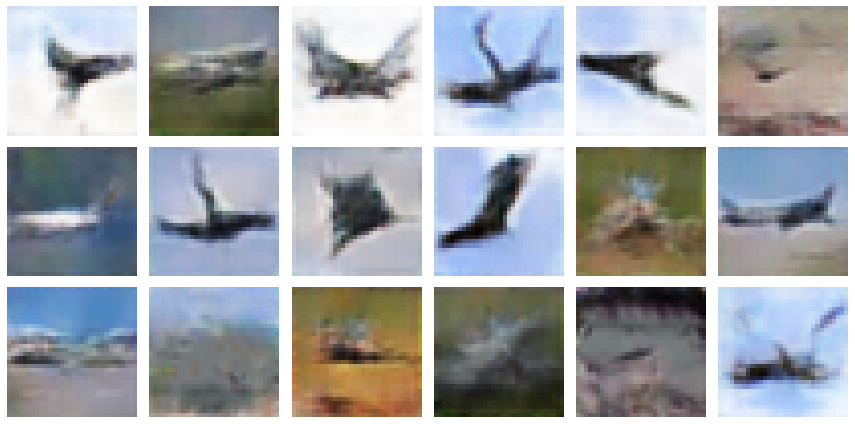

31/31 [==============================] - 179s 6s/step - g_loss: 2.8542 - d_loss: 0.2903 - real_acc: 0.8742 - gen_acc: 0.8611 - aug_p: 0.0231 - val_kid: 0.1809
Epoch 266/500
31/31 [==============================] - 197s 6s/step - g_loss: 3.0243 - d_loss: 0.3239 - real_acc: 0.8740 - gen_acc: 0.8443 - aug_p: 0.0239 - val_kid: 0.1802
Epoch 267/500
31/31 [==============================] - 186s 6s/step - g_loss: 2.9933 - d_loss: 0.2777 - real_acc: 0.8747 - gen_acc: 0.8901 - aug_p: 0.0244 - val_kid: 0.1841
Epoch 268/500
31/31 [==============================] - 187s 6s/step - g_loss: 3.0089 - d_loss: 0.2859 - real_acc: 0.9022 - gen_acc: 0.8851 - aug_p: 0.0259 - val_kid: 0.1798
Epoch 269/500
31/31 [==============================] - 173s 6s/step - g_loss: 3.0151 - d_loss: 0.2287 - real_acc: 0.9176 - gen_acc: 0.9148 - aug_p: 0.0277 - val_kid: 0.1821
Epoch 270/500
31/31 [==============================] - ETA: 0s - g_loss: 2.9173 - d_loss: 0.2980 - real_acc: 0.8780 - gen_acc: 0.8863 - aug_p: 0.0288

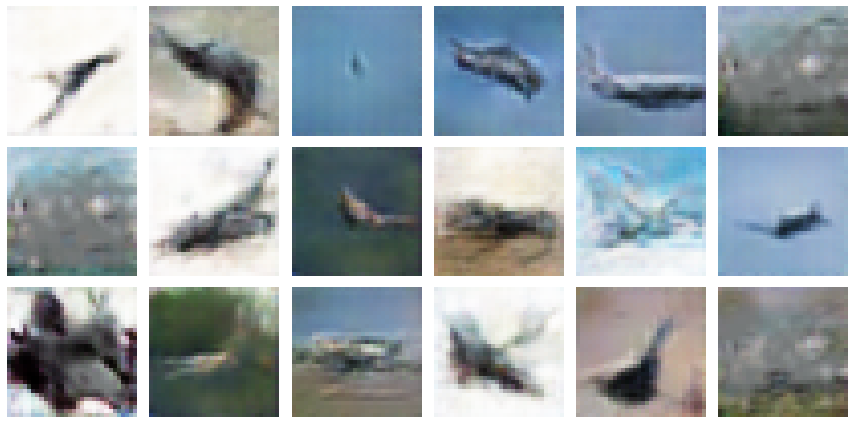

31/31 [==============================] - 184s 6s/step - g_loss: 2.9173 - d_loss: 0.2980 - real_acc: 0.8780 - gen_acc: 0.8863 - aug_p: 0.0288 - val_kid: 0.1907
Epoch 271/500
31/31 [==============================] - 183s 6s/step - g_loss: 3.4006 - d_loss: 0.2996 - real_acc: 0.8828 - gen_acc: 0.8647 - aug_p: 0.0302 - val_kid: 0.1917
Epoch 272/500
31/31 [==============================] - 170s 5s/step - g_loss: 3.3835 - d_loss: 0.2395 - real_acc: 0.9088 - gen_acc: 0.8972 - aug_p: 0.0316 - val_kid: 0.2020
Epoch 273/500
31/31 [==============================] - 183s 6s/step - g_loss: 3.2446 - d_loss: 0.2510 - real_acc: 0.8987 - gen_acc: 0.9022 - aug_p: 0.0335 - val_kid: 0.2035
Epoch 274/500
31/31 [==============================] - 187s 6s/step - g_loss: 3.3735 - d_loss: 0.2776 - real_acc: 0.8813 - gen_acc: 0.8740 - aug_p: 0.0345 - val_kid: 0.1948
Epoch 275/500
31/31 [==============================] - ETA: 0s - g_loss: 3.4613 - d_loss: 0.2665 - real_acc: 0.9065 - gen_acc: 0.8881 - aug_p: 0.0358

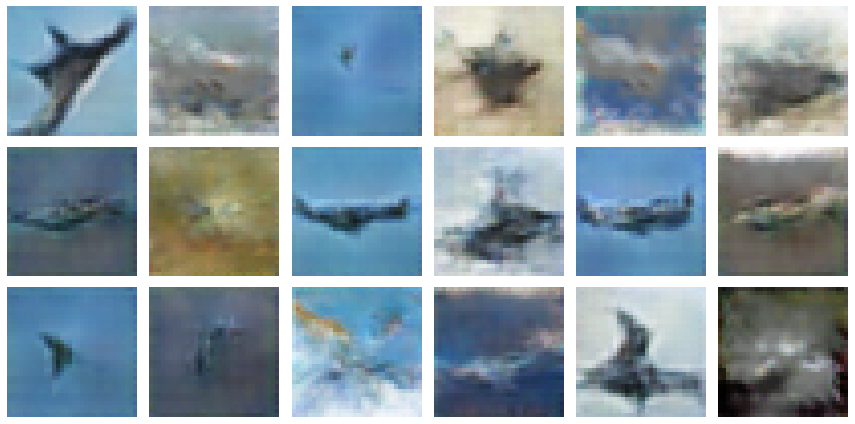

31/31 [==============================] - 190s 6s/step - g_loss: 3.4613 - d_loss: 0.2665 - real_acc: 0.9065 - gen_acc: 0.8881 - aug_p: 0.0358 - val_kid: 0.1993
Epoch 276/500
31/31 [==============================] - 185s 6s/step - g_loss: 2.9764 - d_loss: 0.2524 - real_acc: 0.8947 - gen_acc: 0.9042 - aug_p: 0.0376 - val_kid: 0.2058
Epoch 277/500
31/31 [==============================] - 180s 6s/step - g_loss: 2.7875 - d_loss: 0.2762 - real_acc: 0.9183 - gen_acc: 0.8876 - aug_p: 0.0388 - val_kid: 0.2061
Epoch 278/500
31/31 [==============================] - 213s 7s/step - g_loss: 3.2257 - d_loss: 0.2225 - real_acc: 0.9173 - gen_acc: 0.9173 - aug_p: 0.0414 - val_kid: 0.2043
Epoch 279/500
31/31 [==============================] - 213s 7s/step - g_loss: 3.2246 - d_loss: 0.3011 - real_acc: 0.8778 - gen_acc: 0.8566 - aug_p: 0.0428 - val_kid: 0.1938
Epoch 280/500
31/31 [==============================] - ETA: 0s - g_loss: 3.0078 - d_loss: 0.2353 - real_acc: 0.9176 - gen_acc: 0.9080 - aug_p: 0.0440

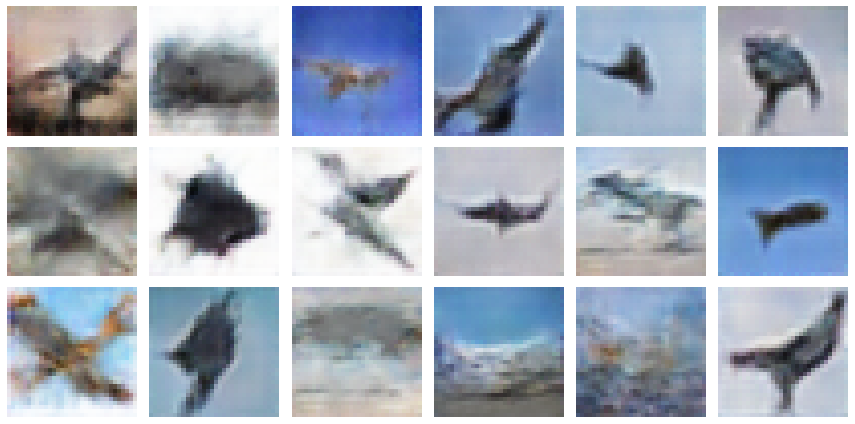

31/31 [==============================] - 210s 7s/step - g_loss: 3.0078 - d_loss: 0.2353 - real_acc: 0.9176 - gen_acc: 0.9080 - aug_p: 0.0440 - val_kid: 0.1849
Epoch 281/500
31/31 [==============================] - 193s 6s/step - g_loss: 3.2772 - d_loss: 0.3788 - real_acc: 0.8561 - gen_acc: 0.8359 - aug_p: 0.0449 - val_kid: 0.1915
Epoch 282/500
31/31 [==============================] - 181s 6s/step - g_loss: 3.0844 - d_loss: 0.3014 - real_acc: 0.8795 - gen_acc: 0.8667 - aug_p: 0.0462 - val_kid: 0.2007
Epoch 283/500
31/31 [==============================] - 181s 6s/step - g_loss: 2.9168 - d_loss: 0.2593 - real_acc: 0.8884 - gen_acc: 0.8967 - aug_p: 0.0470 - val_kid: 0.2025
Epoch 284/500
31/31 [==============================] - 184s 6s/step - g_loss: 3.2654 - d_loss: 0.2159 - real_acc: 0.9211 - gen_acc: 0.9204 - aug_p: 0.0486 - val_kid: 0.1903
Epoch 285/500
31/31 [==============================] - ETA: 0s - g_loss: 3.3272 - d_loss: 0.2200 - real_acc: 0.9226 - gen_acc: 0.9156 - aug_p: 0.0512

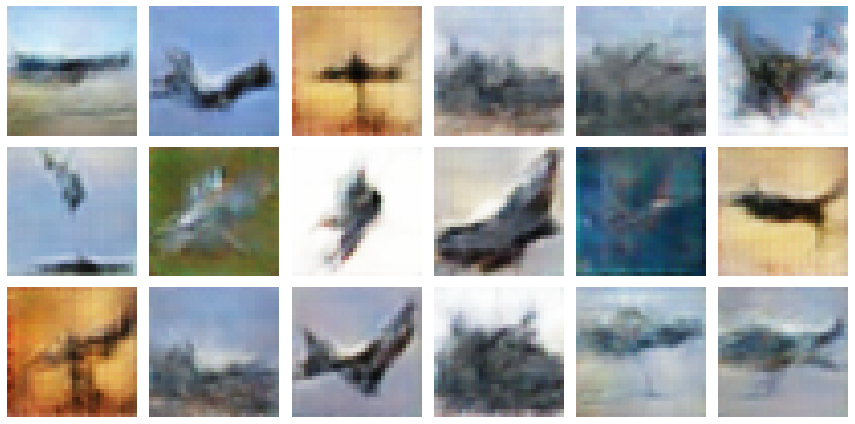

31/31 [==============================] - 212s 7s/step - g_loss: 3.3272 - d_loss: 0.2200 - real_acc: 0.9226 - gen_acc: 0.9156 - aug_p: 0.0512 - val_kid: 0.1950
Epoch 286/500
31/31 [==============================] - 176s 6s/step - g_loss: 3.3478 - d_loss: 0.2610 - real_acc: 0.9022 - gen_acc: 0.8773 - aug_p: 0.0530 - val_kid: 0.1938
Epoch 287/500
31/31 [==============================] - 177s 6s/step - g_loss: 3.2274 - d_loss: 0.2223 - real_acc: 0.9128 - gen_acc: 0.9115 - aug_p: 0.0547 - val_kid: 0.1941
Epoch 288/500
31/31 [==============================] - 182s 6s/step - g_loss: 3.7123 - d_loss: 0.2970 - real_acc: 0.8750 - gen_acc: 0.8705 - aug_p: 0.0559 - val_kid: 0.2017
Epoch 289/500
31/31 [==============================] - 179s 6s/step - g_loss: 2.9807 - d_loss: 0.2785 - real_acc: 0.8884 - gen_acc: 0.8816 - aug_p: 0.0571 - val_kid: 0.1850
Epoch 290/500
31/31 [==============================] - ETA: 0s - g_loss: 3.3874 - d_loss: 0.2461 - real_acc: 0.9068 - gen_acc: 0.9062 - aug_p: 0.0584

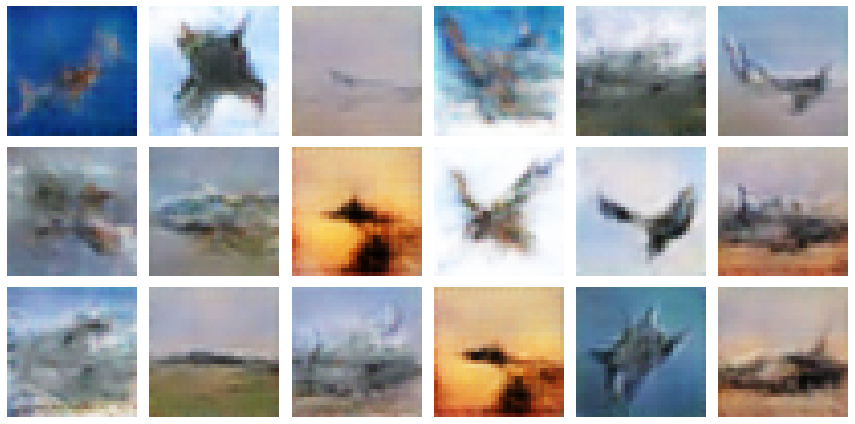

31/31 [==============================] - 191s 6s/step - g_loss: 3.3874 - d_loss: 0.2461 - real_acc: 0.9068 - gen_acc: 0.9062 - aug_p: 0.0584 - val_kid: 0.1751
Epoch 291/500
31/31 [==============================] - 179s 6s/step - g_loss: 3.0816 - d_loss: 0.2763 - real_acc: 0.8876 - gen_acc: 0.8793 - aug_p: 0.0595 - val_kid: 0.1731
Epoch 292/500
31/31 [==============================] - 186s 6s/step - g_loss: 3.4010 - d_loss: 0.2602 - real_acc: 0.9052 - gen_acc: 0.8989 - aug_p: 0.0616 - val_kid: 0.1693
Epoch 293/500
31/31 [==============================] - 188s 6s/step - g_loss: 3.2296 - d_loss: 0.2238 - real_acc: 0.9254 - gen_acc: 0.9002 - aug_p: 0.0632 - val_kid: 0.1689
Epoch 294/500
31/31 [==============================] - 169s 5s/step - g_loss: 3.7633 - d_loss: 0.2930 - real_acc: 0.8747 - gen_acc: 0.8722 - aug_p: 0.0648 - val_kid: 0.1644
Epoch 295/500
31/31 [==============================] - ETA: 0s - g_loss: 3.4435 - d_loss: 0.2415 - real_acc: 0.9123 - gen_acc: 0.8984 - aug_p: 0.0663

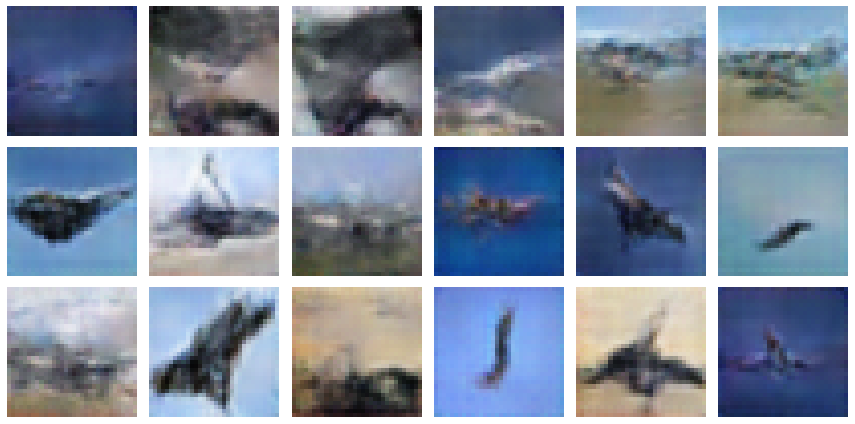

31/31 [==============================] - 160s 5s/step - g_loss: 3.4435 - d_loss: 0.2415 - real_acc: 0.9123 - gen_acc: 0.8984 - aug_p: 0.0663 - val_kid: 0.1679
Epoch 296/500
31/31 [==============================] - 166s 5s/step - g_loss: 3.0688 - d_loss: 0.2345 - real_acc: 0.9113 - gen_acc: 0.9078 - aug_p: 0.0682 - val_kid: 0.1730
Epoch 297/500
31/31 [==============================] - 156s 5s/step - g_loss: 3.3697 - d_loss: 0.2178 - real_acc: 0.9110 - gen_acc: 0.9098 - aug_p: 0.0701 - val_kid: 0.1729
Epoch 298/500
31/31 [==============================] - 158s 5s/step - g_loss: 3.3201 - d_loss: 0.2649 - real_acc: 0.8921 - gen_acc: 0.8949 - aug_p: 0.0712 - val_kid: 0.1720
Epoch 299/500
31/31 [==============================] - 167s 5s/step - g_loss: 3.3605 - d_loss: 0.2148 - real_acc: 0.9254 - gen_acc: 0.9194 - aug_p: 0.0737 - val_kid: 0.1607
Epoch 300/500
31/31 [==============================] - ETA: 0s - g_loss: 3.2005 - d_loss: 0.2114 - real_acc: 0.9189 - gen_acc: 0.9173 - aug_p: 0.0757

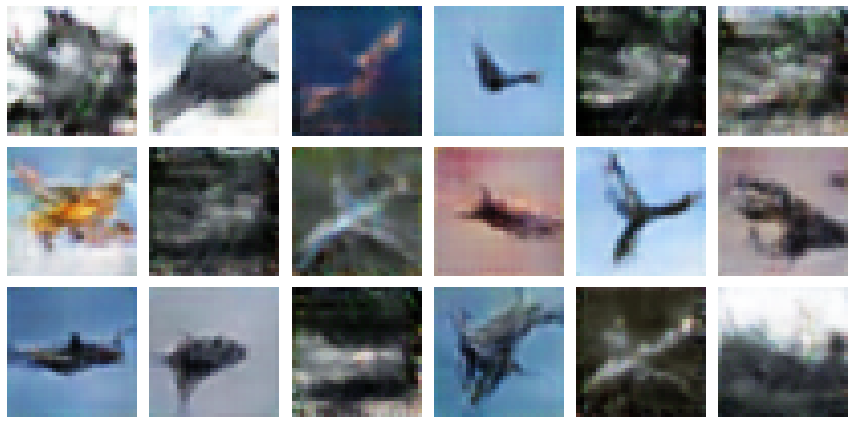

31/31 [==============================] - 184s 6s/step - g_loss: 3.2005 - d_loss: 0.2114 - real_acc: 0.9189 - gen_acc: 0.9173 - aug_p: 0.0757 - val_kid: 0.1618
Epoch 301/500
31/31 [==============================] - 182s 6s/step - g_loss: 3.3759 - d_loss: 0.2586 - real_acc: 0.9060 - gen_acc: 0.8863 - aug_p: 0.0774 - val_kid: 0.1570
Epoch 302/500
31/31 [==============================] - 189s 6s/step - g_loss: 3.6371 - d_loss: 0.3047 - real_acc: 0.8803 - gen_acc: 0.8621 - aug_p: 0.0787 - val_kid: 0.1541
Epoch 303/500
31/31 [==============================] - 194s 6s/step - g_loss: 2.9926 - d_loss: 0.2587 - real_acc: 0.9015 - gen_acc: 0.8916 - aug_p: 0.0801 - val_kid: 0.1538
Epoch 304/500
31/31 [==============================] - 199s 6s/step - g_loss: 3.1881 - d_loss: 0.2993 - real_acc: 0.8863 - gen_acc: 0.8760 - aug_p: 0.0816 - val_kid: 0.1514
Epoch 305/500
31/31 [==============================] - ETA: 0s - g_loss: 3.5335 - d_loss: 0.2490 - real_acc: 0.9133 - gen_acc: 0.8909 - aug_p: 0.0831

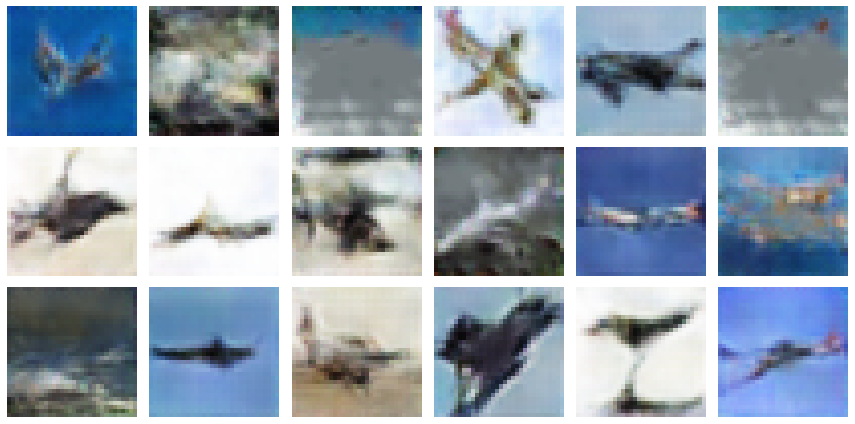

31/31 [==============================] - 213s 7s/step - g_loss: 3.5335 - d_loss: 0.2490 - real_acc: 0.9133 - gen_acc: 0.8909 - aug_p: 0.0831 - val_kid: 0.1400
Epoch 306/500
31/31 [==============================] - 217s 7s/step - g_loss: 3.6388 - d_loss: 0.2537 - real_acc: 0.8997 - gen_acc: 0.8969 - aug_p: 0.0849 - val_kid: 0.1629
Epoch 307/500
31/31 [==============================] - 158s 5s/step - g_loss: 3.5974 - d_loss: 0.2141 - real_acc: 0.9330 - gen_acc: 0.9055 - aug_p: 0.0870 - val_kid: 0.1628
Epoch 308/500
31/31 [==============================] - 157s 5s/step - g_loss: 3.0433 - d_loss: 0.2949 - real_acc: 0.8745 - gen_acc: 0.8765 - aug_p: 0.0883 - val_kid: 0.1764
Epoch 309/500
31/31 [==============================] - 150s 5s/step - g_loss: 3.2486 - d_loss: 0.2359 - real_acc: 0.9002 - gen_acc: 0.9035 - aug_p: 0.0898 - val_kid: 0.1692
Epoch 310/500
31/31 [==============================] - ETA: 0s - g_loss: 3.3840 - d_loss: 0.2521 - real_acc: 0.9156 - gen_acc: 0.9078 - aug_p: 0.0914

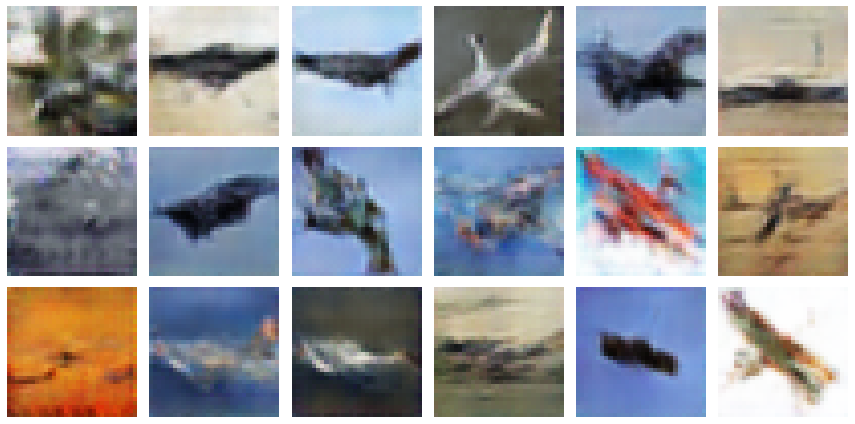

31/31 [==============================] - 158s 5s/step - g_loss: 3.3840 - d_loss: 0.2521 - real_acc: 0.9156 - gen_acc: 0.9078 - aug_p: 0.0914 - val_kid: 0.1686
Epoch 311/500
31/31 [==============================] - 148s 5s/step - g_loss: 3.6034 - d_loss: 0.2842 - real_acc: 0.8823 - gen_acc: 0.8755 - aug_p: 0.0930 - val_kid: 0.1628
Epoch 312/500
31/31 [==============================] - 149s 5s/step - g_loss: 3.3808 - d_loss: 0.2767 - real_acc: 0.8848 - gen_acc: 0.8687 - aug_p: 0.0944 - val_kid: 0.1677
Epoch 313/500
31/31 [==============================] - 153s 5s/step - g_loss: 3.7003 - d_loss: 0.2462 - real_acc: 0.9078 - gen_acc: 0.8843 - aug_p: 0.0953 - val_kid: 0.1631
Epoch 314/500
31/31 [==============================] - 147s 5s/step - g_loss: 3.3685 - d_loss: 0.1790 - real_acc: 0.9380 - gen_acc: 0.9430 - aug_p: 0.0979 - val_kid: 0.1652
Epoch 315/500
31/31 [==============================] - ETA: 0s - g_loss: 3.4638 - d_loss: 0.2603 - real_acc: 0.9126 - gen_acc: 0.8805 - aug_p: 0.1001

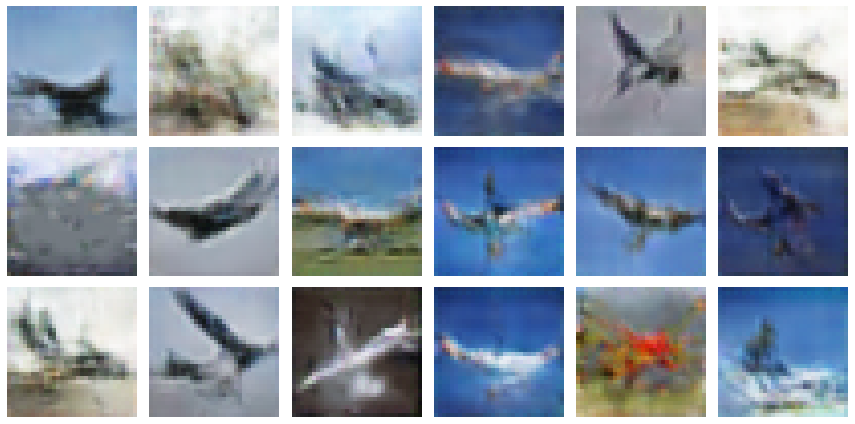

31/31 [==============================] - 156s 5s/step - g_loss: 3.4638 - d_loss: 0.2603 - real_acc: 0.9126 - gen_acc: 0.8805 - aug_p: 0.1001 - val_kid: 0.1564
Epoch 316/500
31/31 [==============================] - 148s 5s/step - g_loss: 3.6486 - d_loss: 0.2174 - real_acc: 0.9070 - gen_acc: 0.9214 - aug_p: 0.1023 - val_kid: 0.1617
Epoch 317/500
31/31 [==============================] - 150s 5s/step - g_loss: 3.9139 - d_loss: 0.2379 - real_acc: 0.9216 - gen_acc: 0.8863 - aug_p: 0.1039 - val_kid: 0.1576
Epoch 318/500
31/31 [==============================] - 149s 5s/step - g_loss: 3.8192 - d_loss: 0.3422 - real_acc: 0.8684 - gen_acc: 0.8415 - aug_p: 0.1052 - val_kid: 0.1702
Epoch 319/500
31/31 [==============================] - 148s 5s/step - g_loss: 3.4556 - d_loss: 0.1921 - real_acc: 0.9398 - gen_acc: 0.9206 - aug_p: 0.1070 - val_kid: 0.1681
Epoch 320/500
31/31 [==============================] - ETA: 0s - g_loss: 3.3790 - d_loss: 0.2024 - real_acc: 0.9264 - gen_acc: 0.9267 - aug_p: 0.1096

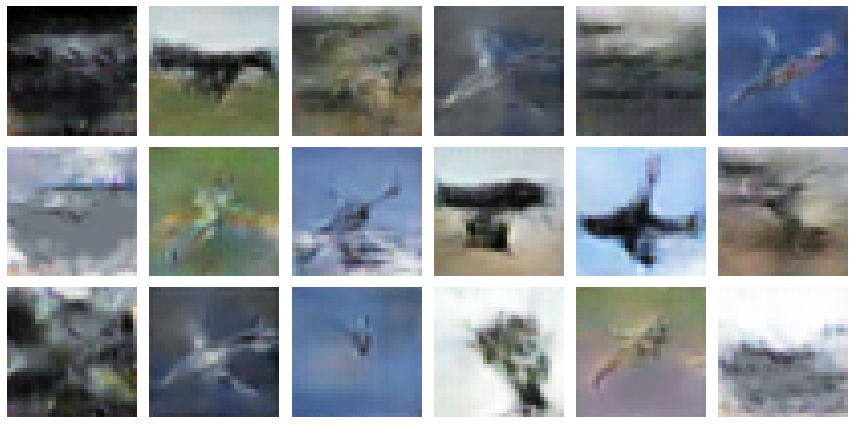

31/31 [==============================] - 153s 5s/step - g_loss: 3.3790 - d_loss: 0.2024 - real_acc: 0.9264 - gen_acc: 0.9267 - aug_p: 0.1096 - val_kid: 0.1599
Epoch 321/500
31/31 [==============================] - 148s 5s/step - g_loss: 3.2221 - d_loss: 0.2198 - real_acc: 0.9032 - gen_acc: 0.9214 - aug_p: 0.1117 - val_kid: 0.1586
Epoch 322/500
31/31 [==============================] - 149s 5s/step - g_loss: 3.4972 - d_loss: 0.2206 - real_acc: 0.9262 - gen_acc: 0.9206 - aug_p: 0.1137 - val_kid: 0.1716
Epoch 323/500
31/31 [==============================] - 157s 5s/step - g_loss: 3.5568 - d_loss: 0.2236 - real_acc: 0.9105 - gen_acc: 0.9055 - aug_p: 0.1160 - val_kid: 0.1668
Epoch 324/500
31/31 [==============================] - 208s 7s/step - g_loss: 3.5809 - d_loss: 0.1917 - real_acc: 0.9239 - gen_acc: 0.9269 - aug_p: 0.1179 - val_kid: 0.1421
Epoch 325/500
31/31 [==============================] - ETA: 0s - g_loss: 3.6312 - d_loss: 0.2134 - real_acc: 0.9199 - gen_acc: 0.9115 - aug_p: 0.1202

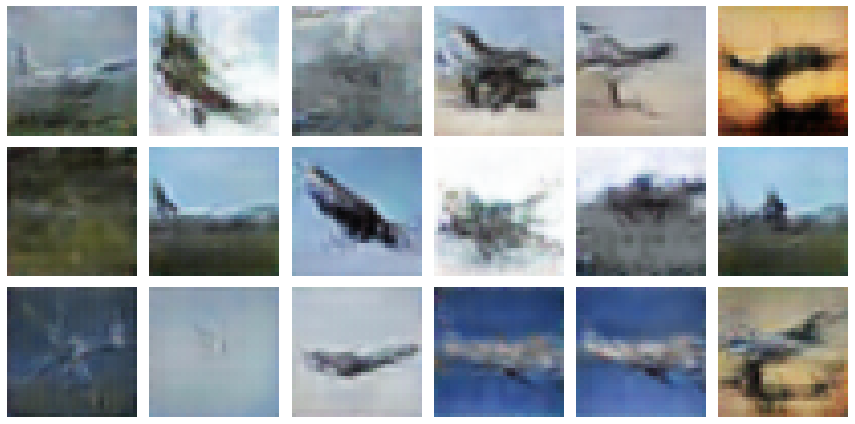

31/31 [==============================] - 2091s 69s/step - g_loss: 3.6312 - d_loss: 0.2134 - real_acc: 0.9199 - gen_acc: 0.9115 - aug_p: 0.1202 - val_kid: 0.1563
Epoch 326/500
31/31 [==============================] - 140s 4s/step - g_loss: 3.7640 - d_loss: 0.2241 - real_acc: 0.9168 - gen_acc: 0.9017 - aug_p: 0.1225 - val_kid: 0.1554
Epoch 327/500
31/31 [==============================] - 164s 5s/step - g_loss: 3.8122 - d_loss: 0.2770 - real_acc: 0.8924 - gen_acc: 0.8952 - aug_p: 0.1244 - val_kid: 0.1521
Epoch 328/500
31/31 [==============================] - 169s 5s/step - g_loss: 3.4608 - d_loss: 0.2656 - real_acc: 0.8997 - gen_acc: 0.8717 - aug_p: 0.1254 - val_kid: 0.1545
Epoch 329/500
31/31 [==============================] - 187s 6s/step - g_loss: 3.2798 - d_loss: 0.2168 - real_acc: 0.9244 - gen_acc: 0.9115 - aug_p: 0.1270 - val_kid: 0.1634
Epoch 330/500
31/31 [==============================] - ETA: 0s - g_loss: 3.6820 - d_loss: 0.2212 - real_acc: 0.9229 - gen_acc: 0.9065 - aug_p: 0.12

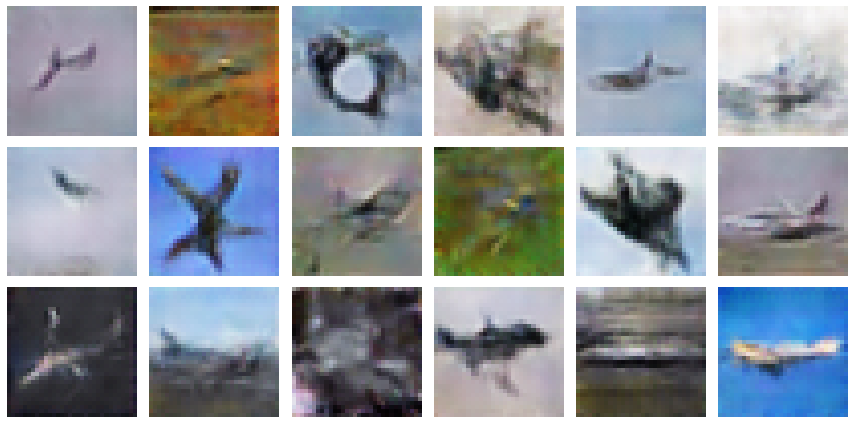

31/31 [==============================] - 247s 8s/step - g_loss: 3.6820 - d_loss: 0.2212 - real_acc: 0.9229 - gen_acc: 0.9065 - aug_p: 0.1295 - val_kid: 0.1577
Epoch 331/500
31/31 [==============================] - 250s 8s/step - g_loss: 3.3537 - d_loss: 0.2230 - real_acc: 0.9206 - gen_acc: 0.9196 - aug_p: 0.1317 - val_kid: 0.1640
Epoch 332/500
31/31 [==============================] - 251s 8s/step - g_loss: 3.8352 - d_loss: 0.2823 - real_acc: 0.9012 - gen_acc: 0.8818 - aug_p: 0.1337 - val_kid: 0.1568
Epoch 333/500
31/31 [==============================] - 201s 7s/step - g_loss: 3.3157 - d_loss: 0.2461 - real_acc: 0.9052 - gen_acc: 0.8947 - aug_p: 0.1352 - val_kid: 0.1584
Epoch 334/500
31/31 [==============================] - 235s 7s/step - g_loss: 4.4339 - d_loss: 0.1766 - real_acc: 0.9345 - gen_acc: 0.9299 - aug_p: 0.1376 - val_kid: 0.1447
Epoch 335/500
31/31 [==============================] - ETA: 0s - g_loss: 3.8692 - d_loss: 0.2780 - real_acc: 0.8957 - gen_acc: 0.8642 - aug_p: 0.1397

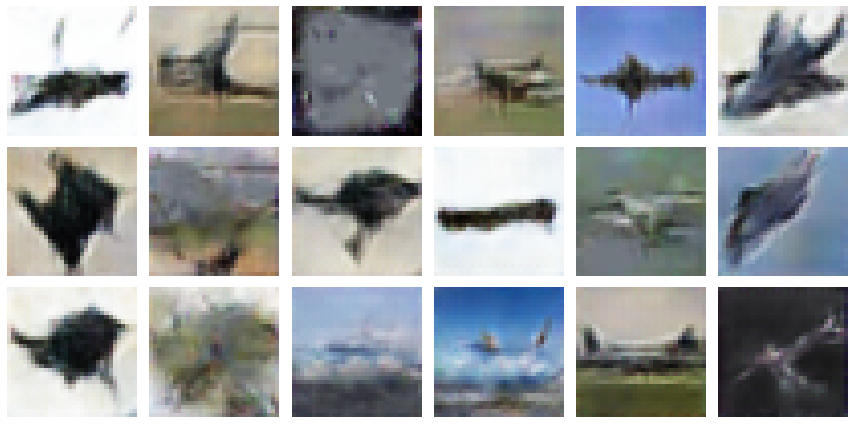

31/31 [==============================] - 233s 8s/step - g_loss: 3.8692 - d_loss: 0.2780 - real_acc: 0.8957 - gen_acc: 0.8642 - aug_p: 0.1397 - val_kid: 0.1509
Epoch 336/500
31/31 [==============================] - 131s 4s/step - g_loss: 3.8935 - d_loss: 0.2423 - real_acc: 0.9073 - gen_acc: 0.8984 - aug_p: 0.1410 - val_kid: 0.1629
Epoch 337/500
31/31 [==============================] - 138s 4s/step - g_loss: 3.4855 - d_loss: 0.1745 - real_acc: 0.9408 - gen_acc: 0.9360 - aug_p: 0.1434 - val_kid: 0.1617
Epoch 338/500
31/31 [==============================] - 141s 5s/step - g_loss: 3.7912 - d_loss: 0.2812 - real_acc: 0.8901 - gen_acc: 0.8654 - aug_p: 0.1453 - val_kid: 0.1591
Epoch 339/500
31/31 [==============================] - 137s 4s/step - g_loss: 3.5986 - d_loss: 0.2038 - real_acc: 0.9330 - gen_acc: 0.9100 - aug_p: 0.1473 - val_kid: 0.1459
Epoch 340/500
31/31 [==============================] - ETA: 0s - g_loss: 4.0462 - d_loss: 0.2271 - real_acc: 0.9080 - gen_acc: 0.9030 - aug_p: 0.1496

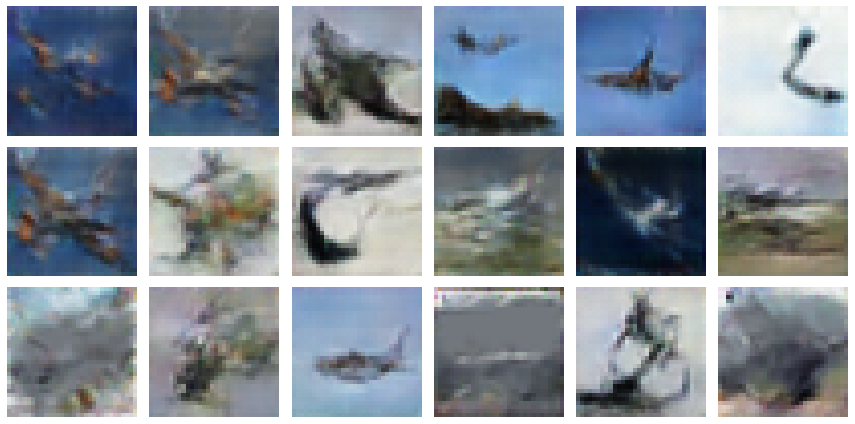

31/31 [==============================] - 115s 4s/step - g_loss: 4.0462 - d_loss: 0.2271 - real_acc: 0.9080 - gen_acc: 0.9030 - aug_p: 0.1496 - val_kid: 0.1530
Epoch 341/500
31/31 [==============================] - 137s 4s/step - g_loss: 3.5620 - d_loss: 0.2116 - real_acc: 0.9211 - gen_acc: 0.9151 - aug_p: 0.1513 - val_kid: 0.1524
Epoch 342/500
31/31 [==============================] - 123s 4s/step - g_loss: 3.8597 - d_loss: 0.2632 - real_acc: 0.8979 - gen_acc: 0.8889 - aug_p: 0.1535 - val_kid: 0.1464
Epoch 343/500
31/31 [==============================] - 131s 4s/step - g_loss: 3.4908 - d_loss: 0.2532 - real_acc: 0.9012 - gen_acc: 0.8871 - aug_p: 0.1549 - val_kid: 0.1522
Epoch 344/500
31/31 [==============================] - 137s 4s/step - g_loss: 3.7354 - d_loss: 0.2137 - real_acc: 0.9156 - gen_acc: 0.9068 - aug_p: 0.1568 - val_kid: 0.1566
Epoch 345/500
31/31 [==============================] - ETA: 0s - g_loss: 3.5965 - d_loss: 0.2125 - real_acc: 0.9108 - gen_acc: 0.9178 - aug_p: 0.1586

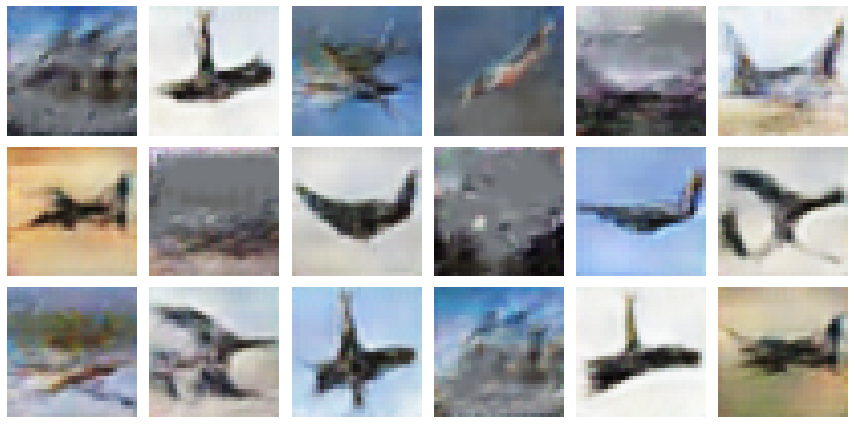

31/31 [==============================] - 118s 4s/step - g_loss: 3.5965 - d_loss: 0.2125 - real_acc: 0.9108 - gen_acc: 0.9178 - aug_p: 0.1586 - val_kid: 0.1529
Epoch 346/500
31/31 [==============================] - 138s 4s/step - g_loss: 3.9374 - d_loss: 0.2485 - real_acc: 0.9088 - gen_acc: 0.8856 - aug_p: 0.1603 - val_kid: 0.1533
Epoch 347/500
31/31 [==============================] - 142s 5s/step - g_loss: 3.5655 - d_loss: 0.2737 - real_acc: 0.8994 - gen_acc: 0.8851 - aug_p: 0.1622 - val_kid: 0.1581
Epoch 348/500
31/31 [==============================] - 132s 4s/step - g_loss: 3.6112 - d_loss: 0.1702 - real_acc: 0.9395 - gen_acc: 0.9441 - aug_p: 0.1641 - val_kid: 0.1586
Epoch 349/500
31/31 [==============================] - 122s 4s/step - g_loss: 3.7940 - d_loss: 0.2170 - real_acc: 0.9057 - gen_acc: 0.9088 - aug_p: 0.1666 - val_kid: 0.1644
Epoch 350/500
31/31 [==============================] - ETA: 0s - g_loss: 3.5899 - d_loss: 0.1870 - real_acc: 0.9312 - gen_acc: 0.9345 - aug_p: 0.1685

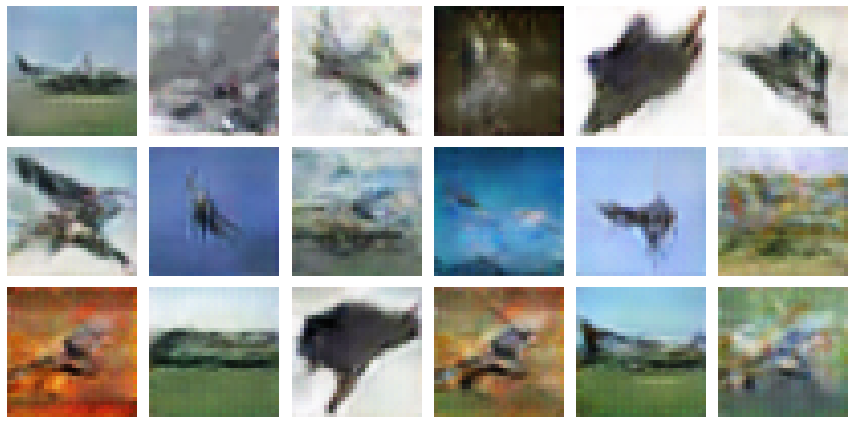

31/31 [==============================] - 138s 5s/step - g_loss: 3.5899 - d_loss: 0.1870 - real_acc: 0.9312 - gen_acc: 0.9345 - aug_p: 0.1685 - val_kid: 0.1582
Epoch 351/500
31/31 [==============================] - 140s 5s/step - g_loss: 3.8681 - d_loss: 0.2426 - real_acc: 0.9042 - gen_acc: 0.9057 - aug_p: 0.1710 - val_kid: 0.1683
Epoch 352/500
31/31 [==============================] - 132s 4s/step - g_loss: 3.3425 - d_loss: 0.2377 - real_acc: 0.9110 - gen_acc: 0.9123 - aug_p: 0.1723 - val_kid: 0.1664
Epoch 353/500
31/31 [==============================] - 136s 4s/step - g_loss: 4.1142 - d_loss: 0.2031 - real_acc: 0.9224 - gen_acc: 0.9123 - aug_p: 0.1744 - val_kid: 0.1782
Epoch 354/500
31/31 [==============================] - 141s 5s/step - g_loss: 3.8778 - d_loss: 0.2137 - real_acc: 0.9196 - gen_acc: 0.9100 - aug_p: 0.1769 - val_kid: 0.1884
Epoch 355/500
31/31 [==============================] - ETA: 0s - g_loss: 4.3378 - d_loss: 0.2152 - real_acc: 0.9257 - gen_acc: 0.9163 - aug_p: 0.1792

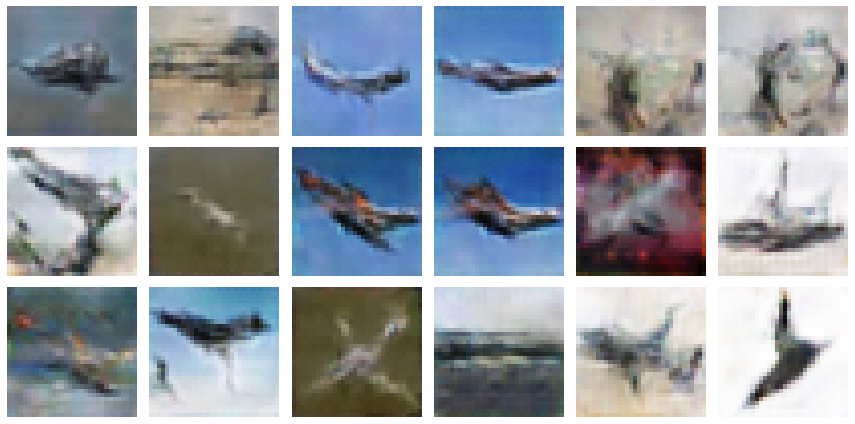

31/31 [==============================] - 137s 4s/step - g_loss: 4.3378 - d_loss: 0.2152 - real_acc: 0.9257 - gen_acc: 0.9163 - aug_p: 0.1792 - val_kid: 0.1791
Epoch 356/500
31/31 [==============================] - 120s 4s/step - g_loss: 3.9473 - d_loss: 0.1645 - real_acc: 0.9388 - gen_acc: 0.9380 - aug_p: 0.1817 - val_kid: 0.1831
Epoch 357/500
31/31 [==============================] - 138s 5s/step - g_loss: 4.5115 - d_loss: 0.2210 - real_acc: 0.9183 - gen_acc: 0.8984 - aug_p: 0.1839 - val_kid: 0.1858
Epoch 358/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.2926 - d_loss: 0.1732 - real_acc: 0.9322 - gen_acc: 0.9325 - aug_p: 0.1866 - val_kid: 0.1913
Epoch 359/500
31/31 [==============================] - 148s 5s/step - g_loss: 4.2008 - d_loss: 0.1885 - real_acc: 0.9342 - gen_acc: 0.9166 - aug_p: 0.1892 - val_kid: 0.1876
Epoch 360/500
31/31 [==============================] - ETA: 0s - g_loss: 3.6515 - d_loss: 0.1623 - real_acc: 0.9446 - gen_acc: 0.9461 - aug_p: 0.1916

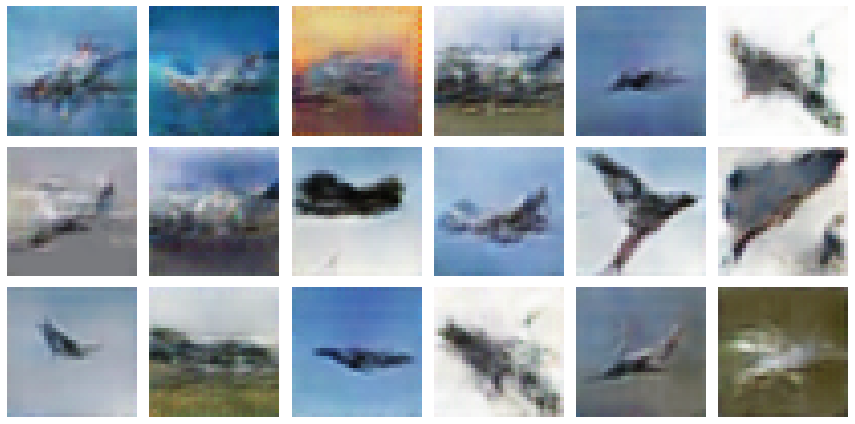

31/31 [==============================] - 146s 5s/step - g_loss: 3.6515 - d_loss: 0.1623 - real_acc: 0.9446 - gen_acc: 0.9461 - aug_p: 0.1916 - val_kid: 0.1727
Epoch 361/500
31/31 [==============================] - 154s 5s/step - g_loss: 4.0346 - d_loss: 0.1552 - real_acc: 0.9488 - gen_acc: 0.9342 - aug_p: 0.1947 - val_kid: 0.1655
Epoch 362/500
31/31 [==============================] - 125s 4s/step - g_loss: 4.5402 - d_loss: 0.2420 - real_acc: 0.9201 - gen_acc: 0.8904 - aug_p: 0.1971 - val_kid: 0.1688
Epoch 363/500
31/31 [==============================] - 147s 4s/step - g_loss: 3.8891 - d_loss: 0.1604 - real_acc: 0.9433 - gen_acc: 0.9408 - aug_p: 0.2000 - val_kid: 0.1665
Epoch 364/500
31/31 [==============================] - 145s 4s/step - g_loss: 4.1399 - d_loss: 0.1591 - real_acc: 0.9380 - gen_acc: 0.9413 - aug_p: 0.2027 - val_kid: 0.1625
Epoch 365/500
31/31 [==============================] - ETA: 0s - g_loss: 4.2493 - d_loss: 0.1679 - real_acc: 0.9304 - gen_acc: 0.9352 - aug_p: 0.2053

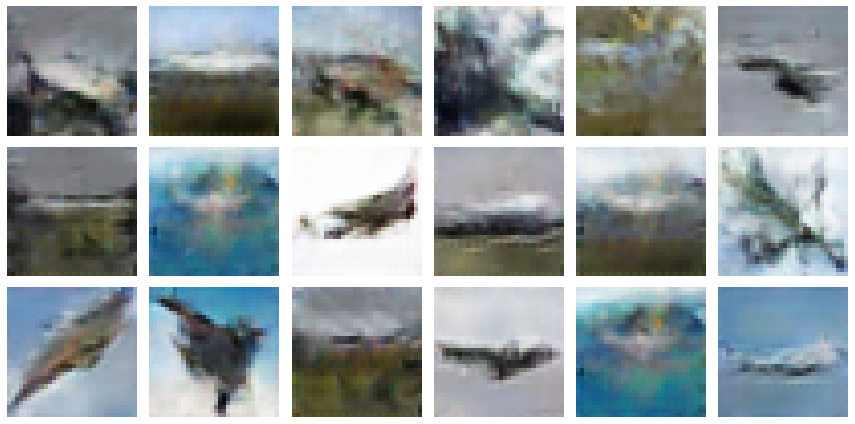

31/31 [==============================] - 144s 5s/step - g_loss: 4.2493 - d_loss: 0.1679 - real_acc: 0.9304 - gen_acc: 0.9352 - aug_p: 0.2053 - val_kid: 0.1737
Epoch 366/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.2326 - d_loss: 0.2011 - real_acc: 0.9294 - gen_acc: 0.9098 - aug_p: 0.2079 - val_kid: 0.1740
Epoch 367/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.3255 - d_loss: 0.1352 - real_acc: 0.9556 - gen_acc: 0.9478 - aug_p: 0.2107 - val_kid: 0.1689
Epoch 368/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.2208 - d_loss: 0.2411 - real_acc: 0.9007 - gen_acc: 0.8962 - aug_p: 0.2130 - val_kid: 0.1609
Epoch 369/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.4775 - d_loss: 0.1458 - real_acc: 0.9441 - gen_acc: 0.9486 - aug_p: 0.2153 - val_kid: 0.1688
Epoch 370/500
31/31 [==============================] - ETA: 0s - g_loss: 4.4683 - d_loss: 0.1404 - real_acc: 0.9438 - gen_acc: 0.9476 - aug_p: 0.2184

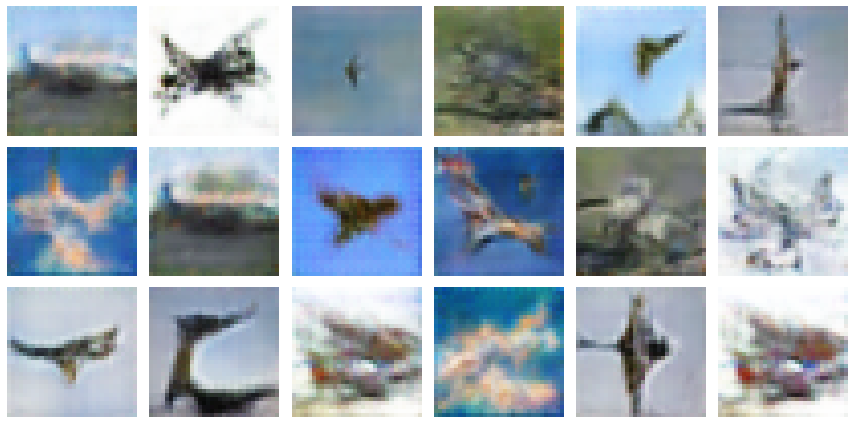

31/31 [==============================] - 149s 5s/step - g_loss: 4.4683 - d_loss: 0.1404 - real_acc: 0.9438 - gen_acc: 0.9476 - aug_p: 0.2184 - val_kid: 0.1830
Epoch 371/500
31/31 [==============================] - 128s 4s/step - g_loss: 4.3904 - d_loss: 0.1213 - real_acc: 0.9567 - gen_acc: 0.9607 - aug_p: 0.2212 - val_kid: 0.2002
Epoch 372/500
31/31 [==============================] - 143s 4s/step - g_loss: 5.3195 - d_loss: 0.2358 - real_acc: 0.9277 - gen_acc: 0.9246 - aug_p: 0.2242 - val_kid: 0.2008
Epoch 373/500
31/31 [==============================] - 147s 4s/step - g_loss: 4.7023 - d_loss: 0.2702 - real_acc: 0.9100 - gen_acc: 0.8944 - aug_p: 0.2261 - val_kid: 0.1988
Epoch 374/500
31/31 [==============================] - 145s 5s/step - g_loss: 3.8784 - d_loss: 0.2201 - real_acc: 0.9231 - gen_acc: 0.9171 - aug_p: 0.2284 - val_kid: 0.1930
Epoch 375/500
31/31 [==============================] - ETA: 0s - g_loss: 3.8435 - d_loss: 0.1717 - real_acc: 0.9400 - gen_acc: 0.9398 - aug_p: 0.2312

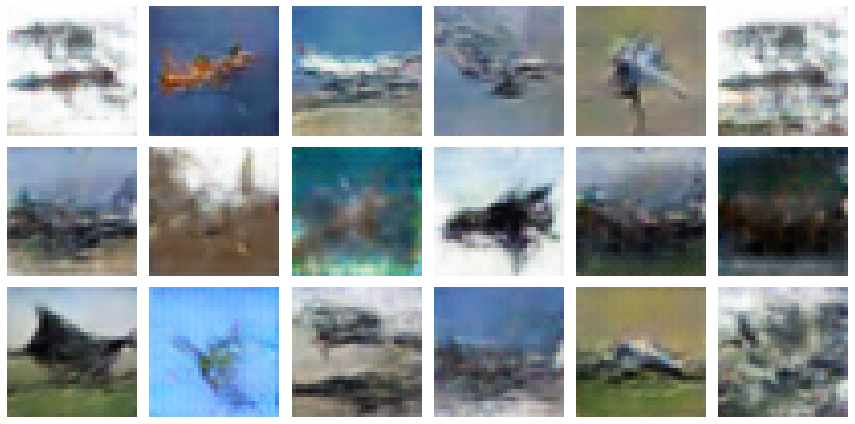

31/31 [==============================] - 145s 5s/step - g_loss: 3.8435 - d_loss: 0.1717 - real_acc: 0.9400 - gen_acc: 0.9398 - aug_p: 0.2312 - val_kid: 0.1821
Epoch 376/500
31/31 [==============================] - 145s 5s/step - g_loss: 4.0440 - d_loss: 0.1358 - real_acc: 0.9549 - gen_acc: 0.9511 - aug_p: 0.2341 - val_kid: 0.1704
Epoch 377/500
31/31 [==============================] - 149s 5s/step - g_loss: 4.4849 - d_loss: 0.1598 - real_acc: 0.9360 - gen_acc: 0.9418 - aug_p: 0.2367 - val_kid: 0.1834
Epoch 378/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.2893 - d_loss: 0.1135 - real_acc: 0.9655 - gen_acc: 0.9569 - aug_p: 0.2402 - val_kid: 0.1863
Epoch 379/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.9184 - d_loss: 0.2619 - real_acc: 0.8967 - gen_acc: 0.9027 - aug_p: 0.2430 - val_kid: 0.1869
Epoch 380/500
31/31 [==============================] - ETA: 0s - g_loss: 3.9504 - d_loss: 0.1462 - real_acc: 0.9461 - gen_acc: 0.9458 - aug_p: 0.2448

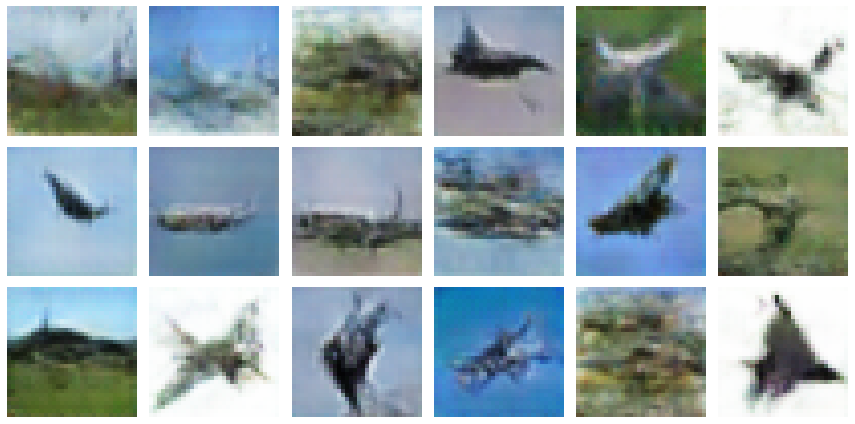

31/31 [==============================] - 149s 5s/step - g_loss: 3.9504 - d_loss: 0.1462 - real_acc: 0.9461 - gen_acc: 0.9458 - aug_p: 0.2448 - val_kid: 0.1935
Epoch 381/500
31/31 [==============================] - 149s 5s/step - g_loss: 4.5338 - d_loss: 0.1951 - real_acc: 0.9231 - gen_acc: 0.9201 - aug_p: 0.2473 - val_kid: 0.1738
Epoch 382/500
31/31 [==============================] - 133s 4s/step - g_loss: 4.4590 - d_loss: 0.1641 - real_acc: 0.9337 - gen_acc: 0.9372 - aug_p: 0.2497 - val_kid: 0.1765
Epoch 383/500
31/31 [==============================] - 135s 4s/step - g_loss: 5.1425 - d_loss: 0.1610 - real_acc: 0.9292 - gen_acc: 0.9380 - aug_p: 0.2523 - val_kid: 0.1744
Epoch 384/500
31/31 [==============================] - 145s 5s/step - g_loss: 5.4045 - d_loss: 0.1563 - real_acc: 0.9441 - gen_acc: 0.9355 - aug_p: 0.2551 - val_kid: 0.1762
Epoch 385/500
31/31 [==============================] - ETA: 0s - g_loss: 4.5470 - d_loss: 0.1548 - real_acc: 0.9456 - gen_acc: 0.9322 - aug_p: 0.2580

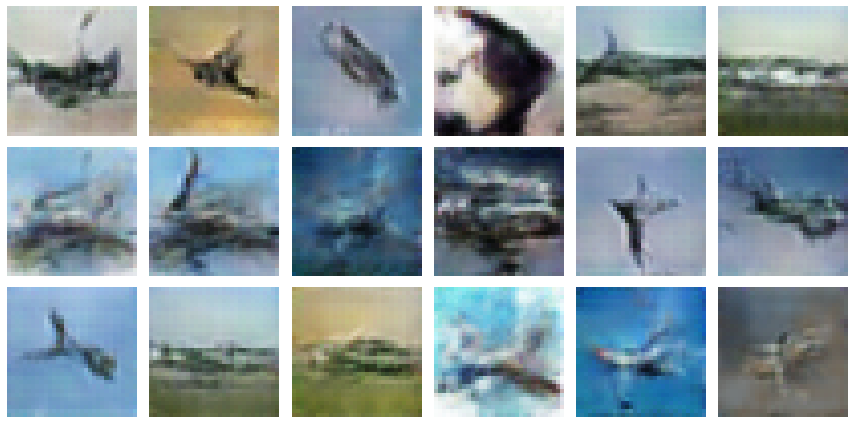

31/31 [==============================] - 146s 5s/step - g_loss: 4.5470 - d_loss: 0.1548 - real_acc: 0.9456 - gen_acc: 0.9322 - aug_p: 0.2580 - val_kid: 0.1870
Epoch 386/500
31/31 [==============================] - 149s 5s/step - g_loss: 4.9366 - d_loss: 0.1548 - real_acc: 0.9579 - gen_acc: 0.9425 - aug_p: 0.2612 - val_kid: 0.1989
Epoch 387/500
31/31 [==============================] - 145s 5s/step - g_loss: 5.3006 - d_loss: 0.1844 - real_acc: 0.9272 - gen_acc: 0.9204 - aug_p: 0.2638 - val_kid: 0.2056
Epoch 388/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.9700 - d_loss: 0.1497 - real_acc: 0.9415 - gen_acc: 0.9400 - aug_p: 0.2669 - val_kid: 0.2056
Epoch 389/500
31/31 [==============================] - 150s 5s/step - g_loss: 4.2164 - d_loss: 0.3202 - real_acc: 0.9070 - gen_acc: 0.8803 - aug_p: 0.2688 - val_kid: 0.2065
Epoch 390/500
31/31 [==============================] - ETA: 0s - g_loss: 4.2437 - d_loss: 0.1760 - real_acc: 0.9335 - gen_acc: 0.9302 - aug_p: 0.2710

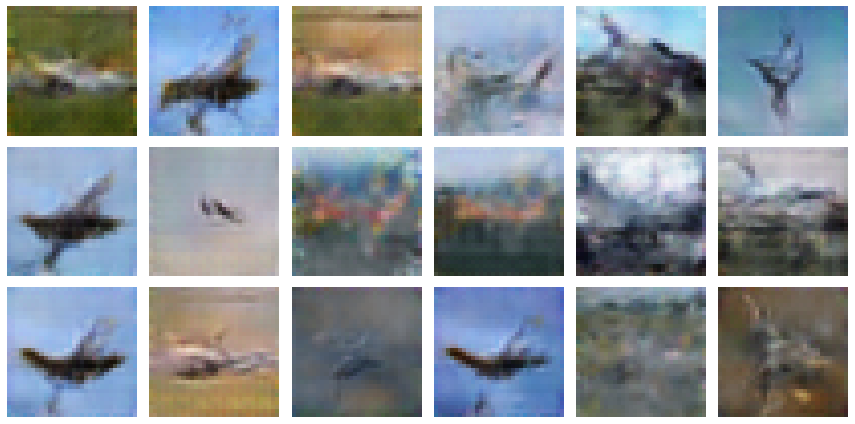

31/31 [==============================] - 151s 5s/step - g_loss: 4.2437 - d_loss: 0.1760 - real_acc: 0.9335 - gen_acc: 0.9302 - aug_p: 0.2710 - val_kid: 0.2104
Epoch 391/500
31/31 [==============================] - 148s 5s/step - g_loss: 4.0019 - d_loss: 0.1391 - real_acc: 0.9504 - gen_acc: 0.9526 - aug_p: 0.2739 - val_kid: 0.2154
Epoch 392/500
31/31 [==============================] - 150s 5s/step - g_loss: 5.1289 - d_loss: 0.2158 - real_acc: 0.9231 - gen_acc: 0.9088 - aug_p: 0.2766 - val_kid: 0.2101
Epoch 393/500
31/31 [==============================] - 150s 5s/step - g_loss: 4.5596 - d_loss: 0.2376 - real_acc: 0.9219 - gen_acc: 0.9065 - aug_p: 0.2790 - val_kid: 0.2189
Epoch 394/500
31/31 [==============================] - 149s 5s/step - g_loss: 4.5058 - d_loss: 0.1617 - real_acc: 0.9410 - gen_acc: 0.9453 - aug_p: 0.2813 - val_kid: 0.2194
Epoch 395/500
31/31 [==============================] - ETA: 0s - g_loss: 4.5709 - d_loss: 0.2209 - real_acc: 0.9133 - gen_acc: 0.9005 - aug_p: 0.2837

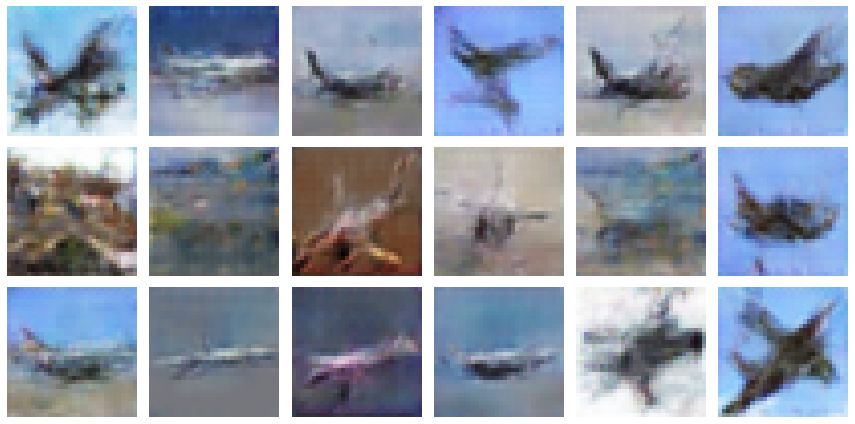

31/31 [==============================] - 149s 5s/step - g_loss: 4.5709 - d_loss: 0.2209 - real_acc: 0.9133 - gen_acc: 0.9005 - aug_p: 0.2837 - val_kid: 0.2138
Epoch 396/500
31/31 [==============================] - 148s 5s/step - g_loss: 4.2343 - d_loss: 0.1181 - real_acc: 0.9599 - gen_acc: 0.9609 - aug_p: 0.2866 - val_kid: 0.2065
Epoch 397/500
31/31 [==============================] - 149s 5s/step - g_loss: 4.7223 - d_loss: 0.1447 - real_acc: 0.9413 - gen_acc: 0.9539 - aug_p: 0.2899 - val_kid: 0.1953
Epoch 398/500
31/31 [==============================] - 147s 5s/step - g_loss: 4.0657 - d_loss: 0.1528 - real_acc: 0.9630 - gen_acc: 0.9385 - aug_p: 0.2928 - val_kid: 0.1733
Epoch 399/500
31/31 [==============================] - 149s 5s/step - g_loss: 4.4791 - d_loss: 0.1402 - real_acc: 0.9463 - gen_acc: 0.9478 - aug_p: 0.2960 - val_kid: 0.1807
Epoch 400/500
31/31 [==============================] - ETA: 0s - g_loss: 5.4103 - d_loss: 0.1793 - real_acc: 0.9372 - gen_acc: 0.9274 - aug_p: 0.2991

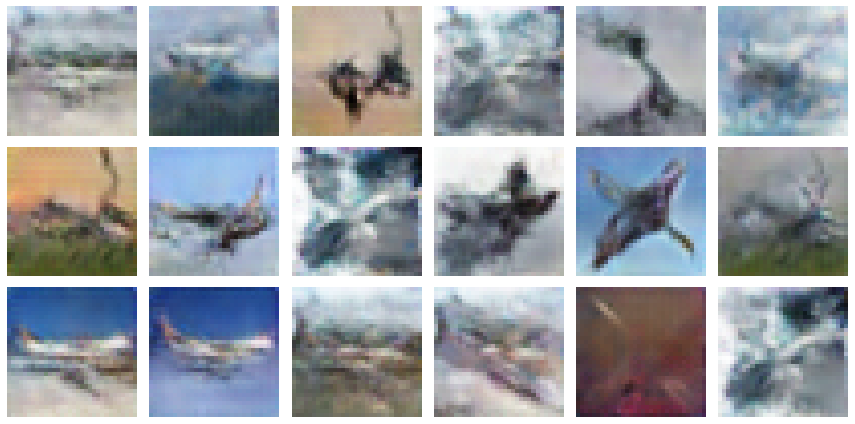

31/31 [==============================] - 149s 5s/step - g_loss: 5.4103 - d_loss: 0.1793 - real_acc: 0.9372 - gen_acc: 0.9274 - aug_p: 0.2991 - val_kid: 0.1733
Epoch 401/500
31/31 [==============================] - 150s 5s/step - g_loss: 4.9418 - d_loss: 0.2103 - real_acc: 0.9257 - gen_acc: 0.9211 - aug_p: 0.3017 - val_kid: 0.1834
Epoch 402/500
31/31 [==============================] - 138s 5s/step - g_loss: 4.6636 - d_loss: 0.1904 - real_acc: 0.9337 - gen_acc: 0.9249 - aug_p: 0.3036 - val_kid: 0.1875
Epoch 403/500
31/31 [==============================] - 124s 4s/step - g_loss: 4.0740 - d_loss: 0.1312 - real_acc: 0.9546 - gen_acc: 0.9572 - aug_p: 0.3067 - val_kid: 0.1861
Epoch 404/500
31/31 [==============================] - 139s 5s/step - g_loss: 4.1485 - d_loss: 0.1639 - real_acc: 0.9312 - gen_acc: 0.9335 - aug_p: 0.3094 - val_kid: 0.1773
Epoch 405/500
31/31 [==============================] - ETA: 0s - g_loss: 4.5735 - d_loss: 0.1693 - real_acc: 0.9385 - gen_acc: 0.9274 - aug_p: 0.3126

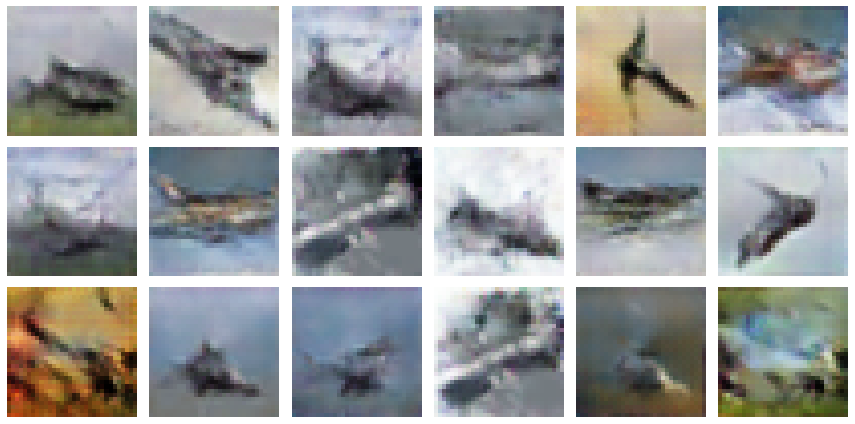

31/31 [==============================] - 140s 5s/step - g_loss: 4.5735 - d_loss: 0.1693 - real_acc: 0.9385 - gen_acc: 0.9274 - aug_p: 0.3126 - val_kid: 0.1702
Epoch 406/500
31/31 [==============================] - 131s 4s/step - g_loss: 4.5867 - d_loss: 0.1485 - real_acc: 0.9367 - gen_acc: 0.9582 - aug_p: 0.3153 - val_kid: 0.1713
Epoch 407/500
31/31 [==============================] - 129s 4s/step - g_loss: 4.7190 - d_loss: 0.2715 - real_acc: 0.9173 - gen_acc: 0.8879 - aug_p: 0.3174 - val_kid: 0.1783
Epoch 408/500
31/31 [==============================] - 142s 5s/step - g_loss: 4.1439 - d_loss: 0.1720 - real_acc: 0.9320 - gen_acc: 0.9350 - aug_p: 0.3198 - val_kid: 0.1847
Epoch 409/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.1505 - d_loss: 0.1533 - real_acc: 0.9441 - gen_acc: 0.9446 - aug_p: 0.3224 - val_kid: 0.1916
Epoch 410/500
31/31 [==============================] - ETA: 0s - g_loss: 4.4132 - d_loss: 0.1323 - real_acc: 0.9478 - gen_acc: 0.9514 - aug_p: 0.3254

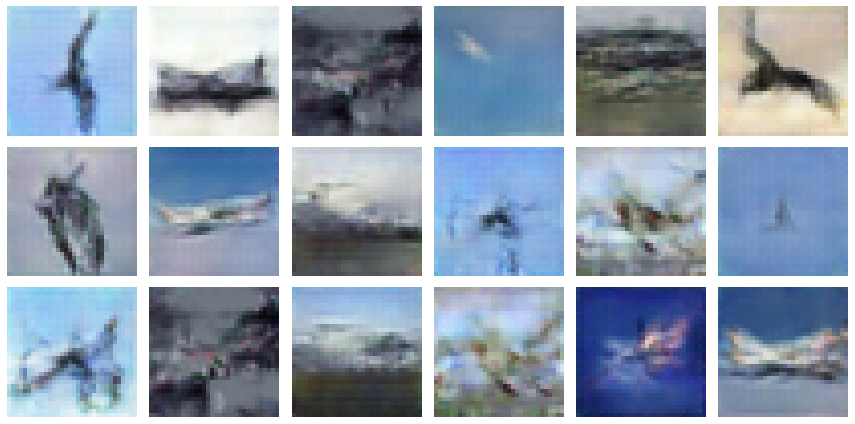

31/31 [==============================] - 144s 5s/step - g_loss: 4.4132 - d_loss: 0.1323 - real_acc: 0.9478 - gen_acc: 0.9514 - aug_p: 0.3254 - val_kid: 0.1719
Epoch 411/500
31/31 [==============================] - 145s 5s/step - g_loss: 4.4009 - d_loss: 0.1628 - real_acc: 0.9388 - gen_acc: 0.9367 - aug_p: 0.3283 - val_kid: 0.1811
Epoch 412/500
31/31 [==============================] - 121s 4s/step - g_loss: 4.6253 - d_loss: 0.2339 - real_acc: 0.9189 - gen_acc: 0.8906 - aug_p: 0.3305 - val_kid: 0.1816
Epoch 413/500
31/31 [==============================] - 144s 4s/step - g_loss: 4.6677 - d_loss: 0.2574 - real_acc: 0.9065 - gen_acc: 0.9032 - aug_p: 0.3326 - val_kid: 0.1905
Epoch 414/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.7512 - d_loss: 0.1795 - real_acc: 0.9272 - gen_acc: 0.9294 - aug_p: 0.3349 - val_kid: 0.1900
Epoch 415/500
31/31 [==============================] - ETA: 0s - g_loss: 4.2555 - d_loss: 0.2552 - real_acc: 0.8999 - gen_acc: 0.9123 - aug_p: 0.3370

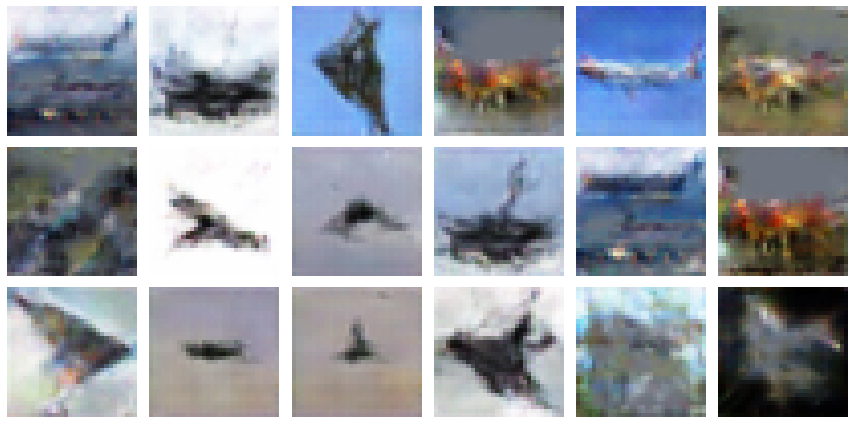

31/31 [==============================] - 146s 5s/step - g_loss: 4.2555 - d_loss: 0.2552 - real_acc: 0.8999 - gen_acc: 0.9123 - aug_p: 0.3370 - val_kid: 0.1881
Epoch 416/500
31/31 [==============================] - 144s 5s/step - g_loss: 3.8148 - d_loss: 0.1878 - real_acc: 0.9274 - gen_acc: 0.9289 - aug_p: 0.3388 - val_kid: 0.1853
Epoch 417/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.1917 - d_loss: 0.2653 - real_acc: 0.8967 - gen_acc: 0.9045 - aug_p: 0.3404 - val_kid: 0.1884
Epoch 418/500
31/31 [==============================] - 122s 4s/step - g_loss: 4.2478 - d_loss: 0.1287 - real_acc: 0.9574 - gen_acc: 0.9561 - aug_p: 0.3430 - val_kid: 0.1793
Epoch 419/500
31/31 [==============================] - 148s 5s/step - g_loss: 4.4685 - d_loss: 0.1263 - real_acc: 0.9597 - gen_acc: 0.9612 - aug_p: 0.3463 - val_kid: 0.1906
Epoch 420/500
31/31 [==============================] - ETA: 0s - g_loss: 4.4243 - d_loss: 0.1910 - real_acc: 0.9264 - gen_acc: 0.9246 - aug_p: 0.3494

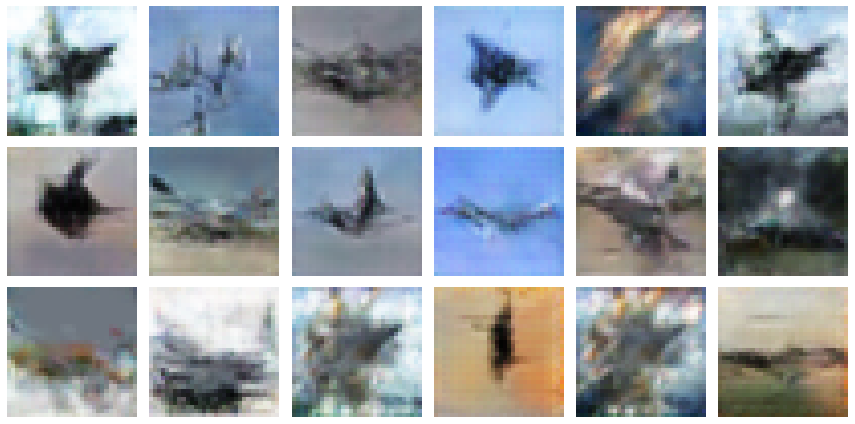

31/31 [==============================] - 146s 5s/step - g_loss: 4.4243 - d_loss: 0.1910 - real_acc: 0.9264 - gen_acc: 0.9246 - aug_p: 0.3494 - val_kid: 0.1910
Epoch 421/500
31/31 [==============================] - 148s 5s/step - g_loss: 4.3741 - d_loss: 0.2598 - real_acc: 0.9126 - gen_acc: 0.9191 - aug_p: 0.3513 - val_kid: 0.1859
Epoch 422/500
31/31 [==============================] - 145s 5s/step - g_loss: 4.1719 - d_loss: 0.1884 - real_acc: 0.9267 - gen_acc: 0.9181 - aug_p: 0.3536 - val_kid: 0.1697
Epoch 423/500
31/31 [==============================] - 147s 5s/step - g_loss: 3.8341 - d_loss: 0.1900 - real_acc: 0.9254 - gen_acc: 0.9347 - aug_p: 0.3560 - val_kid: 0.1777
Epoch 424/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.2147 - d_loss: 0.2068 - real_acc: 0.9378 - gen_acc: 0.9254 - aug_p: 0.3581 - val_kid: 0.1669
Epoch 425/500
31/31 [==============================] - ETA: 0s - g_loss: 3.8791 - d_loss: 0.1548 - real_acc: 0.9453 - gen_acc: 0.9435 - aug_p: 0.3613

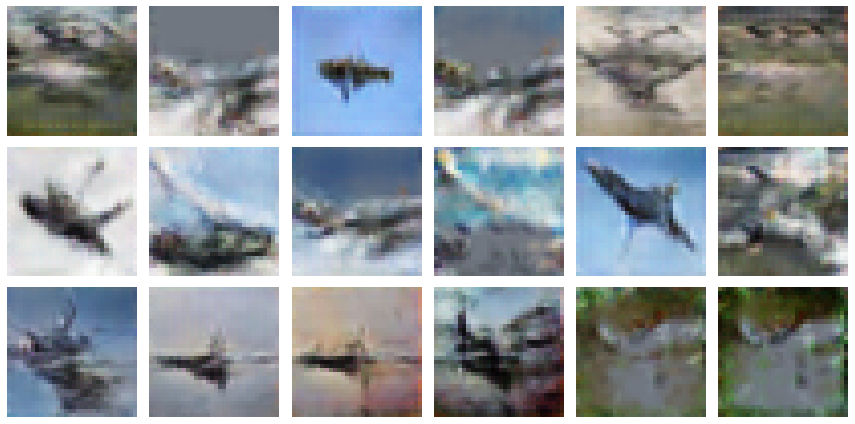

31/31 [==============================] - 146s 5s/step - g_loss: 3.8791 - d_loss: 0.1548 - real_acc: 0.9453 - gen_acc: 0.9435 - aug_p: 0.3613 - val_kid: 0.1773
Epoch 426/500
31/31 [==============================] - 121s 4s/step - g_loss: 4.8708 - d_loss: 0.2135 - real_acc: 0.9342 - gen_acc: 0.9320 - aug_p: 0.3642 - val_kid: 0.1873
Epoch 427/500
31/31 [==============================] - 145s 4s/step - g_loss: 4.4929 - d_loss: 0.1680 - real_acc: 0.9461 - gen_acc: 0.9435 - aug_p: 0.3671 - val_kid: 0.1978
Epoch 428/500
31/31 [==============================] - 143s 5s/step - g_loss: 4.8133 - d_loss: 0.1964 - real_acc: 0.9342 - gen_acc: 0.9224 - aug_p: 0.3694 - val_kid: 0.2163
Epoch 429/500
31/31 [==============================] - 140s 5s/step - g_loss: 4.1347 - d_loss: 0.2881 - real_acc: 0.9176 - gen_acc: 0.9120 - aug_p: 0.3722 - val_kid: 0.2155
Epoch 430/500
31/31 [==============================] - ETA: 0s - g_loss: 3.6467 - d_loss: 0.1539 - real_acc: 0.9415 - gen_acc: 0.9476 - aug_p: 0.3746

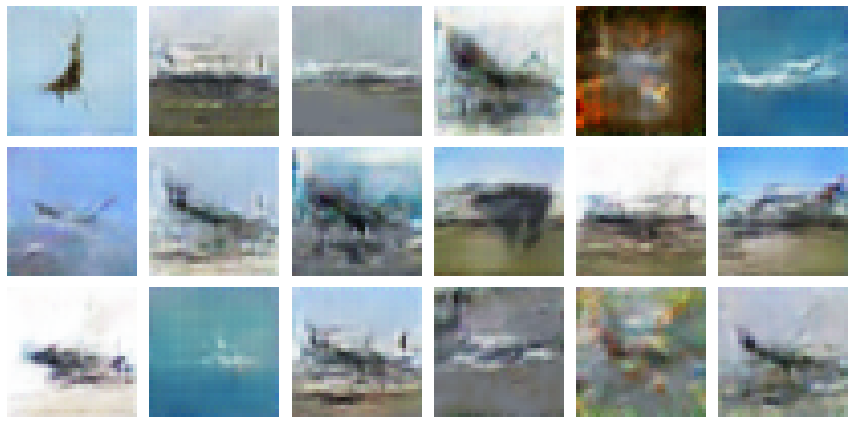

31/31 [==============================] - 122s 4s/step - g_loss: 3.6467 - d_loss: 0.1539 - real_acc: 0.9415 - gen_acc: 0.9476 - aug_p: 0.3746 - val_kid: 0.2194
Epoch 431/500
31/31 [==============================] - 134s 4s/step - g_loss: 4.5408 - d_loss: 0.2287 - real_acc: 0.9007 - gen_acc: 0.9161 - aug_p: 0.3769 - val_kid: 0.2057
Epoch 432/500
31/31 [==============================] - 139s 5s/step - g_loss: 4.4564 - d_loss: 0.1304 - real_acc: 0.9577 - gen_acc: 0.9554 - aug_p: 0.3791 - val_kid: 0.1949
Epoch 433/500
31/31 [==============================] - 130s 4s/step - g_loss: 4.1209 - d_loss: 0.2179 - real_acc: 0.9279 - gen_acc: 0.9143 - aug_p: 0.3820 - val_kid: 0.1924
Epoch 434/500
31/31 [==============================] - 128s 4s/step - g_loss: 4.1664 - d_loss: 0.1320 - real_acc: 0.9509 - gen_acc: 0.9609 - aug_p: 0.3849 - val_kid: 0.1725
Epoch 435/500
31/31 [==============================] - ETA: 0s - g_loss: 4.6012 - d_loss: 0.1932 - real_acc: 0.9277 - gen_acc: 0.9282 - aug_p: 0.3877

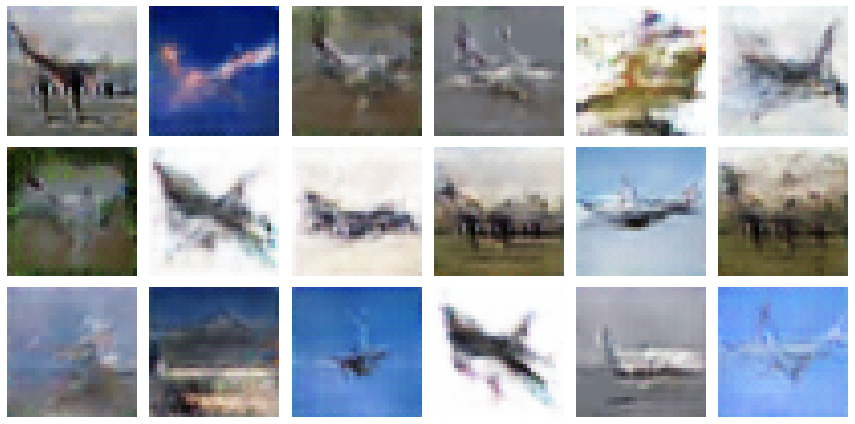

31/31 [==============================] - 142s 5s/step - g_loss: 4.6012 - d_loss: 0.1932 - real_acc: 0.9277 - gen_acc: 0.9282 - aug_p: 0.3877 - val_kid: 0.1705
Epoch 436/500
31/31 [==============================] - 143s 5s/step - g_loss: 4.5499 - d_loss: 0.2230 - real_acc: 0.9277 - gen_acc: 0.9191 - aug_p: 0.3901 - val_kid: 0.1731
Epoch 437/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.3787 - d_loss: 0.1631 - real_acc: 0.9370 - gen_acc: 0.9453 - aug_p: 0.3924 - val_kid: 0.1869
Epoch 438/500
31/31 [==============================] - 126s 4s/step - g_loss: 4.3572 - d_loss: 0.1774 - real_acc: 0.9307 - gen_acc: 0.9378 - aug_p: 0.3949 - val_kid: 0.1967
Epoch 439/500
31/31 [==============================] - 142s 4s/step - g_loss: 4.1338 - d_loss: 0.1281 - real_acc: 0.9488 - gen_acc: 0.9604 - aug_p: 0.3978 - val_kid: 0.1896
Epoch 440/500
31/31 [==============================] - ETA: 0s - g_loss: 4.2418 - d_loss: 0.1823 - real_acc: 0.9231 - gen_acc: 0.9262 - aug_p: 0.4007

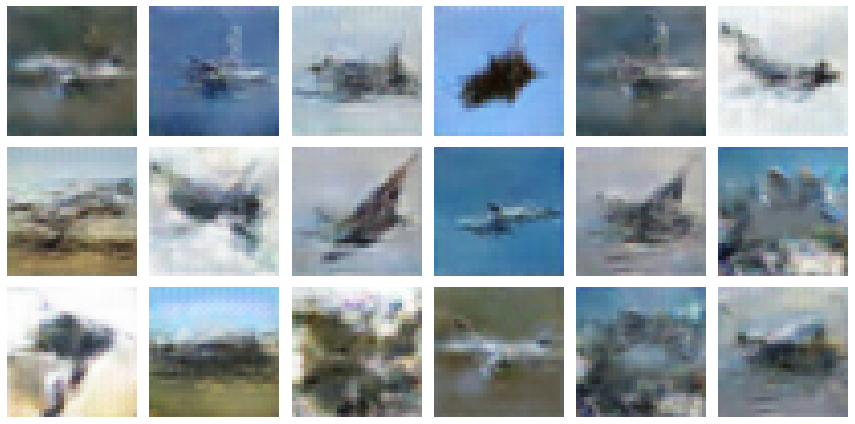

31/31 [==============================] - 144s 5s/step - g_loss: 4.2418 - d_loss: 0.1823 - real_acc: 0.9231 - gen_acc: 0.9262 - aug_p: 0.4007 - val_kid: 0.1952
Epoch 441/500
31/31 [==============================] - 142s 5s/step - g_loss: 4.4493 - d_loss: 0.1413 - real_acc: 0.9551 - gen_acc: 0.9375 - aug_p: 0.4035 - val_kid: 0.2067
Epoch 442/500
31/31 [==============================] - 144s 5s/step - g_loss: 4.8216 - d_loss: 0.2327 - real_acc: 0.9012 - gen_acc: 0.8904 - aug_p: 0.4054 - val_kid: 0.2066
Epoch 443/500
31/31 [==============================] - 144s 5s/step - g_loss: 3.9102 - d_loss: 0.2261 - real_acc: 0.9007 - gen_acc: 0.9272 - aug_p: 0.4074 - val_kid: 0.2047
Epoch 444/500
31/31 [==============================] - 147s 5s/step - g_loss: 4.1157 - d_loss: 0.1604 - real_acc: 0.9420 - gen_acc: 0.9289 - aug_p: 0.4096 - val_kid: 0.1975
Epoch 445/500
31/31 [==============================] - ETA: 0s - g_loss: 4.9856 - d_loss: 0.1744 - real_acc: 0.9257 - gen_acc: 0.9297 - aug_p: 0.4119

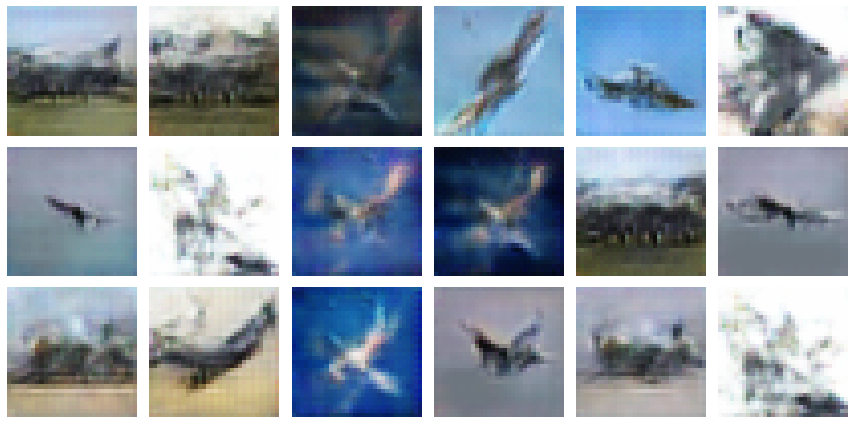

31/31 [==============================] - 133s 4s/step - g_loss: 4.9856 - d_loss: 0.1744 - real_acc: 0.9257 - gen_acc: 0.9297 - aug_p: 0.4119 - val_kid: 0.1933
Epoch 446/500
31/31 [==============================] - 134s 4s/step - g_loss: 4.2891 - d_loss: 0.1506 - real_acc: 0.9526 - gen_acc: 0.9398 - aug_p: 0.4150 - val_kid: 0.2060
Epoch 447/500
31/31 [==============================] - 146s 5s/step - g_loss: 4.5006 - d_loss: 0.1907 - real_acc: 0.9327 - gen_acc: 0.9420 - aug_p: 0.4175 - val_kid: 0.2058
Epoch 448/500
31/31 [==============================] - 152s 5s/step - g_loss: 4.4174 - d_loss: 0.1544 - real_acc: 0.9438 - gen_acc: 0.9435 - aug_p: 0.4207 - val_kid: 0.2111
Epoch 449/500
31/31 [==============================] - 181s 6s/step - g_loss: 4.5262 - d_loss: 0.0995 - real_acc: 0.9713 - gen_acc: 0.9713 - aug_p: 0.4239 - val_kid: 0.2078
Epoch 450/500
31/31 [==============================] - ETA: 0s - g_loss: 4.9895 - d_loss: 0.2453 - real_acc: 0.9050 - gen_acc: 0.9045 - aug_p: 0.4265

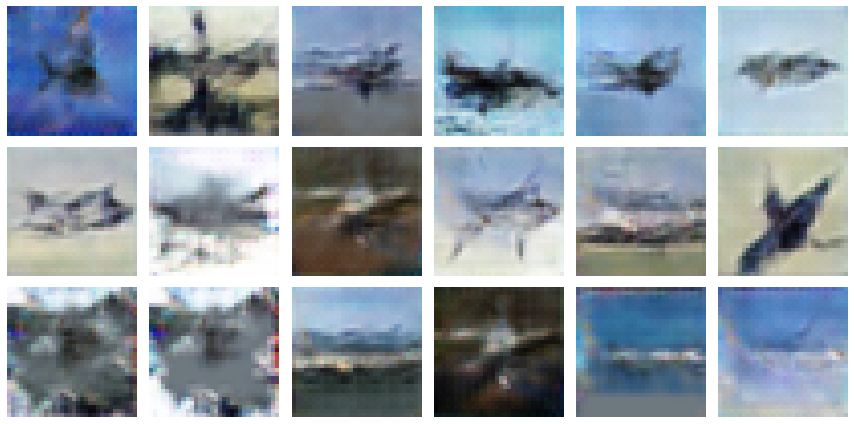

31/31 [==============================] - 166s 5s/step - g_loss: 4.9895 - d_loss: 0.2453 - real_acc: 0.9050 - gen_acc: 0.9045 - aug_p: 0.4265 - val_kid: 0.2108
Epoch 451/500
31/31 [==============================] - 340s 11s/step - g_loss: 3.9035 - d_loss: 0.1569 - real_acc: 0.9330 - gen_acc: 0.9486 - aug_p: 0.4286 - val_kid: 0.1959
Epoch 452/500
31/31 [==============================] - 383s 13s/step - g_loss: 4.2174 - d_loss: 0.1268 - real_acc: 0.9657 - gen_acc: 0.9509 - aug_p: 0.4318 - val_kid: 0.2011
Epoch 453/500
31/31 [==============================] - 333s 10s/step - g_loss: 4.4181 - d_loss: 0.1898 - real_acc: 0.9254 - gen_acc: 0.9201 - aug_p: 0.4345 - val_kid: 0.2068
Epoch 454/500
31/31 [==============================] - 345s 11s/step - g_loss: 4.5759 - d_loss: 0.1542 - real_acc: 0.9471 - gen_acc: 0.9408 - aug_p: 0.4373 - val_kid: 0.2059
Epoch 455/500
31/31 [==============================] - ETA: 0s - g_loss: 5.2902 - d_loss: 0.1191 - real_acc: 0.9559 - gen_acc: 0.9509 - aug_p: 0.

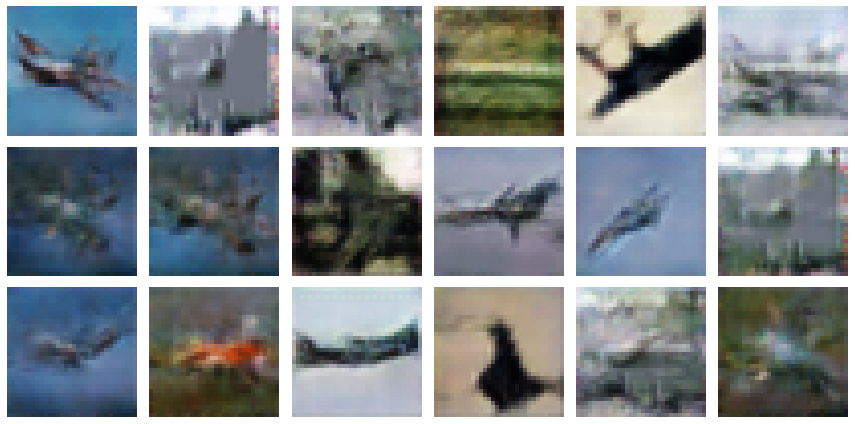

31/31 [==============================] - 364s 11s/step - g_loss: 5.2902 - d_loss: 0.1191 - real_acc: 0.9559 - gen_acc: 0.9509 - aug_p: 0.4406 - val_kid: 0.2066
Epoch 456/500
31/31 [==============================] - 331s 10s/step - g_loss: 4.9748 - d_loss: 0.2598 - real_acc: 0.9201 - gen_acc: 0.9052 - aug_p: 0.4435 - val_kid: 0.2048
Epoch 457/500
31/31 [==============================] - 342s 10s/step - g_loss: 4.5611 - d_loss: 0.1386 - real_acc: 0.9380 - gen_acc: 0.9561 - aug_p: 0.4457 - val_kid: 0.1887
Epoch 458/500
31/31 [==============================] - 343s 11s/step - g_loss: 4.3310 - d_loss: 0.1314 - real_acc: 0.9597 - gen_acc: 0.9539 - aug_p: 0.4488 - val_kid: 0.2084
Epoch 459/500
31/31 [==============================] - 343s 11s/step - g_loss: 4.8886 - d_loss: 0.2084 - real_acc: 0.9463 - gen_acc: 0.9476 - aug_p: 0.4521 - val_kid: 0.2216
Epoch 460/500
31/31 [==============================] - ETA: 0s - g_loss: 4.7663 - d_loss: 0.0780 - real_acc: 0.9751 - gen_acc: 0.9811 - aug_p: 0

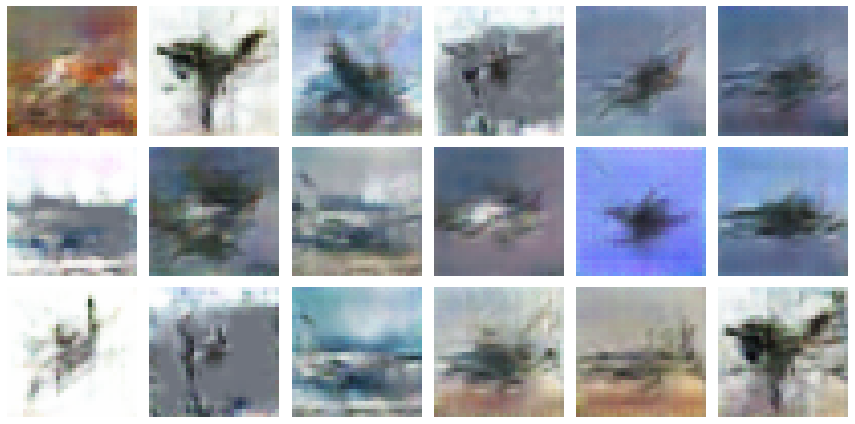

31/31 [==============================] - 357s 12s/step - g_loss: 4.7663 - d_loss: 0.0780 - real_acc: 0.9751 - gen_acc: 0.9811 - aug_p: 0.4555 - val_kid: 0.2276
Epoch 461/500
31/31 [==============================] - 343s 11s/step - g_loss: 5.6903 - d_loss: 0.1479 - real_acc: 0.9461 - gen_acc: 0.9400 - aug_p: 0.4590 - val_kid: 0.2246
Epoch 462/500
31/31 [==============================] - 342s 11s/step - g_loss: 5.2472 - d_loss: 0.1042 - real_acc: 0.9705 - gen_acc: 0.9574 - aug_p: 0.4623 - val_kid: 0.2259
Epoch 463/500
31/31 [==============================] - 346s 11s/step - g_loss: 5.3607 - d_loss: 0.1257 - real_acc: 0.9488 - gen_acc: 0.9519 - aug_p: 0.4655 - val_kid: 0.2408
Epoch 464/500
31/31 [==============================] - 341s 11s/step - g_loss: 5.8057 - d_loss: 0.1564 - real_acc: 0.9423 - gen_acc: 0.9468 - aug_p: 0.4687 - val_kid: 0.2375
Epoch 465/500
31/31 [==============================] - ETA: 0s - g_loss: 5.5840 - d_loss: 0.1469 - real_acc: 0.9665 - gen_acc: 0.9325 - aug_p: 0

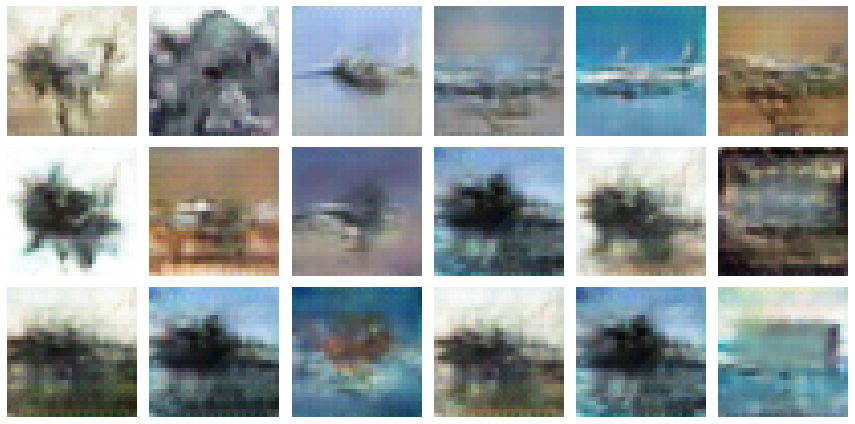

31/31 [==============================] - 356s 11s/step - g_loss: 5.5840 - d_loss: 0.1469 - real_acc: 0.9665 - gen_acc: 0.9325 - aug_p: 0.4719 - val_kid: 0.2352
Epoch 466/500
31/31 [==============================] - 311s 10s/step - g_loss: 5.5335 - d_loss: 0.1603 - real_acc: 0.9378 - gen_acc: 0.9294 - aug_p: 0.4749 - val_kid: 0.2432
Epoch 467/500
31/31 [==============================] - 342s 10s/step - g_loss: 4.6844 - d_loss: 0.1221 - real_acc: 0.9486 - gen_acc: 0.9604 - aug_p: 0.4781 - val_kid: 0.2376
Epoch 468/500
31/31 [==============================] - 341s 11s/step - g_loss: 5.6151 - d_loss: 0.2160 - real_acc: 0.9395 - gen_acc: 0.9398 - aug_p: 0.4807 - val_kid: 0.2320
Epoch 469/500
31/31 [==============================] - 346s 11s/step - g_loss: 4.5602 - d_loss: 0.2106 - real_acc: 0.9471 - gen_acc: 0.9284 - aug_p: 0.4838 - val_kid: 0.2278
Epoch 470/500
31/31 [==============================] - ETA: 0s - g_loss: 5.1591 - d_loss: 0.1854 - real_acc: 0.9289 - gen_acc: 0.9418 - aug_p: 0

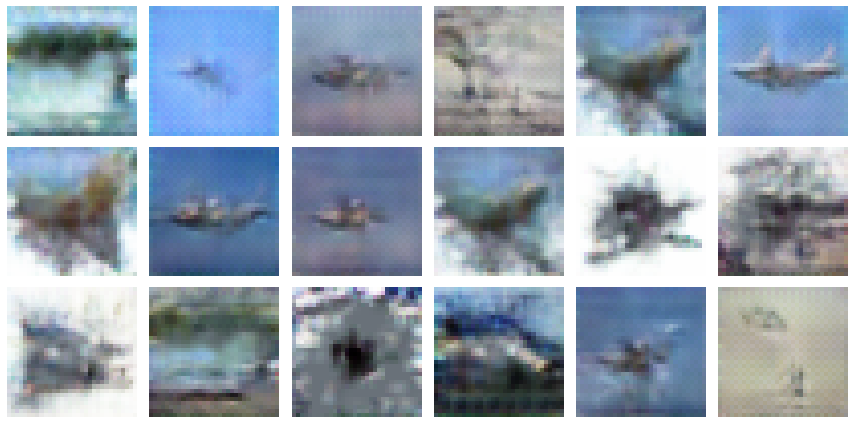

31/31 [==============================] - 351s 11s/step - g_loss: 5.1591 - d_loss: 0.1854 - real_acc: 0.9289 - gen_acc: 0.9418 - aug_p: 0.4866 - val_kid: 0.2300
Epoch 471/500
31/31 [==============================] - 340s 11s/step - g_loss: 4.7642 - d_loss: 0.1612 - real_acc: 0.9529 - gen_acc: 0.9302 - aug_p: 0.4892 - val_kid: 0.2324
Epoch 472/500
31/31 [==============================] - 345s 11s/step - g_loss: 5.0029 - d_loss: 0.2342 - real_acc: 0.8952 - gen_acc: 0.9078 - aug_p: 0.4916 - val_kid: 0.2347
Epoch 473/500
31/31 [==============================] - 318s 10s/step - g_loss: 4.8638 - d_loss: 0.1649 - real_acc: 0.9410 - gen_acc: 0.9277 - aug_p: 0.4939 - val_kid: 0.2274
Epoch 474/500
31/31 [==============================] - 340s 10s/step - g_loss: 4.5301 - d_loss: 0.2247 - real_acc: 0.9234 - gen_acc: 0.9156 - aug_p: 0.4964 - val_kid: 0.2235
Epoch 475/500
31/31 [==============================] - ETA: 0s - g_loss: 4.4220 - d_loss: 0.1513 - real_acc: 0.9446 - gen_acc: 0.9357 - aug_p: 0

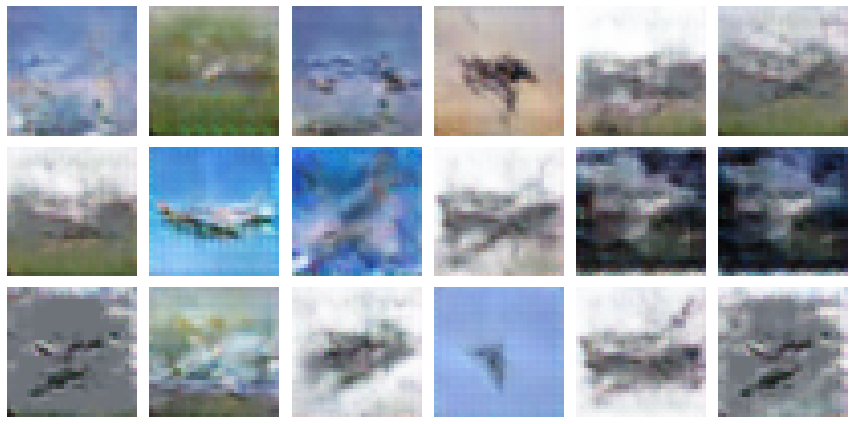

31/31 [==============================] - 340s 11s/step - g_loss: 4.4220 - d_loss: 0.1513 - real_acc: 0.9446 - gen_acc: 0.9357 - aug_p: 0.4988 - val_kid: 0.2181
Epoch 476/500
31/31 [==============================] - 340s 11s/step - g_loss: 4.4690 - d_loss: 0.1423 - real_acc: 0.9519 - gen_acc: 0.9567 - aug_p: 0.5020 - val_kid: 0.2203
Epoch 477/500
31/31 [==============================] - 343s 11s/step - g_loss: 4.8084 - d_loss: 0.1812 - real_acc: 0.9446 - gen_acc: 0.9282 - aug_p: 0.5051 - val_kid: 0.2286
Epoch 478/500
31/31 [==============================] - 345s 11s/step - g_loss: 4.6765 - d_loss: 0.1261 - real_acc: 0.9554 - gen_acc: 0.9577 - aug_p: 0.5082 - val_kid: 0.2404
Epoch 479/500
31/31 [==============================] - 331s 11s/step - g_loss: 5.2640 - d_loss: 0.1385 - real_acc: 0.9506 - gen_acc: 0.9360 - aug_p: 0.5112 - val_kid: 0.2428
Epoch 480/500
31/31 [==============================] - ETA: 0s - g_loss: 4.7354 - d_loss: 0.1420 - real_acc: 0.9456 - gen_acc: 0.9486 - aug_p: 0

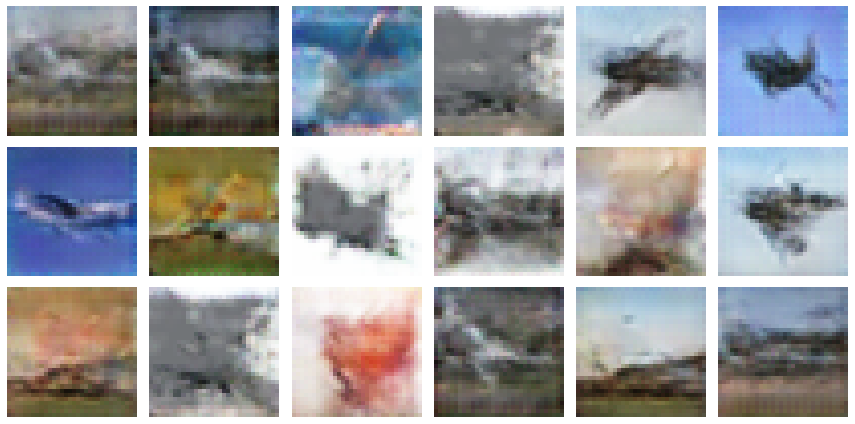

31/31 [==============================] - 360s 11s/step - g_loss: 4.7354 - d_loss: 0.1420 - real_acc: 0.9456 - gen_acc: 0.9486 - aug_p: 0.5140 - val_kid: 0.2422
Epoch 481/500
31/31 [==============================] - 317s 10s/step - g_loss: 5.5095 - d_loss: 0.1326 - real_acc: 0.9574 - gen_acc: 0.9408 - aug_p: 0.5173 - val_kid: 0.2408
Epoch 482/500
31/31 [==============================] - 339s 10s/step - g_loss: 4.9575 - d_loss: 0.1720 - real_acc: 0.9312 - gen_acc: 0.9302 - aug_p: 0.5203 - val_kid: 0.2432
Epoch 483/500
31/31 [==============================] - 344s 11s/step - g_loss: 4.5053 - d_loss: 0.1918 - real_acc: 0.9189 - gen_acc: 0.9178 - aug_p: 0.5228 - val_kid: 0.2496
Epoch 484/500
31/31 [==============================] - 342s 11s/step - g_loss: 5.6404 - d_loss: 0.1428 - real_acc: 0.9458 - gen_acc: 0.9418 - aug_p: 0.5251 - val_kid: 0.2377
Epoch 485/500
31/31 [==============================] - ETA: 0s - g_loss: 5.1682 - d_loss: 0.1173 - real_acc: 0.9637 - gen_acc: 0.9524 - aug_p: 0

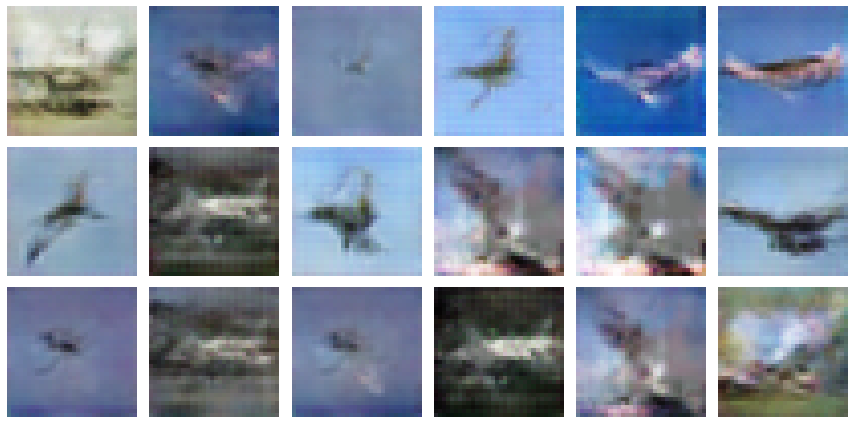

31/31 [==============================] - 350s 11s/step - g_loss: 5.1682 - d_loss: 0.1173 - real_acc: 0.9637 - gen_acc: 0.9524 - aug_p: 0.5285 - val_kid: 0.2320
Epoch 486/500
31/31 [==============================] - 337s 10s/step - g_loss: 4.6390 - d_loss: 0.1738 - real_acc: 0.9279 - gen_acc: 0.9357 - aug_p: 0.5314 - val_kid: 0.2328
Epoch 487/500
31/31 [==============================] - 345s 11s/step - g_loss: 5.5395 - d_loss: 0.1814 - real_acc: 0.9156 - gen_acc: 0.9272 - aug_p: 0.5334 - val_kid: 0.2328
Epoch 488/500
31/31 [==============================] - 336s 11s/step - g_loss: 4.8726 - d_loss: 0.1324 - real_acc: 0.9496 - gen_acc: 0.9496 - aug_p: 0.5360 - val_kid: 0.2273
Epoch 489/500
31/31 [==============================] - 343s 11s/step - g_loss: 5.0872 - d_loss: 0.2296 - real_acc: 0.9284 - gen_acc: 0.9161 - aug_p: 0.5389 - val_kid: 0.2350
Epoch 490/500
31/31 [==============================] - ETA: 0s - g_loss: 4.2225 - d_loss: 0.1990 - real_acc: 0.9035 - gen_acc: 0.9375 - aug_p: 0

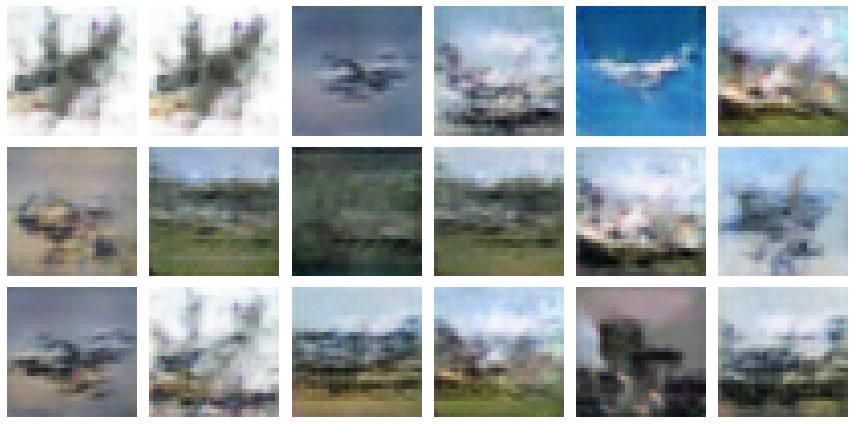

31/31 [==============================] - 346s 11s/step - g_loss: 4.2225 - d_loss: 0.1990 - real_acc: 0.9035 - gen_acc: 0.9375 - aug_p: 0.5411 - val_kid: 0.2258
Epoch 491/500
31/31 [==============================] - 346s 11s/step - g_loss: 3.8897 - d_loss: 0.1554 - real_acc: 0.9559 - gen_acc: 0.9292 - aug_p: 0.5433 - val_kid: 0.2455
Epoch 492/500
31/31 [==============================] - 347s 11s/step - g_loss: 4.2377 - d_loss: 0.1744 - real_acc: 0.9320 - gen_acc: 0.9279 - aug_p: 0.5464 - val_kid: 0.2458
Epoch 493/500
31/31 [==============================] - 308s 10s/step - g_loss: 4.5020 - d_loss: 0.2356 - real_acc: 0.9181 - gen_acc: 0.8989 - aug_p: 0.5483 - val_kid: 0.2424
Epoch 494/500
31/31 [==============================] - 344s 11s/step - g_loss: 4.4297 - d_loss: 0.1780 - real_acc: 0.9335 - gen_acc: 0.9383 - aug_p: 0.5509 - val_kid: 0.2378
Epoch 495/500
31/31 [==============================] - ETA: 0s - g_loss: 4.4197 - d_loss: 0.1471 - real_acc: 0.9425 - gen_acc: 0.9405 - aug_p: 0

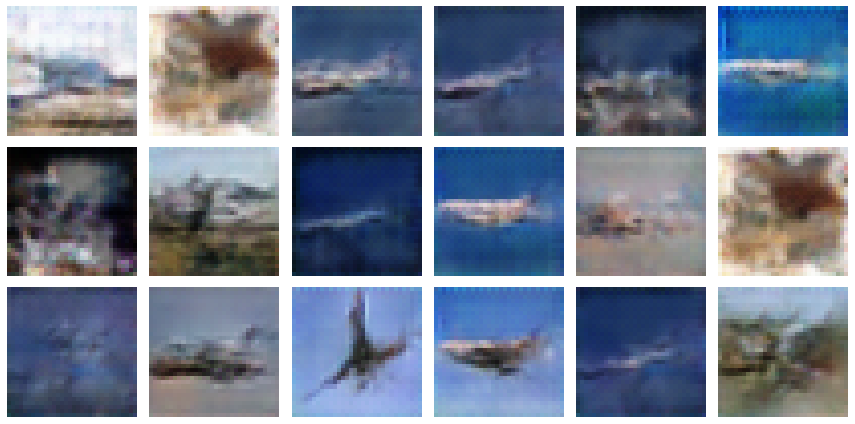

31/31 [==============================] - 364s 11s/step - g_loss: 4.4197 - d_loss: 0.1471 - real_acc: 0.9425 - gen_acc: 0.9405 - aug_p: 0.5538 - val_kid: 0.2376
Epoch 496/500
31/31 [==============================] - 324s 10s/step - g_loss: 4.6482 - d_loss: 0.2916 - real_acc: 0.9133 - gen_acc: 0.9035 - aug_p: 0.5561 - val_kid: 0.2431
Epoch 497/500
31/31 [==============================] - 340s 11s/step - g_loss: 4.3749 - d_loss: 0.2685 - real_acc: 0.8889 - gen_acc: 0.9060 - aug_p: 0.5575 - val_kid: 0.2318
Epoch 498/500
31/31 [==============================] - 343s 11s/step - g_loss: 3.9028 - d_loss: 0.1835 - real_acc: 0.9294 - gen_acc: 0.9312 - aug_p: 0.5596 - val_kid: 0.2246
Epoch 499/500
31/31 [==============================] - 335s 11s/step - g_loss: 4.7031 - d_loss: 0.1796 - real_acc: 0.9327 - gen_acc: 0.9262 - aug_p: 0.5624 - val_kid: 0.2254
Epoch 500/500
31/31 [==============================] - ETA: 0s - g_loss: 4.4087 - d_loss: 0.1538 - real_acc: 0.9425 - gen_acc: 0.9448 - aug_p: 0

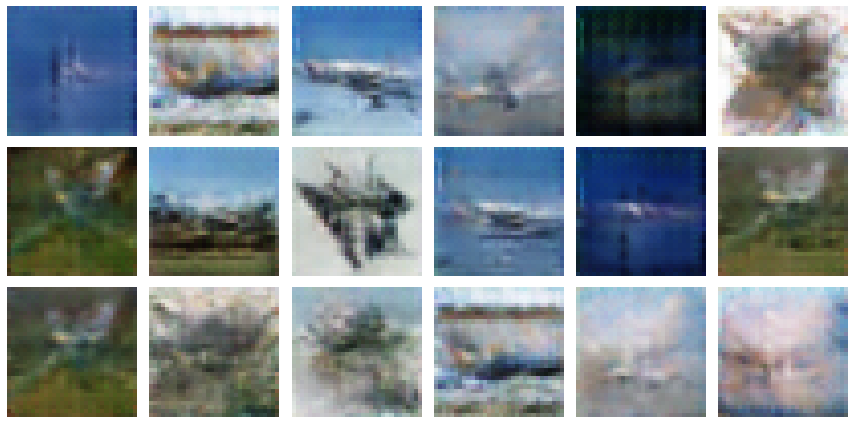

31/31 [==============================] - 348s 11s/step - g_loss: 4.4087 - d_loss: 0.1538 - real_acc: 0.9425 - gen_acc: 0.9448 - aug_p: 0.5649 - val_kid: 0.2286


In [7]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

In [8]:
import tensorflow as tf

tf.saved_model.save(model, "DCGAN_Cifar_Plane_same")


INFO:tensorflow:Assets written to: DCGAN_Cifar_Plane_same\assets


INFO:tensorflow:Assets written to: DCGAN_Cifar_Plane_same\assets


In [ ]:
def plot_images_best(model, num_rows=5, num_cols=4):
    # plot random generated images for visual evaluation of generation quality
    
    # Generate a large number of images, to choose the best from
    num_images = 5000
    generated_images = model.generate(num_images, training=False)

    # Extract the indices of the n best generated images based on the output from the discriminator
    scores = model.discriminator(generated_images)
    num_gen = num_rows * num_cols
    v, ind = tf.math.top_k(scores[:, 0], k=num_gen, sorted=False)
    print(v)
    print(ind)
    
    # Iterate over the best images and plot them all
    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            ii = ind[index]
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(generated_images[ii])
            
            # Convert the tensor to a PIL Image
            pil_img = tf.keras.preprocessing.image.array_to_img(generated_images[ii])

            # Save the image to a file
            pil_img.save("generated_images_cifar_plane_"+str(index)+".png")
            
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()       
        
plot_images_best(model)        

In [ ]:
# Load ESRGAN model to increase the size of the generated images and improve their resolution 

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
# Declaring Constants
ESRGAN_path = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model_super = hub.load(ESRGAN_path)

In [ ]:
# Post Processing Functions to increase the size and resolution of the generated images

def postprocess(image_tensor):
    

    size = image_tensor.shape[1]
    new_size = size * 2
    # Upsample the image using TensorFlow
    resized_image = tf.image.resize(image_tensor, [new_size, new_size], method=tf.image.ResizeMethod.BICUBIC)

    # Apply denoising using OpenCV
    denoised_image = cv2.medianBlur(resized_image.numpy(), 3)

    #Applying sharpening filter
    pil_img = tf.keras.preprocessing.image.array_to_img(denoised_image)
    sharp = pil_img.filter(ImageFilter.SHARPEN)

    return sharp

def resize_res(image_tensor):

    # First denoise the image and prepare it for the ESRGAN model 
    denoised_image = cv2.medianBlur(image_tensor.numpy(), 3)
    image = tf.expand_dims(denoised_image, 0)
    image = image * 255

    # Improve the image with the ESRGAN model
    fake_image = model_super(image,training=False)

    # Prepare image for plotting and later use
    fake_image = tf.squeeze(fake_image)
    fake_image = fake_image / 255

    return fake_image


In [ ]:
def display_images(images):

    # Declare necessary variables for plotting configuration
    columns=5
    width=25
    height=10

    # Check if there are images for plotting
    if not images:
        print("No images to display.")
        return 

    # Plotting configuration    
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))

    # Plot the images in subplots
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

In [ ]:
# Function to plot the best images generated from the model and their resized versions

def plot_images_post(model, num_generated_images):
    # plot random generated images for visual evaluation of generation quality
    
    # Generate a large number of images, to choose the best from
    num_images = 5000
    generated_images = model.generate(num_images, training=False)

    # Extract the indices of the n best generated images based on the output from the discriminator
    scores = model.discriminator(generated_images)
    v, ind = tf.math.top_k(scores[:, 0], k=num_generated_images, sorted=True)
    print(v)
    print(ind)

    # Iterate over the best images, apply the resizing and improvement functions and plot them all
    for i in range(len(ind)):

        # Extract the best images based on the indices
        ii = ind[i]
        image_tensor = generated_images[ii]

        # First resizing and sharpening of the image (output size = 64*64*3)
        sharp = postprocess(image_tensor)

        # Second resizing and sharpening of the image (output size = 128*128*3)
        sharp_array = tf.keras.preprocessing.image.img_to_array(sharp)
        sharp1 = postprocess(sharp_array)

        # Improvement of the resolution and resizing using the ESRGAN model (output size = 128*128*3)
        res_image = resize_res(image_tensor)

        # Second improvement of the resolution and resizing using the ESRGAN model (output size = 256*256*3)
        resized_image_2 = tf.image.resize(image_tensor, [64, 64], method=tf.image.ResizeMethod.BICUBIC)
        res_image_256 = resize_res(resized_image_2)

        # Plotting of all images
        imgs = [image_tensor,sharp,sharp1,res_image,res_image_256]
        display_images(imgs)
    
num_generated_images = 20        
plot_images_post(model,num_generated_images)        